In [1]:
%%writefile utils.py
# utils.py

import base64
import glob
import io
import numpy as np
from collections import defaultdict

from IPython.display import HTML
from IPython import display
import gym
from gym import spaces
from gym.wrappers import RecordVideo
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX

# 최대 환경 스텝 수
max_env_steps = 50


class StripHighlightRenderWrapper(gym.Wrapper):
    def render(self, *args, **kwargs):
        kwargs.pop('highlight', None)
        return self.env.render(*args, **kwargs)


class FlatObsWrapper(gym.ObservationWrapper):
    """
    Grid를 평탄화(flatten)하여 1차원 벡터로 반환하는 Observation Wrapper
    """

    def __init__(self, env):
        super().__init__(env)
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width - 2) * (self.env.height - 2) * 3,),
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

    def render(self, *args, **kwargs):
        kwargs.pop('highlight', None)
        return self.env.render(*args, **kwargs)

    def observation(self, obs):
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]
        return full_grid.ravel()


def show_video():
    """
    저장된 비디오를 Colab에 바로 표시하는 함수
    """
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[-1]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data=f'''
            <video alt="environment video" autoplay loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
            </video>'''))
    else:
        print("❌ No video found in ./video")


def wrap_env(env):
    """
    비디오 저장 기능을 추가한 래퍼
    """
    return RecordVideo(env, video_folder='./video', episode_trigger=lambda ep: True)


def gen_wrapped_env(env_name):
    """
    MiniGrid 환경 생성 + 평탄화 관찰 + 비디오 기록
    """
    env = gym.make(env_name, render_mode='rgb_array')  # 반드시 render_mode 설정
    env = StripHighlightRenderWrapper(env)
    env = FlatObsWrapper(env)
    env = wrap_env(env)
    return env


Writing utils.py


In [2]:
!pip install gym_minigrid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 8.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 4.6 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827725 sha256=58d411d7161cdf856f6f086597b6c81eb0a7243296b455a238f7b0ed5c4436b2
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [ ]:
!pip install numpy==1.24.4 --quiet
import os
os.kill(os.getpid(), 9)  # 런타임 재시작 (필수)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 62.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.


In [6]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import gym
import gym_minigrid
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
import matplotlib.pyplot as plt

def plot_rewards_counts(reward_list):
    plt.figure(figsize=(12, 6))
    plt.plot(reward_list, label="Episode Reward")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.title("Episode Reward Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()


In [2]:
import pandas as pd
import numpy as np

def visualize_q_table_text(q_table_data):
    """
    Q-table 데이터를 4x4 텍스트 테이블 형태로 시각화합니다.
    각 셀에는 해당 (x, y) 좌표에서 가장 큰 Q 값을 표시합니다.

    Args:
        q_table_data (dict): (x, y, 방향)을 키로 하고 Q 값 리스트를 값으로 갖는 딕셔너리.
    """
    grid_size = 4
    max_q_values = np.zeros((grid_size, grid_size))

    # 각 (x, y) 좌표별 최대 Q 값 찾기
    for (y, x, _), values in q_table_data.items():
        if 0 <= x < grid_size and 0 <= y < grid_size:
            max_q = np.max(values)
            if max_q > max_q_values[y, x]:
                max_q_values[y, x] = max_q

    # pandas DataFrame 생성
    df = pd.DataFrame(max_q_values, columns=[f'X={i}' for i in range(grid_size)])
    df.index = [f'Y={i}' for i in range(grid_size)]

    print("Q-Table:")
    print(df)

In [3]:
class QLearning:
    def __init__(self, actions, agent_indicator=10, L_type=1):
        self.actions = actions
        self.agent_indicator = agent_indicator
        self.alpha = 0.02
        self.gamma = 0.9
        self.epsilon = 1.0
        self.q_values = defaultdict(lambda: [0.0] * actions)
        self.L_type = L_type

    def decent_epsilon(self):
      if self.epsilon >= 0.1:
        self.epsilon = self.epsilon - 0.05

    def _convert_state(self, s, agent_indicator=10, grid_width=4):
      # 3개의 요소로 구성된 상태 데이터가 있다고 가정하고, 1D 리스트를 3개의 요소로 나누어 처리
      for idx in range(0, len(s), 3):
          obj_type = s[idx]  # 0, 1, 10 등
          direction = s[idx + 2]  # 방향 정보 (예: 0, 1, 2, 3)

          if obj_type == agent_indicator:  # 에이전트를 찾으면
              x = (idx // 3) % grid_width  # x 좌표 (3개씩 묶은 후, % 4로 x 값 구함)
              y = (idx // 3) // grid_width  # y 좌표 (3개씩 묶은 후, // 4로 y 값 구함)
              return (x, y, direction)  # x, y, 방향 반환


    def update(self, state, action, reward, next_state, next_action):

        state = self._convert_state(state)
        next_state = self._convert_state(next_state)

        q_value = self.q_values[state][action]

        ########################## Write Code ####################################
        if self.L_type == 1:#sarsa
          next_q_value = self.q_values[next_state][next_action]
        elif self.L_type == 2:#Q-learning
          next_q_value = max(self.q_values[next_state])

        td_error = self.alpha * (reward + self.gamma * next_q_value - q_value)
        self.q_values[state][action] = q_value + td_error
        ###########################################################################
    def act(self, state):

        state = self._convert_state(state)
        #################### Write epsilion greedy code ###########################
        if np.random.rand() < self.epsilon:

            action = np.random.choice(self.actions)
            # action = 2
        else:
            q_values = self.q_values[state]
            max_q = max(q_values)
            indices = [i for i, q in enumerate(q_values) if q == max_q]
            action = np.random.choice(indices)

        ###########################################################################
        return action

In [4]:
from utils import gen_wrapped_env, show_video

/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [7]:
env = gen_wrapped_env('MiniGrid-Empty-6x6-v0')
# env = gen_wrapped_env('MiniGrid-DoorKey-5x5-v0')

obs = env.reset()

agent_position = obs[0][0]


agent_SARSA = QLearning(3, agent_position,1)#sarsa
agent_QLearning = QLearning(3, agent_position,2)#sarsa

/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


# **SARSA학습**

In [8]:
rewards = []
counts = []
successes = 0

for ep in range(1000):
    done = False
    obs,info = env.reset()
    cnt = 0
    action = agent_SARSA.act(obs)

    ep_rewards = 0
    while not done:
        new_reward = 0
        next_obs, reward, done, truncated, info = env.step(action)

        next_action = agent_SARSA.act(next_obs)

        if reward == 0:
          new_reward = -1
        else:
          new_reward = reward + 10000

        if new_reward != -1:
          print("reward",new_reward)

        agent_SARSA.update(obs, action, new_reward, next_obs, next_action)

        ep_rewards += new_reward
        obs = next_obs
        action = next_action

        if done and reward > 0:
          successes += 1
        cnt += 1

    print(ep, ep_rewards)
    rewards.append(ep_rewards)
    counts.append(cnt)
    if (ep+1) % 20 == 0:
        print("episode: {}, rewards: {}, epsilon: {}".format(ep+1, ep_rewards, agent_SARSA.epsilon))
        agent_SARSA.decent_epsilon()
env.close()

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4
reward 10000.046
0 9948.046
Moviepy - Building video /content/video/rl-video-episode-1.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1.mp4
reward 10000.082
1 9950.082
Moviepy - Building video /content/video/rl-video-episode-2.mp4.
Moviepy - Writing video /content/video/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-2.mp4
reward 9998.264
2 9847.264
Moviepy - Building video /content/video/rl-video-episode-3.mp4.
Moviepy - Writing video /content/video/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-3.mp4
reward 9999.884
3 9938.884


Moviepy - Building video /content/video/rl-video-episode-4.mp4.
Moviepy - Writing video /content/video/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-4.mp4
reward 9998.246
4 9846.246
Moviepy - Building video /content/video/rl-video-episode-5.mp4.
Moviepy - Writing video /content/video/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-5.mp4
reward 10000.46
5 9971.46
Moviepy - Building video /content/video/rl-video-episode-6.mp4.
Moviepy - Writing video /content/video/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-6.mp4
reward 9999.308
6 9906.308
Moviepy - Building video /content/video/rl-video-episode-7.mp4.
Moviepy - Writing video /content/video/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-7.mp4
reward 9998.21
7 9844.21
Moviepy - Building video /content/video/rl-video-episode-8.mp4.
Moviepy - Writing video /content/video/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-8.mp4
reward 10000.766
8 9988.766
Moviepy - Building video /content/video/rl-video-episode-9.mp4.
Moviepy - Writing video /content/video/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-9.mp4
reward 9997.868
9 9824.868
Moviepy - Building video /content/video/rl-video-episode-10.mp4.
Moviepy - Writing video /content/video/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-10.mp4
reward 10000.658
10 9982.658
Moviepy - Building video /content/video/rl-video-episode-11.mp4.
Moviepy - Writing video /content/video/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-11.mp4
reward 9998.138
11 9840.138
Moviepy - Building video /content/video/rl-video-episode-12.mp4.
Moviepy - Writing video /content/video/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-12.mp4
reward 10000.244
12 9959.244
Moviepy - Building video /content/video/rl-video-episode-13.mp4.
Moviepy - Writing video /content/video/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-13.mp4
reward 9995.06
13 9666.06
Moviepy - Building video /content/video/rl-video-episode-14.mp4.
Moviepy - Writing video /content/video/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-14.mp4
reward 9997.364
14 9796.364


Moviepy - Building video /content/video/rl-video-episode-15.mp4.
Moviepy - Writing video /content/video/rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-15.mp4
reward 10000.766
15 9988.766


Moviepy - Building video /content/video/rl-video-episode-16.mp4.
Moviepy - Writing video /content/video/rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-16.mp4
reward 9998.93
16 9884.93
Moviepy - Building video /content/video/rl-video-episode-17.mp4.
Moviepy - Writing video /content/video/rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-17.mp4
reward 9998.768
17 9875.768
Moviepy - Building video /content/video/rl-video-episode-18.mp4.
Moviepy - Writing video /content/video/rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-18.mp4
reward 9996.626
18 9754.626
Moviepy - Building video /content/video/rl-video-episode-19.mp4.
Moviepy - Writing video /content/video/rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-19.mp4
reward 9998.588
19 9865.588
episode: 20, rewards: 9865.588, epsilon: 1.0
Moviepy - Building video /content/video/rl-video-episode-20.mp4.
Moviepy - Writing video /content/video/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-20.mp4
reward 9998.498
20 9860.498
Moviepy - Building video /content/video/rl-video-episode-21.mp4.
Moviepy - Writing video /content/video/rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-21.mp4
reward 9997.922
21 9827.922
Moviepy - Building video /content/video/rl-video-episode-22.mp4.
Moviepy - Writing video /content/video/rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-22.mp4
reward 9999.398
22 9911.398
Moviepy - Building video /content/video/rl-video-episode-23.mp4.
Moviepy - Writing video /content/video/rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-23.mp4
reward 9999.254
23 9903.254
Moviepy - Building video /content/video/rl-video-episode-24.mp4.
Moviepy - Writing video /content/video/rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-24.mp4
reward 9999.398
24 9911.398
Moviepy - Building video /content/video/rl-video-episode-25.mp4.
Moviepy - Writing video /content/video/rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-25.mp4
reward 10000.244
25 9959.244
Moviepy - Building video /content/video/rl-video-episode-26.mp4.
Moviepy - Writing video /content/video/rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-26.mp4
reward 10000.136
26 9953.136
Moviepy - Building video /content/video/rl-video-episode-27.mp4.
Moviepy - Writing video /content/video/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-27.mp4
reward 9999.254
27 9903.254
Moviepy - Building video /content/video/rl-video-episode-28.mp4.
Moviepy - Writing video /content/video/rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-28.mp4
reward 10000.298
28 9962.298
Moviepy - Building video /content/video/rl-video-episode-29.mp4.
Moviepy - Writing video /content/video/rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-29.mp4
reward 10000.136
29 9953.136
Moviepy - Building video /content/video/rl-video-episode-30.mp4.
Moviepy - Writing video /content/video/rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-30.mp4
reward 10000.37
30 9966.37


Moviepy - Building video /content/video/rl-video-episode-31.mp4.
Moviepy - Writing video /content/video/rl-video-episode-31.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-31.mp4
reward 9999.038
31 9891.038
Moviepy - Building video /content/video/rl-video-episode-32.mp4.
Moviepy - Writing video /content/video/rl-video-episode-32.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-32.mp4
reward 9997.616
32 9810.616
Moviepy - Building video /content/video/rl-video-episode-33.mp4.
Moviepy - Writing video /content/video/rl-video-episode-33.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-33.mp4
reward 10000.244
33 9959.244


Moviepy - Building video /content/video/rl-video-episode-34.mp4.
Moviepy - Writing video /content/video/rl-video-episode-34.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-34.mp4
reward 10000.136
34 9953.136
Moviepy - Building video /content/video/rl-video-episode-35.mp4.
Moviepy - Writing video /content/video/rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-35.mp4
reward 9999.704
35 9928.704
Moviepy - Building video /content/video/rl-video-episode-36.mp4.
Moviepy - Writing video /content/video/rl-video-episode-36.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-36.mp4
reward 9996.968
36 9773.968
Moviepy - Building video /content/video/rl-video-episode-37.mp4.
Moviepy - Writing video /content/video/rl-video-episode-37.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-37.mp4
reward 9999.848
37 9936.848
Moviepy - Building video /content/video/rl-video-episode-38.mp4.
Moviepy - Writing video /content/video/rl-video-episode-38.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-38.mp4
reward 9999.848
38 9936.848
Moviepy - Building video /content/video/rl-video-episode-39.mp4.
Moviepy - Writing video /content/video/rl-video-episode-39.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-39.mp4
reward 9998.822
39 9878.822
episode: 40, rewards: 9878.822, epsilon: 0.95
Moviepy - Building video /content/video/rl-video-episode-40.mp4.
Moviepy - Writing video /content/video/rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-40.mp4
reward 10000.784
40 9989.784


Moviepy - Building video /content/video/rl-video-episode-41.mp4.
Moviepy - Writing video /content/video/rl-video-episode-41.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-41.mp4
reward 10000.406
41 9968.406


Moviepy - Building video /content/video/rl-video-episode-42.mp4.
Moviepy - Writing video /content/video/rl-video-episode-42.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-42.mp4
reward 9999.326
42 9907.326
Moviepy - Building video /content/video/rl-video-episode-43.mp4.
Moviepy - Writing video /content/video/rl-video-episode-43.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-43.mp4


reward 9998.894
43 9882.894
Moviepy - Building video /content/video/rl-video-episode-44.mp4.
Moviepy - Writing video /content/video/rl-video-episode-44.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-44.mp4
reward 9999.848
44 9936.848
Moviepy - Building video /content/video/rl-video-episode-45.mp4.
Moviepy - Writing video /content/video/rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-45.mp4
reward 10000.514
45 9974.514
Moviepy - Building video /content/video/rl-video-episode-46.mp4.
Moviepy - Writing video /content/video/rl-video-episode-46.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-46.mp4
reward 9999.2
46 9900.2
Moviepy - Building video /content/video/rl-video-episode-47.mp4.
Moviepy - Writing video /content/video/rl-video-episode-47.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-47.mp4
reward 10000.316
47 9963.316
Moviepy - Building video /content/video/rl-video-episode-48.mp4.
Moviepy - Writing video /content/video/rl-video-episode-48.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-48.mp4
reward 10000.298
48 9962.298
Moviepy - Building video /content/video/rl-video-episode-49.mp4.
Moviepy - Writing video /content/video/rl-video-episode-49.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-49.mp4
reward 9999.992
49 9944.992
Moviepy - Building video /content/video/rl-video-episode-50.mp4.
Moviepy - Writing video /content/video/rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-50.mp4
reward 10000.298
50 9962.298
Moviepy - Building video /content/video/rl-video-episode-51.mp4.
Moviepy - Writing video /content/video/rl-video-episode-51.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-51.mp4
reward 10000.424
51 9969.424


Moviepy - Building video /content/video/rl-video-episode-52.mp4.
Moviepy - Writing video /content/video/rl-video-episode-52.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-52.mp4
reward 9999.866
52 9937.866
Moviepy - Building video /content/video/rl-video-episode-53.mp4.
Moviepy - Writing video /content/video/rl-video-episode-53.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-53.mp4
reward 10000.496
53 9973.496
Moviepy - Building video /content/video/rl-video-episode-54.mp4.
Moviepy - Writing video /content/video/rl-video-episode-54.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-54.mp4
reward 10000.64
54 9981.64


Moviepy - Building video /content/video/rl-video-episode-55.mp4.
Moviepy - Writing video /content/video/rl-video-episode-55.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-55.mp4
reward 9997.49
55 9803.49
Moviepy - Building video /content/video/rl-video-episode-56.mp4.
Moviepy - Writing video /content/video/rl-video-episode-56.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-56.mp4
reward 10000.298
56 9962.298
Moviepy - Building video /content/video/rl-video-episode-57.mp4.
Moviepy - Writing video /content/video/rl-video-episode-57.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-57.mp4
reward 10000.604
57 9979.604


Moviepy - Building video /content/video/rl-video-episode-58.mp4.
Moviepy - Writing video /content/video/rl-video-episode-58.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-58.mp4
reward 9997.364
58 9796.364
Moviepy - Building video /content/video/rl-video-episode-59.mp4.
Moviepy - Writing video /content/video/rl-video-episode-59.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-59.mp4
reward 10000.532
59 9975.532
episode: 60, rewards: 9975.532, epsilon: 0.8999999999999999
Moviepy - Building video /content/video/rl-video-episode-60.mp4.
Moviepy - Writing video /content/video/rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-60.mp4
reward 9999.74
60 9930.74
Moviepy - Building video /content/video/rl-video-episode-61.mp4.
Moviepy - Writing video /content/video/rl-video-episode-61.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-61.mp4
reward 10000.622
61 9980.622


Moviepy - Building video /content/video/rl-video-episode-62.mp4.
Moviepy - Writing video /content/video/rl-video-episode-62.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-62.mp4
reward 10000.262
62 9960.262
Moviepy - Building video /content/video/rl-video-episode-63.mp4.
Moviepy - Writing video /content/video/rl-video-episode-63.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-63.mp4
reward 10000.622
63 9980.622


Moviepy - Building video /content/video/rl-video-episode-64.mp4.
Moviepy - Writing video /content/video/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-64.mp4
reward 10000.37
64 9966.37


Moviepy - Building video /content/video/rl-video-episode-65.mp4.
Moviepy - Writing video /content/video/rl-video-episode-65.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-65.mp4
reward 9999.02
65 9890.02
Moviepy - Building video /content/video/rl-video-episode-66.mp4.
Moviepy - Writing video /content/video/rl-video-episode-66.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-66.mp4
reward 9998.408
66 9855.408
Moviepy - Building video /content/video/rl-video-episode-67.mp4.
Moviepy - Writing video /content/video/rl-video-episode-67.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-67.mp4
reward 9999.992
67 9944.992
Moviepy - Building video /content/video/rl-video-episode-68.mp4.
Moviepy - Writing video /content/video/rl-video-episode-68.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-68.mp4
reward 9999.974
68 9943.974
Moviepy - Building video /content/video/rl-video-episode-69.mp4.
Moviepy - Writing video /content/video/rl-video-episode-69.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-69.mp4
reward 10000.532
69 9975.532
Moviepy - Building video /content/video/rl-video-episode-70.mp4.
Moviepy - Writing video /content/video/rl-video-episode-70.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-70.mp4
reward 9999.992
70 9944.992
Moviepy - Building video /content/video/rl-video-episode-71.mp4.
Moviepy - Writing video /content/video/rl-video-episode-71.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-71.mp4
reward 9998.642
71 9868.642
Moviepy - Building video /content/video/rl-video-episode-72.mp4.
Moviepy - Writing video /content/video/rl-video-episode-72.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-72.mp4
reward 9998.48
72 9859.48
Moviepy - Building video /content/video/rl-video-episode-73.mp4.
Moviepy - Writing video /content/video/rl-video-episode-73.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-73.mp4
reward 10000.586
73 9978.586
Moviepy - Building video /content/video/rl-video-episode-74.mp4.
Moviepy - Writing video /content/video/rl-video-episode-74.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-74.mp4
reward 9999.686
74 9927.686
Moviepy - Building video /content/video/rl-video-episode-75.mp4.
Moviepy - Writing video /content/video/rl-video-episode-75.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-75.mp4
reward 10000.874
75 9994.874
Moviepy - Building video /content/video/rl-video-episode-76.mp4.
Moviepy - Writing video /content/video/rl-video-episode-76.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-76.mp4
reward 10000.748
76 9987.748
Moviepy - Building video /content/video/rl-video-episode-77.mp4.
Moviepy - Writing video /content/video/rl-video-episode-77.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-77.mp4
reward 10000.604
77 9979.604


Moviepy - Building video /content/video/rl-video-episode-78.mp4.
Moviepy - Writing video /content/video/rl-video-episode-78.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-78.mp4
reward 9999.848
78 9936.848
Moviepy - Building video /content/video/rl-video-episode-79.mp4.
Moviepy - Writing video /content/video/rl-video-episode-79.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-79.mp4
reward 10000.514
79 9974.514
episode: 80, rewards: 9974.514, epsilon: 0.8499999999999999
Moviepy - Building video /content/video/rl-video-episode-80.mp4.
Moviepy - Writing video /content/video/rl-video-episode-80.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-80.mp4
reward 10000.388
80 9967.388


Moviepy - Building video /content/video/rl-video-episode-81.mp4.
Moviepy - Writing video /content/video/rl-video-episode-81.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-81.mp4
reward 10000.406
81 9968.406
Moviepy - Building video /content/video/rl-video-episode-82.mp4.
Moviepy - Writing video /content/video/rl-video-episode-82.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-82.mp4
reward 10000.532
82 9975.532


Moviepy - Building video /content/video/rl-video-episode-83.mp4.
Moviepy - Writing video /content/video/rl-video-episode-83.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-83.mp4
reward 10000.118
83 9952.118
Moviepy - Building video /content/video/rl-video-episode-84.mp4.
Moviepy - Writing video /content/video/rl-video-episode-84.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-84.mp4
reward 10000.01
84 9946.01
Moviepy - Building video /content/video/rl-video-episode-85.mp4.
Moviepy - Writing video /content/video/rl-video-episode-85.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-85.mp4
reward 10000.388
85 9967.388
Moviepy - Building video /content/video/rl-video-episode-86.mp4.
Moviepy - Writing video /content/video/rl-video-episode-86.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-86.mp4
reward 10000.01
86 9946.01
Moviepy - Building video /content/video/rl-video-episode-87.mp4.
Moviepy - Writing video /content/video/rl-video-episode-87.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-87.mp4
reward 10000.586
87 9978.586
Moviepy - Building video /content/video/rl-video-episode-88.mp4.
Moviepy - Writing video /content/video/rl-video-episode-88.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-88.mp4
reward 10000.442
88 9970.442
Moviepy - Building video /content/video/rl-video-episode-89.mp4.
Moviepy - Writing video /content/video/rl-video-episode-89.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-89.mp4
reward 10000.298
89 9962.298
Moviepy - Building video /content/video/rl-video-episode-90.mp4.
Moviepy - Writing video /content/video/rl-video-episode-90.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-90.mp4
reward 10000.586
90 9978.586
Moviepy - Building video /content/video/rl-video-episode-91.mp4.
Moviepy - Writing video /content/video/rl-video-episode-91.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-91.mp4
reward 10000.298
91 9962.298
Moviepy - Building video /content/video/rl-video-episode-92.mp4.
Moviepy - Writing video /content/video/rl-video-episode-92.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-92.mp4
reward 9999.812
92 9934.812
Moviepy - Building video /content/video/rl-video-episode-93.mp4.
Moviepy - Writing video /content/video/rl-video-episode-93.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-93.mp4
reward 10000.676
93 9983.676


Moviepy - Building video /content/video/rl-video-episode-94.mp4.
Moviepy - Writing video /content/video/rl-video-episode-94.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-94.mp4
reward 9998.714
94 9872.714
Moviepy - Building video /content/video/rl-video-episode-95.mp4.
Moviepy - Writing video /content/video/rl-video-episode-95.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-95.mp4
reward 10000.712
95 9985.712
Moviepy - Building video /content/video/rl-video-episode-96.mp4.
Moviepy - Writing video /content/video/rl-video-episode-96.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-96.mp4
reward 10000.586
96 9978.586
Moviepy - Building video /content/video/rl-video-episode-97.mp4.
Moviepy - Writing video /content/video/rl-video-episode-97.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-97.mp4
reward 10000.748
97 9987.748
Moviepy - Building video /content/video/rl-video-episode-98.mp4.
Moviepy - Writing video /content/video/rl-video-episode-98.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-98.mp4
reward 10000.532
98 9975.532
Moviepy - Building video /content/video/rl-video-episode-99.mp4.
Moviepy - Writing video /content/video/rl-video-episode-99.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-99.mp4
reward 10000.298
99 9962.298
episode: 100, rewards: 9962.298, epsilon: 0.7999999999999998
Moviepy - Building video /content/video/rl-video-episode-100.mp4.
Moviepy - Writing video /content/video/rl-video-episode-100.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-100.mp4
reward 10000.586
100 9978.586


Moviepy - Building video /content/video/rl-video-episode-101.mp4.
Moviepy - Writing video /content/video/rl-video-episode-101.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-101.mp4
reward 10000.226
101 9958.226
Moviepy - Building video /content/video/rl-video-episode-102.mp4.
Moviepy - Writing video /content/video/rl-video-episode-102.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-102.mp4
reward 10000.298
102 9962.298
Moviepy - Building video /content/video/rl-video-episode-103.mp4.
Moviepy - Writing video /content/video/rl-video-episode-103.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-103.mp4
reward 10000.1
103 9951.1


Moviepy - Building video /content/video/rl-video-episode-104.mp4.
Moviepy - Writing video /content/video/rl-video-episode-104.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-104.mp4
reward 10000.28
104 9961.28


Moviepy - Building video /content/video/rl-video-episode-105.mp4.
Moviepy - Writing video /content/video/rl-video-episode-105.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-105.mp4
reward 10000.388
105 9967.388


Moviepy - Building video /content/video/rl-video-episode-106.mp4.
Moviepy - Writing video /content/video/rl-video-episode-106.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-106.mp4
reward 10000.388
106 9967.388
Moviepy - Building video /content/video/rl-video-episode-107.mp4.
Moviepy - Writing video /content/video/rl-video-episode-107.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-107.mp4
reward 10000.55
107 9976.55
Moviepy - Building video /content/video/rl-video-episode-108.mp4.
Moviepy - Writing video /content/video/rl-video-episode-108.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-108.mp4
reward 10000.55
108 9976.55
Moviepy - Building video /content/video/rl-video-episode-109.mp4.
Moviepy - Writing video /content/video/rl-video-episode-109.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-109.mp4


reward 9998.984
109 9887.984
Moviepy - Building video /content/video/rl-video-episode-110.mp4.
Moviepy - Writing video /content/video/rl-video-episode-110.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-110.mp4
reward 10000.154
110 9954.154
Moviepy - Building video /content/video/rl-video-episode-111.mp4.
Moviepy - Writing video /content/video/rl-video-episode-111.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-111.mp4
reward 10000.622
111 9980.622


Moviepy - Building video /content/video/rl-video-episode-112.mp4.
Moviepy - Writing video /content/video/rl-video-episode-112.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-112.mp4
reward 10000.226
112 9958.226
Moviepy - Building video /content/video/rl-video-episode-113.mp4.
Moviepy - Writing video /content/video/rl-video-episode-113.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-113.mp4
reward 10000.784
113 9989.784
Moviepy - Building video /content/video/rl-video-episode-114.mp4.
Moviepy - Writing video /content/video/rl-video-episode-114.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-114.mp4
reward 10000.19
114 9956.19
Moviepy - Building video /content/video/rl-video-episode-115.mp4.
Moviepy - Writing video /content/video/rl-video-episode-115.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-115.mp4
reward 10000.748
115 9987.748
Moviepy - Building video /content/video/rl-video-episode-116.mp4.
Moviepy - Writing video /content/video/rl-video-episode-116.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-116.mp4
reward 10000.37
116 9966.37
Moviepy - Building video /content/video/rl-video-episode-117.mp4.
Moviepy - Writing video /content/video/rl-video-episode-117.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-117.mp4
reward 10000.298
117 9962.298
Moviepy - Building video /content/video/rl-video-episode-118.mp4.
Moviepy - Writing video /content/video/rl-video-episode-118.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-118.mp4
reward 10000.658
118 9982.658
Moviepy - Building video /content/video/rl-video-episode-119.mp4.
Moviepy - Writing video /content/video/rl-video-episode-119.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-119.mp4
reward 10000.82
119 9991.82
episode: 120, rewards: 9991.82, epsilon: 0.7499999999999998
Moviepy - Building video /content/video/rl-video-episode-120.mp4.
Moviepy - Writing video /content/video/rl-video-episode-120.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-120.mp4
reward 10000.73
120 9986.73


Moviepy - Building video /content/video/rl-video-episode-121.mp4.
Moviepy - Writing video /content/video/rl-video-episode-121.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-121.mp4
reward 10000.604
121 9979.604
Moviepy - Building video /content/video/rl-video-episode-122.mp4.
Moviepy - Writing video /content/video/rl-video-episode-122.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-122.mp4
reward 10000.82
122 9991.82
Moviepy - Building video /content/video/rl-video-episode-123.mp4.
Moviepy - Writing video /content/video/rl-video-episode-123.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-123.mp4
reward 10000.424
123 9969.424
Moviepy - Building video /content/video/rl-video-episode-124.mp4.
Moviepy - Writing video /content/video/rl-video-episode-124.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-124.mp4
reward 10000.244
124 9959.244
Moviepy - Building video /content/video/rl-video-episode-125.mp4.
Moviepy - Writing video /content/video/rl-video-episode-125.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-125.mp4
reward 10000.604
125 9979.604


Moviepy - Building video /content/video/rl-video-episode-126.mp4.
Moviepy - Writing video /content/video/rl-video-episode-126.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-126.mp4
reward 10000.406
126 9968.406
Moviepy - Building video /content/video/rl-video-episode-127.mp4.
Moviepy - Writing video /content/video/rl-video-episode-127.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-127.mp4
reward 10000.316
127 9963.316
Moviepy - Building video /content/video/rl-video-episode-128.mp4.
Moviepy - Writing video /content/video/rl-video-episode-128.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-128.mp4
reward 10000.496
128 9973.496
Moviepy - Building video /content/video/rl-video-episode-129.mp4.
Moviepy - Writing video /content/video/rl-video-episode-129.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-129.mp4
reward 10000.766
129 9988.766
Moviepy - Building video /content/video/rl-video-episode-130.mp4.
Moviepy - Writing video /content/video/rl-video-episode-130.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-130.mp4
reward 10000.442
130 9970.442
Moviepy - Building video /content/video/rl-video-episode-131.mp4.
Moviepy - Writing video /content/video/rl-video-episode-131.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-131.mp4
reward 10000.622
131 9980.622
Moviepy - Building video /content/video/rl-video-episode-132.mp4.
Moviepy - Writing video /content/video/rl-video-episode-132.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-132.mp4
reward 10000.658
132 9982.658
Moviepy - Building video /content/video/rl-video-episode-133.mp4.
Moviepy - Writing video /content/video/rl-video-episode-133.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-133.mp4
reward 10000.712
133 9985.712
Moviepy - Building video /content/video/rl-video-episode-134.mp4.
Moviepy - Writing video /content/video/rl-video-episode-134.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-134.mp4
reward 10000.73
134 9986.73
Moviepy - Building video /content/video/rl-video-episode-135.mp4.
Moviepy - Writing video /content/video/rl-video-episode-135.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-135.mp4
reward 10000.676
135 9983.676
Moviepy - Building video /content/video/rl-video-episode-136.mp4.
Moviepy - Writing video /content/video/rl-video-episode-136.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-136.mp4
reward 10000.712
136 9985.712
Moviepy - Building video /content/video/rl-video-episode-137.mp4.
Moviepy - Writing video /content/video/rl-video-episode-137.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-137.mp4
reward 10000.838
137 9992.838


Moviepy - Building video /content/video/rl-video-episode-138.mp4.
Moviepy - Writing video /content/video/rl-video-episode-138.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-138.mp4
reward 10000.046
138 9948.046
Moviepy - Building video /content/video/rl-video-episode-139.mp4.
Moviepy - Writing video /content/video/rl-video-episode-139.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-139.mp4
reward 10000.442
139 9970.442
episode: 140, rewards: 9970.442, epsilon: 0.6999999999999997
Moviepy - Building video /content/video/rl-video-episode-140.mp4.
Moviepy - Writing video /content/video/rl-video-episode-140.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-140.mp4
reward 10000.514
140 9974.514
Moviepy - Building video /content/video/rl-video-episode-141.mp4.
Moviepy - Writing video /content/video/rl-video-episode-141.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-141.mp4
reward 9999.812
141 9934.812
Moviepy - Building video /content/video/rl-video-episode-142.mp4.
Moviepy - Writing video /content/video/rl-video-episode-142.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-142.mp4
reward 10000.154
142 9954.154
Moviepy - Building video /content/video/rl-video-episode-143.mp4.
Moviepy - Writing video /content/video/rl-video-episode-143.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-143.mp4
reward 10000.568
143 9977.568
Moviepy - Building video /content/video/rl-video-episode-144.mp4.
Moviepy - Writing video /content/video/rl-video-episode-144.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-144.mp4
reward 10000.514
144 9974.514


Moviepy - Building video /content/video/rl-video-episode-145.mp4.
Moviepy - Writing video /content/video/rl-video-episode-145.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-145.mp4
reward 10000.73
145 9986.73
Moviepy - Building video /content/video/rl-video-episode-146.mp4.
Moviepy - Writing video /content/video/rl-video-episode-146.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-146.mp4
reward 10000.478
146 9972.478
Moviepy - Building video /content/video/rl-video-episode-147.mp4.
Moviepy - Writing video /content/video/rl-video-episode-147.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-147.mp4
reward 10000.802
147 9990.802
Moviepy - Building video /content/video/rl-video-episode-148.mp4.
Moviepy - Writing video /content/video/rl-video-episode-148.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-148.mp4
reward 10000.802
148 9990.802
Moviepy - Building video /content/video/rl-video-episode-149.mp4.
Moviepy - Writing video /content/video/rl-video-episode-149.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-149.mp4
reward 10000.856
149 9993.856
Moviepy - Building video /content/video/rl-video-episode-150.mp4.
Moviepy - Writing video /content/video/rl-video-episode-150.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-150.mp4
reward 10000.568
150 9977.568
Moviepy - Building video /content/video/rl-video-episode-151.mp4.
Moviepy - Writing video /content/video/rl-video-episode-151.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-151.mp4
reward 10000.334
151 9964.334
Moviepy - Building video /content/video/rl-video-episode-152.mp4.
Moviepy - Writing video /content/video/rl-video-episode-152.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-152.mp4
reward 10000.712
152 9985.712
Moviepy - Building video /content/video/rl-video-episode-153.mp4.
Moviepy - Writing video /content/video/rl-video-episode-153.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-153.mp4
reward 10000.676
153 9983.676
Moviepy - Building video /content/video/rl-video-episode-154.mp4.
Moviepy - Writing video /content/video/rl-video-episode-154.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-154.mp4
reward 10000.658
154 9982.658
Moviepy - Building video /content/video/rl-video-episode-155.mp4.
Moviepy - Writing video /content/video/rl-video-episode-155.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-155.mp4
reward 10000.244
155 9959.244
Moviepy - Building video /content/video/rl-video-episode-156.mp4.
Moviepy - Writing video /content/video/rl-video-episode-156.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-156.mp4
reward 10000.784
156 9989.784
Moviepy - Building video /content/video/rl-video-episode-157.mp4.
Moviepy - Writing video /content/video/rl-video-episode-157.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-157.mp4
reward 10000.64
157 9981.64
Moviepy - Building video /content/video/rl-video-episode-158.mp4.
Moviepy - Writing video /content/video/rl-video-episode-158.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-158.mp4
reward 10000.46
158 9971.46
Moviepy - Building video /content/video/rl-video-episode-159.mp4.
Moviepy - Writing video /content/video/rl-video-episode-159.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-159.mp4
reward 10000.352
159 9965.352
episode: 160, rewards: 9965.352, epsilon: 0.6499999999999997
Moviepy - Building video /content/video/rl-video-episode-160.mp4.
Moviepy - Writing video /content/video/rl-video-episode-160.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-160.mp4
reward 10000.568
160 9977.568


Moviepy - Building video /content/video/rl-video-episode-161.mp4.
Moviepy - Writing video /content/video/rl-video-episode-161.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-161.mp4
reward 10000.586
161 9978.586
Moviepy - Building video /content/video/rl-video-episode-162.mp4.
Moviepy - Writing video /content/video/rl-video-episode-162.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-162.mp4
reward 10000.694
162 9984.694
Moviepy - Building video /content/video/rl-video-episode-163.mp4.
Moviepy - Writing video /content/video/rl-video-episode-163.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-163.mp4
reward 10000.802
163 9990.802


Moviepy - Building video /content/video/rl-video-episode-164.mp4.
Moviepy - Writing video /content/video/rl-video-episode-164.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-164.mp4
reward 10000.694
164 9984.694
Moviepy - Building video /content/video/rl-video-episode-165.mp4.
Moviepy - Writing video /content/video/rl-video-episode-165.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-165.mp4
reward 10000.802
165 9990.802
Moviepy - Building video /content/video/rl-video-episode-166.mp4.
Moviepy - Writing video /content/video/rl-video-episode-166.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-166.mp4
reward 10000.73
166 9986.73


Moviepy - Building video /content/video/rl-video-episode-167.mp4.
Moviepy - Writing video /content/video/rl-video-episode-167.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-167.mp4
reward 10000.766
167 9988.766
Moviepy - Building video /content/video/rl-video-episode-168.mp4.
Moviepy - Writing video /content/video/rl-video-episode-168.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-168.mp4
reward 10000.46
168 9971.46
Moviepy - Building video /content/video/rl-video-episode-169.mp4.
Moviepy - Writing video /content/video/rl-video-episode-169.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-169.mp4
reward 10000.586
169 9978.586
Moviepy - Building video /content/video/rl-video-episode-170.mp4.
Moviepy - Writing video /content/video/rl-video-episode-170.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-170.mp4
reward 10000.73
170 9986.73
Moviepy - Building video /content/video/rl-video-episode-171.mp4.
Moviepy - Writing video /content/video/rl-video-episode-171.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-171.mp4
reward 10000.73
171 9986.73


Moviepy - Building video /content/video/rl-video-episode-172.mp4.
Moviepy - Writing video /content/video/rl-video-episode-172.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-172.mp4
reward 10000.73
172 9986.73
Moviepy - Building video /content/video/rl-video-episode-173.mp4.
Moviepy - Writing video /content/video/rl-video-episode-173.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-173.mp4
reward 10000.802
173 9990.802


Moviepy - Building video /content/video/rl-video-episode-174.mp4.
Moviepy - Writing video /content/video/rl-video-episode-174.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-174.mp4
reward 10000.694
174 9984.694
Moviepy - Building video /content/video/rl-video-episode-175.mp4.
Moviepy - Writing video /content/video/rl-video-episode-175.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-175.mp4
reward 10000.586
175 9978.586
Moviepy - Building video /content/video/rl-video-episode-176.mp4.
Moviepy - Writing video /content/video/rl-video-episode-176.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-176.mp4
reward 10000.334
176 9964.334
Moviepy - Building video /content/video/rl-video-episode-177.mp4.
Moviepy - Writing video /content/video/rl-video-episode-177.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-177.mp4
reward 10000.676
177 9983.676
Moviepy - Building video /content/video/rl-video-episode-178.mp4.
Moviepy - Writing video /content/video/rl-video-episode-178.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-178.mp4
reward 10000.784
178 9989.784
Moviepy - Building video /content/video/rl-video-episode-179.mp4.
Moviepy - Writing video /content/video/rl-video-episode-179.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-179.mp4
reward 10000.604
179 9979.604
episode: 180, rewards: 9979.604, epsilon: 0.5999999999999996
Moviepy - Building video /content/video/rl-video-episode-180.mp4.
Moviepy - Writing video /content/video/rl-video-episode-180.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-180.mp4
reward 10000.694
180 9984.694
Moviepy - Building video /content/video/rl-video-episode-181.mp4.
Moviepy - Writing video /content/video/rl-video-episode-181.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-181.mp4
reward 10000.748
181 9987.748
Moviepy - Building video /content/video/rl-video-episode-182.mp4.
Moviepy - Writing video /content/video/rl-video-episode-182.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-182.mp4
reward 10000.748
182 9987.748
Moviepy - Building video /content/video/rl-video-episode-183.mp4.
Moviepy - Writing video /content/video/rl-video-episode-183.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-183.mp4
reward 10000.82
183 9991.82


Moviepy - Building video /content/video/rl-video-episode-184.mp4.
Moviepy - Writing video /content/video/rl-video-episode-184.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-184.mp4
reward 10000.532
184 9975.532
Moviepy - Building video /content/video/rl-video-episode-185.mp4.
Moviepy - Writing video /content/video/rl-video-episode-185.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-185.mp4
reward 10000.838
185 9992.838
Moviepy - Building video /content/video/rl-video-episode-186.mp4.
Moviepy - Writing video /content/video/rl-video-episode-186.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-186.mp4
reward 10000.694
186 9984.694


Moviepy - Building video /content/video/rl-video-episode-187.mp4.
Moviepy - Writing video /content/video/rl-video-episode-187.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-187.mp4
reward 10000.874
187 9994.874
Moviepy - Building video /content/video/rl-video-episode-188.mp4.
Moviepy - Writing video /content/video/rl-video-episode-188.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-188.mp4
reward 10000.874
188 9994.874
Moviepy - Building video /content/video/rl-video-episode-189.mp4.
Moviepy - Writing video /content/video/rl-video-episode-189.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-189.mp4
reward 10000.73
189 9986.73
Moviepy - Building video /content/video/rl-video-episode-190.mp4.
Moviepy - Writing video /content/video/rl-video-episode-190.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-190.mp4
reward 10000.694
190 9984.694
Moviepy - Building video /content/video/rl-video-episode-191.mp4.
Moviepy - Writing video /content/video/rl-video-episode-191.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-191.mp4
reward 10000.766
191 9988.766
Moviepy - Building video /content/video/rl-video-episode-192.mp4.
Moviepy - Writing video /content/video/rl-video-episode-192.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-192.mp4
reward 10000.802
192 9990.802


Moviepy - Building video /content/video/rl-video-episode-193.mp4.
Moviepy - Writing video /content/video/rl-video-episode-193.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-193.mp4
reward 10000.694
193 9984.694


Moviepy - Building video /content/video/rl-video-episode-194.mp4.
Moviepy - Writing video /content/video/rl-video-episode-194.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-194.mp4
reward 10000.586
194 9978.586
Moviepy - Building video /content/video/rl-video-episode-195.mp4.
Moviepy - Writing video /content/video/rl-video-episode-195.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-195.mp4
reward 10000.802
195 9990.802
Moviepy - Building video /content/video/rl-video-episode-196.mp4.
Moviepy - Writing video /content/video/rl-video-episode-196.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-196.mp4
reward 10000.496
196 9973.496
Moviepy - Building video /content/video/rl-video-episode-197.mp4.
Moviepy - Writing video /content/video/rl-video-episode-197.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-197.mp4
reward 10000.352
197 9965.352
Moviepy - Building video /content/video/rl-video-episode-198.mp4.
Moviepy - Writing video /content/video/rl-video-episode-198.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-198.mp4


reward 10000.73
198 9986.73
Moviepy - Building video /content/video/rl-video-episode-199.mp4.
Moviepy - Writing video /content/video/rl-video-episode-199.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-199.mp4
reward 10000.838
199 9992.838
episode: 200, rewards: 9992.838, epsilon: 0.5499999999999996
Moviepy - Building video /content/video/rl-video-episode-200.mp4.
Moviepy - Writing video /content/video/rl-video-episode-200.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-200.mp4
reward 10000.802
200 9990.802


Moviepy - Building video /content/video/rl-video-episode-201.mp4.
Moviepy - Writing video /content/video/rl-video-episode-201.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-201.mp4
reward 10000.694
201 9984.694
Moviepy - Building video /content/video/rl-video-episode-202.mp4.
Moviepy - Writing video /content/video/rl-video-episode-202.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-202.mp4
reward 10000.748
202 9987.748
Moviepy - Building video /content/video/rl-video-episode-203.mp4.
Moviepy - Writing video /content/video/rl-video-episode-203.mp4



Moviepy - Done !


Moviepy - video ready /content/video/rl-video-episode-203.mp4
reward 10000.766
203 9988.766
Moviepy - Building video /content/video/rl-video-episode-204.mp4.
Moviepy - Writing video /content/video/rl-video-episode-204.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-204.mp4
reward 10000.712
204 9985.712
Moviepy - Building video /content/video/rl-video-episode-205.mp4.
Moviepy - Writing video /content/video/rl-video-episode-205.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-205.mp4
reward 10000.874
205 9994.874
Moviepy - Building video /content/video/rl-video-episode-206.mp4.
Moviepy - Writing video /content/video/rl-video-episode-206.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-206.mp4
reward 10000.856
206 9993.856
Moviepy - Building video /content/video/rl-video-episode-207.mp4.
Moviepy - Writing video /content/video/rl-video-episode-207.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-207.mp4
reward 10000.766
207 9988.766
Moviepy - Building video /content/video/rl-video-episode-208.mp4.
Moviepy - Writing video /content/video/rl-video-episode-208.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-208.mp4
reward 10000.712
208 9985.712
Moviepy - Building video /content/video/rl-video-episode-209.mp4.
Moviepy - Writing video /content/video/rl-video-episode-209.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-209.mp4
reward 10000.838
209 9992.838
Moviepy - Building video /content/video/rl-video-episode-210.mp4.
Moviepy - Writing video /content/video/rl-video-episode-210.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-210.mp4
reward 10000.766
210 9988.766
Moviepy - Building video /content/video/rl-video-episode-211.mp4.
Moviepy - Writing video /content/video/rl-video-episode-211.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-211.mp4
reward 10000.442
211 9970.442
Moviepy - Building video /content/video/rl-video-episode-212.mp4.
Moviepy - Writing video /content/video/rl-video-episode-212.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-212.mp4
reward 10000.73
212 9986.73
Moviepy - Building video /content/video/rl-video-episode-213.mp4.
Moviepy - Writing video /content/video/rl-video-episode-213.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-213.mp4
reward 10000.802
213 9990.802
Moviepy - Building video /content/video/rl-video-episode-214.mp4.
Moviepy - Writing video /content/video/rl-video-episode-214.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-214.mp4
reward 10000.82
214 9991.82
Moviepy - Building video /content/video/rl-video-episode-215.mp4.
Moviepy - Writing video /content/video/rl-video-episode-215.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-215.mp4
reward 10000.766
215 9988.766
Moviepy - Building video /content/video/rl-video-episode-216.mp4.
Moviepy - Writing video /content/video/rl-video-episode-216.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-216.mp4
reward 10000.784
216 9989.784
Moviepy - Building video /content/video/rl-video-episode-217.mp4.
Moviepy - Writing video /content/video/rl-video-episode-217.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-217.mp4
reward 10000.622
217 9980.622
Moviepy - Building video /content/video/rl-video-episode-218.mp4.
Moviepy - Writing video /content/video/rl-video-episode-218.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-218.mp4
reward 10000.694
218 9984.694
Moviepy - Building video /content/video/rl-video-episode-219.mp4.
Moviepy - Writing video /content/video/rl-video-episode-219.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-219.mp4
reward 10000.82
219 9991.82
episode: 220, rewards: 9991.82, epsilon: 0.4999999999999996


Moviepy - Building video /content/video/rl-video-episode-220.mp4.
Moviepy - Writing video /content/video/rl-video-episode-220.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-220.mp4
reward 10000.676
220 9983.676
Moviepy - Building video /content/video/rl-video-episode-221.mp4.
Moviepy - Writing video /content/video/rl-video-episode-221.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-221.mp4
reward 10000.874
221 9994.874


Moviepy - Building video /content/video/rl-video-episode-222.mp4.
Moviepy - Writing video /content/video/rl-video-episode-222.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-222.mp4
reward 10000.658
222 9982.658
Moviepy - Building video /content/video/rl-video-episode-223.mp4.
Moviepy - Writing video /content/video/rl-video-episode-223.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-223.mp4
reward 10000.802
223 9990.802
Moviepy - Building video /content/video/rl-video-episode-224.mp4.
Moviepy - Writing video /content/video/rl-video-episode-224.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-224.mp4
reward 10000.838
224 9992.838
Moviepy - Building video /content/video/rl-video-episode-225.mp4.
Moviepy - Writing video /content/video/rl-video-episode-225.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-225.mp4
reward 10000.622
225 9980.622
Moviepy - Building video /content/video/rl-video-episode-226.mp4.
Moviepy - Writing video /content/video/rl-video-episode-226.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-226.mp4
reward 10000.73
226 9986.73
Moviepy - Building video /content/video/rl-video-episode-227.mp4.
Moviepy - Writing video /content/video/rl-video-episode-227.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-227.mp4
reward 10000.496
227 9973.496
Moviepy - Building video /content/video/rl-video-episode-228.mp4.
Moviepy - Writing video /content/video/rl-video-episode-228.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-228.mp4
reward 10000.712
228 9985.712
Moviepy - Building video /content/video/rl-video-episode-229.mp4.
Moviepy - Writing video /content/video/rl-video-episode-229.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-229.mp4
reward 10000.838
229 9992.838
Moviepy - Building video /content/video/rl-video-episode-230.mp4.
Moviepy - Writing video /content/video/rl-video-episode-230.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-230.mp4
reward 10000.766
230 9988.766


Moviepy - Building video /content/video/rl-video-episode-231.mp4.
Moviepy - Writing video /content/video/rl-video-episode-231.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-231.mp4
reward 10000.352
231 9965.352
Moviepy - Building video /content/video/rl-video-episode-232.mp4.
Moviepy - Writing video /content/video/rl-video-episode-232.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-232.mp4
reward 10000.694
232 9984.694
Moviepy - Building video /content/video/rl-video-episode-233.mp4.
Moviepy - Writing video /content/video/rl-video-episode-233.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-233.mp4
reward 10000.784
233 9989.784
Moviepy - Building video /content/video/rl-video-episode-234.mp4.
Moviepy - Writing video /content/video/rl-video-episode-234.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-234.mp4
reward 10000.532
234 9975.532
Moviepy - Building video /content/video/rl-video-episode-235.mp4.
Moviepy - Writing video /content/video/rl-video-episode-235.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-235.mp4
reward 10000.766
235 9988.766
Moviepy - Building video /content/video/rl-video-episode-236.mp4.
Moviepy - Writing video /content/video/rl-video-episode-236.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-236.mp4
reward 10000.874
236 9994.874


Moviepy - Building video /content/video/rl-video-episode-237.mp4.
Moviepy - Writing video /content/video/rl-video-episode-237.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-237.mp4
reward 10000.496
237 9973.496
Moviepy - Building video /content/video/rl-video-episode-238.mp4.
Moviepy - Writing video /content/video/rl-video-episode-238.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-238.mp4
reward 10000.676
238 9983.676
Moviepy - Building video /content/video/rl-video-episode-239.mp4.
Moviepy - Writing video /content/video/rl-video-episode-239.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-239.mp4
reward 10000.37
239 9966.37
episode: 240, rewards: 9966.37, epsilon: 0.4499999999999996
Moviepy - Building video /content/video/rl-video-episode-240.mp4.
Moviepy - Writing video /content/video/rl-video-episode-240.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-240.mp4
reward 10000.856
240 9993.856
Moviepy - Building video /content/video/rl-video-episode-241.mp4.
Moviepy - Writing video /content/video/rl-video-episode-241.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-241.mp4
reward 10000.748
241 9987.748
Moviepy - Building video /content/video/rl-video-episode-242.mp4.
Moviepy - Writing video /content/video/rl-video-episode-242.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-242.mp4
reward 10000.856
242 9993.856
Moviepy - Building video /content/video/rl-video-episode-243.mp4.
Moviepy - Writing video /content/video/rl-video-episode-243.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-243.mp4
reward 10000.712
243 9985.712
Moviepy - Building video /content/video/rl-video-episode-244.mp4.
Moviepy - Writing video /content/video/rl-video-episode-244.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-244.mp4
reward 10000.694
244 9984.694
Moviepy - Building video /content/video/rl-video-episode-245.mp4.
Moviepy - Writing video /content/video/rl-video-episode-245.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-245.mp4
reward 10000.802
245 9990.802


Moviepy - Building video /content/video/rl-video-episode-246.mp4.
Moviepy - Writing video /content/video/rl-video-episode-246.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-246.mp4
reward 10000.64
246 9981.64
Moviepy - Building video /content/video/rl-video-episode-247.mp4.
Moviepy - Writing video /content/video/rl-video-episode-247.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-247.mp4
reward 10000.784
247 9989.784
Moviepy - Building video /content/video/rl-video-episode-248.mp4.
Moviepy - Writing video /content/video/rl-video-episode-248.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-248.mp4
reward 10000.874
248 9994.874
Moviepy - Building video /content/video/rl-video-episode-249.mp4.
Moviepy - Writing video /content/video/rl-video-episode-249.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-249.mp4
reward 10000.838
249 9992.838
Moviepy - Building video /content/video/rl-video-episode-250.mp4.
Moviepy - Writing video /content/video/rl-video-episode-250.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-250.mp4
reward 10000.748
250 9987.748
Moviepy - Building video /content/video/rl-video-episode-251.mp4.
Moviepy - Writing video /content/video/rl-video-episode-251.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-251.mp4
reward 10000.784
251 9989.784
Moviepy - Building video /content/video/rl-video-episode-252.mp4.
Moviepy - Writing video /content/video/rl-video-episode-252.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-252.mp4
reward 10000.784
252 9989.784
Moviepy - Building video /content/video/rl-video-episode-253.mp4.
Moviepy - Writing video /content/video/rl-video-episode-253.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-253.mp4
reward 10000.874
253 9994.874
Moviepy - Building video /content/video/rl-video-episode-254.mp4.
Moviepy - Writing video /content/video/rl-video-episode-254.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-254.mp4
reward 10000.766
254 9988.766
Moviepy - Building video /content/video/rl-video-episode-255.mp4.
Moviepy - Writing video /content/video/rl-video-episode-255.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-255.mp4
reward 10000.874
255 9994.874
Moviepy - Building video /content/video/rl-video-episode-256.mp4.
Moviepy - Writing video /content/video/rl-video-episode-256.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-256.mp4
reward 10000.784
256 9989.784
Moviepy - Building video /content/video/rl-video-episode-257.mp4.
Moviepy - Writing video /content/video/rl-video-episode-257.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-257.mp4
reward 10000.838
257 9992.838
Moviepy - Building video /content/video/rl-video-episode-258.mp4.
Moviepy - Writing video /content/video/rl-video-episode-258.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-258.mp4
reward 10000.838
258 9992.838
Moviepy - Building video /content/video/rl-video-episode-259.mp4.
Moviepy - Writing video /content/video/rl-video-episode-259.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-259.mp4
reward 10000.802
259 9990.802
episode: 260, rewards: 9990.802, epsilon: 0.39999999999999963
Moviepy - Building video /content/video/rl-video-episode-260.mp4.
Moviepy - Writing video /content/video/rl-video-episode-260.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-260.mp4
reward 10000.838
260 9992.838
Moviepy - Building video /content/video/rl-video-episode-261.mp4.
Moviepy - Writing video /content/video/rl-video-episode-261.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-261.mp4
reward 10000.802
261 9990.802
Moviepy - Building video /content/video/rl-video-episode-262.mp4.
Moviepy - Writing video /content/video/rl-video-episode-262.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-262.mp4
reward 10000.676
262 9983.676


Moviepy - Building video /content/video/rl-video-episode-263.mp4.
Moviepy - Writing video /content/video/rl-video-episode-263.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-263.mp4
reward 10000.802
263 9990.802


Moviepy - Building video /content/video/rl-video-episode-264.mp4.
Moviepy - Writing video /content/video/rl-video-episode-264.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-264.mp4
reward 10000.784
264 9989.784


Moviepy - Building video /content/video/rl-video-episode-265.mp4.
Moviepy - Writing video /content/video/rl-video-episode-265.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-265.mp4
reward 10000.82
265 9991.82
Moviepy - Building video /content/video/rl-video-episode-266.mp4.
Moviepy - Writing video /content/video/rl-video-episode-266.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-266.mp4
reward 10000.802
266 9990.802
Moviepy - Building video /content/video/rl-video-episode-267.mp4.
Moviepy - Writing video /content/video/rl-video-episode-267.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-267.mp4
reward 10000.766
267 9988.766


Moviepy - Building video /content/video/rl-video-episode-268.mp4.
Moviepy - Writing video /content/video/rl-video-episode-268.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-268.mp4
reward 10000.82
268 9991.82
Moviepy - Building video /content/video/rl-video-episode-269.mp4.
Moviepy - Writing video /content/video/rl-video-episode-269.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-269.mp4
reward 10000.766
269 9988.766
Moviepy - Building video /content/video/rl-video-episode-270.mp4.
Moviepy - Writing video /content/video/rl-video-episode-270.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-270.mp4
reward 10000.838
270 9992.838
Moviepy - Building video /content/video/rl-video-episode-271.mp4.
Moviepy - Writing video /content/video/rl-video-episode-271.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-271.mp4
reward 10000.694
271 9984.694
Moviepy - Building video /content/video/rl-video-episode-272.mp4.
Moviepy - Writing video /content/video/rl-video-episode-272.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-272.mp4
reward 10000.874
272 9994.874
Moviepy - Building video /content/video/rl-video-episode-273.mp4.
Moviepy - Writing video /content/video/rl-video-episode-273.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-273.mp4
reward 10000.838
273 9992.838
Moviepy - Building video /content/video/rl-video-episode-274.mp4.
Moviepy - Writing video /content/video/rl-video-episode-274.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-274.mp4
reward 10000.82
274 9991.82
Moviepy - Building video /content/video/rl-video-episode-275.mp4.
Moviepy - Writing video /content/video/rl-video-episode-275.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-275.mp4
reward 10000.838
275 9992.838


Moviepy - Building video /content/video/rl-video-episode-276.mp4.
Moviepy - Writing video /content/video/rl-video-episode-276.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-276.mp4
reward 10000.712
276 9985.712
Moviepy - Building video /content/video/rl-video-episode-277.mp4.
Moviepy - Writing video /content/video/rl-video-episode-277.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-277.mp4
reward 10000.766
277 9988.766
Moviepy - Building video /content/video/rl-video-episode-278.mp4.
Moviepy - Writing video /content/video/rl-video-episode-278.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-278.mp4


reward 10000.874
278 9994.874
Moviepy - Building video /content/video/rl-video-episode-279.mp4.
Moviepy - Writing video /content/video/rl-video-episode-279.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-279.mp4
reward 10000.766
279 9988.766
episode: 280, rewards: 9988.766, epsilon: 0.34999999999999964
Moviepy - Building video /content/video/rl-video-episode-280.mp4.
Moviepy - Writing video /content/video/rl-video-episode-280.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-280.mp4
reward 10000.838
280 9992.838
Moviepy - Building video /content/video/rl-video-episode-281.mp4.
Moviepy - Writing video /content/video/rl-video-episode-281.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-281.mp4
reward 10000.874
281 9994.874
Moviepy - Building video /content/video/rl-video-episode-282.mp4.
Moviepy - Writing video /content/video/rl-video-episode-282.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-282.mp4
reward 10000.802
282 9990.802
Moviepy - Building video /content/video/rl-video-episode-283.mp4.
Moviepy - Writing video /content/video/rl-video-episode-283.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-283.mp4
reward 10000.874
283 9994.874


Moviepy - Building video /content/video/rl-video-episode-284.mp4.
Moviepy - Writing video /content/video/rl-video-episode-284.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-284.mp4
reward 10000.676
284 9983.676
Moviepy - Building video /content/video/rl-video-episode-285.mp4.
Moviepy - Writing video /content/video/rl-video-episode-285.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-285.mp4
reward 10000.838
285 9992.838
Moviepy - Building video /content/video/rl-video-episode-286.mp4.
Moviepy - Writing video /content/video/rl-video-episode-286.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-286.mp4
reward 10000.712
286 9985.712


Moviepy - Building video /content/video/rl-video-episode-287.mp4.
Moviepy - Writing video /content/video/rl-video-episode-287.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-287.mp4
reward 10000.802
287 9990.802
Moviepy - Building video /content/video/rl-video-episode-288.mp4.
Moviepy - Writing video /content/video/rl-video-episode-288.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-288.mp4
reward 10000.874
288 9994.874
Moviepy - Building video /content/video/rl-video-episode-289.mp4.
Moviepy - Writing video /content/video/rl-video-episode-289.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-289.mp4
reward 10000.802
289 9990.802
Moviepy - Building video /content/video/rl-video-episode-290.mp4.
Moviepy - Writing video /content/video/rl-video-episode-290.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-290.mp4


reward 10000.856
290 9993.856
Moviepy - Building video /content/video/rl-video-episode-291.mp4.
Moviepy - Writing video /content/video/rl-video-episode-291.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-291.mp4
reward 10000.838
291 9992.838
Moviepy - Building video /content/video/rl-video-episode-292.mp4.
Moviepy - Writing video /content/video/rl-video-episode-292.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-292.mp4
reward 10000.802
292 9990.802
Moviepy - Building video /content/video/rl-video-episode-293.mp4.
Moviepy - Writing video /content/video/rl-video-episode-293.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-293.mp4
reward 10000.802
293 9990.802
Moviepy - Building video /content/video/rl-video-episode-294.mp4.
Moviepy - Writing video /content/video/rl-video-episode-294.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-294.mp4
reward 10000.604
294 9979.604
Moviepy - Building video /content/video/rl-video-episode-295.mp4.
Moviepy - Writing video /content/video/rl-video-episode-295.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-295.mp4
reward 10000.712
295 9985.712
Moviepy - Building video /content/video/rl-video-episode-296.mp4.
Moviepy - Writing video /content/video/rl-video-episode-296.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-296.mp4
reward 10000.874
296 9994.874


Moviepy - Building video /content/video/rl-video-episode-297.mp4.
Moviepy - Writing video /content/video/rl-video-episode-297.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-297.mp4
reward 10000.694
297 9984.694
Moviepy - Building video /content/video/rl-video-episode-298.mp4.
Moviepy - Writing video /content/video/rl-video-episode-298.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-298.mp4
reward 10000.766
298 9988.766
Moviepy - Building video /content/video/rl-video-episode-299.mp4.
Moviepy - Writing video /content/video/rl-video-episode-299.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-299.mp4
reward 10000.784
299 9989.784
episode: 300, rewards: 9989.784, epsilon: 0.29999999999999966


Moviepy - Building video /content/video/rl-video-episode-300.mp4.
Moviepy - Writing video /content/video/rl-video-episode-300.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-300.mp4
reward 10000.874
300 9994.874
Moviepy - Building video /content/video/rl-video-episode-301.mp4.
Moviepy - Writing video /content/video/rl-video-episode-301.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-301.mp4
reward 10000.856
301 9993.856
Moviepy - Building video /content/video/rl-video-episode-302.mp4.
Moviepy - Writing video /content/video/rl-video-episode-302.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-302.mp4
reward 10000.838
302 9992.838
Moviepy - Building video /content/video/rl-video-episode-303.mp4.
Moviepy - Writing video /content/video/rl-video-episode-303.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-303.mp4
reward 10000.874
303 9994.874
Moviepy - Building video /content/video/rl-video-episode-304.mp4.
Moviepy - Writing video /content/video/rl-video-episode-304.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-304.mp4
reward 10000.874
304 9994.874
Moviepy - Building video /content/video/rl-video-episode-305.mp4.
Moviepy - Writing video /content/video/rl-video-episode-305.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-305.mp4
reward 10000.802
305 9990.802
Moviepy - Building video /content/video/rl-video-episode-306.mp4.
Moviepy - Writing video /content/video/rl-video-episode-306.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-306.mp4
reward 10000.874
306 9994.874
Moviepy - Building video /content/video/rl-video-episode-307.mp4.
Moviepy - Writing video /content/video/rl-video-episode-307.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-307.mp4
reward 10000.838
307 9992.838
Moviepy - Building video /content/video/rl-video-episode-308.mp4.
Moviepy - Writing video /content/video/rl-video-episode-308.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-308.mp4
reward 10000.766
308 9988.766
Moviepy - Building video /content/video/rl-video-episode-309.mp4.
Moviepy - Writing video /content/video/rl-video-episode-309.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-309.mp4
reward 10000.856
309 9993.856
Moviepy - Building video /content/video/rl-video-episode-310.mp4.
Moviepy - Writing video /content/video/rl-video-episode-310.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-310.mp4
reward 10000.874
310 9994.874
Moviepy - Building video /content/video/rl-video-episode-311.mp4.
Moviepy - Writing video /content/video/rl-video-episode-311.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-311.mp4
reward 10000.766
311 9988.766
Moviepy - Building video /content/video/rl-video-episode-312.mp4.
Moviepy - Writing video /content/video/rl-video-episode-312.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-312.mp4
reward 10000.874
312 9994.874
Moviepy - Building video /content/video/rl-video-episode-313.mp4.
Moviepy - Writing video /content/video/rl-video-episode-313.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-313.mp4
reward 10000.712
313 9985.712
Moviepy - Building video /content/video/rl-video-episode-314.mp4.
Moviepy - Writing video /content/video/rl-video-episode-314.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-314.mp4
reward 10000.838
314 9992.838
Moviepy - Building video /content/video/rl-video-episode-315.mp4.
Moviepy - Writing video /content/video/rl-video-episode-315.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-315.mp4
reward 10000.802
315 9990.802
Moviepy - Building video /content/video/rl-video-episode-316.mp4.
Moviepy - Writing video /content/video/rl-video-episode-316.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-316.mp4
reward 10000.874
316 9994.874
Moviepy - Building video /content/video/rl-video-episode-317.mp4.
Moviepy - Writing video /content/video/rl-video-episode-317.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-317.mp4
reward 10000.802
317 9990.802
Moviepy - Building video /content/video/rl-video-episode-318.mp4.
Moviepy - Writing video /content/video/rl-video-episode-318.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-318.mp4
reward 10000.838
318 9992.838
Moviepy - Building video /content/video/rl-video-episode-319.mp4.
Moviepy - Writing video /content/video/rl-video-episode-319.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-319.mp4
reward 10000.838
319 9992.838
episode: 320, rewards: 9992.838, epsilon: 0.24999999999999967
Moviepy - Building video /content/video/rl-video-episode-320.mp4.
Moviepy - Writing video /content/video/rl-video-episode-320.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-320.mp4
reward 10000.874
320 9994.874
Moviepy - Building video /content/video/rl-video-episode-321.mp4.
Moviepy - Writing video /content/video/rl-video-episode-321.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-321.mp4
reward 10000.838
321 9992.838
Moviepy - Building video /content/video/rl-video-episode-322.mp4.
Moviepy - Writing video /content/video/rl-video-episode-322.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-322.mp4
reward 10000.784
322 9989.784
Moviepy - Building video /content/video/rl-video-episode-323.mp4.
Moviepy - Writing video /content/video/rl-video-episode-323.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-323.mp4
reward 10000.856
323 9993.856
Moviepy - Building video /content/video/rl-video-episode-324.mp4.
Moviepy - Writing video /content/video/rl-video-episode-324.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-324.mp4
reward 10000.73
324 9986.73
Moviepy - Building video /content/video/rl-video-episode-325.mp4.
Moviepy - Writing video /content/video/rl-video-episode-325.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-325.mp4
reward 10000.874
325 9994.874
Moviepy - Building video /content/video/rl-video-episode-326.mp4.
Moviepy - Writing video /content/video/rl-video-episode-326.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-326.mp4
reward 10000.802
326 9990.802
Moviepy - Building video /content/video/rl-video-episode-327.mp4.
Moviepy - Writing video /content/video/rl-video-episode-327.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-327.mp4
reward 10000.874
327 9994.874
Moviepy - Building video /content/video/rl-video-episode-328.mp4.
Moviepy - Writing video /content/video/rl-video-episode-328.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-328.mp4
reward 10000.874
328 9994.874
Moviepy - Building video /content/video/rl-video-episode-329.mp4.
Moviepy - Writing video /content/video/rl-video-episode-329.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-329.mp4
reward 10000.874
329 9994.874
Moviepy - Building video /content/video/rl-video-episode-330.mp4.
Moviepy - Writing video /content/video/rl-video-episode-330.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-330.mp4
reward 10000.874
330 9994.874


Moviepy - Building video /content/video/rl-video-episode-331.mp4.
Moviepy - Writing video /content/video/rl-video-episode-331.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-331.mp4
reward 10000.856
331 9993.856
Moviepy - Building video /content/video/rl-video-episode-332.mp4.
Moviepy - Writing video /content/video/rl-video-episode-332.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-332.mp4
reward 10000.856
332 9993.856
Moviepy - Building video /content/video/rl-video-episode-333.mp4.
Moviepy - Writing video /content/video/rl-video-episode-333.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-333.mp4
reward 10000.838
333 9992.838
Moviepy - Building video /content/video/rl-video-episode-334.mp4.
Moviepy - Writing video /content/video/rl-video-episode-334.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-334.mp4
reward 10000.802
334 9990.802
Moviepy - Building video /content/video/rl-video-episode-335.mp4.
Moviepy - Writing video /content/video/rl-video-episode-335.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-335.mp4
reward 10000.838
335 9992.838
Moviepy - Building video /content/video/rl-video-episode-336.mp4.
Moviepy - Writing video /content/video/rl-video-episode-336.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-336.mp4
reward 10000.82
336 9991.82
Moviepy - Building video /content/video/rl-video-episode-337.mp4.
Moviepy - Writing video /content/video/rl-video-episode-337.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-337.mp4
reward 10000.838
337 9992.838
Moviepy - Building video /content/video/rl-video-episode-338.mp4.
Moviepy - Writing video /content/video/rl-video-episode-338.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-338.mp4
reward 10000.838
338 9992.838
Moviepy - Building video /content/video/rl-video-episode-339.mp4.
Moviepy - Writing video /content/video/rl-video-episode-339.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-339.mp4
reward 10000.874
339 9994.874
episode: 340, rewards: 9994.874, epsilon: 0.19999999999999968
Moviepy - Building video /content/video/rl-video-episode-340.mp4.
Moviepy - Writing video /content/video/rl-video-episode-340.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-340.mp4
reward 10000.874
340 9994.874
Moviepy - Building video /content/video/rl-video-episode-341.mp4.
Moviepy - Writing video /content/video/rl-video-episode-341.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-341.mp4
reward 10000.838
341 9992.838


Moviepy - Building video /content/video/rl-video-episode-342.mp4.
Moviepy - Writing video /content/video/rl-video-episode-342.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-342.mp4
reward 10000.874
342 9994.874
Moviepy - Building video /content/video/rl-video-episode-343.mp4.
Moviepy - Writing video /content/video/rl-video-episode-343.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-343.mp4
reward 10000.874
343 9994.874
Moviepy - Building video /content/video/rl-video-episode-344.mp4.
Moviepy - Writing video /content/video/rl-video-episode-344.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-344.mp4
reward 10000.82
344 9991.82
Moviepy - Building video /content/video/rl-video-episode-345.mp4.
Moviepy - Writing video /content/video/rl-video-episode-345.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-345.mp4
reward 10000.82
345 9991.82
Moviepy - Building video /content/video/rl-video-episode-346.mp4.
Moviepy - Writing video /content/video/rl-video-episode-346.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-346.mp4
reward 10000.874
346 9994.874
Moviepy - Building video /content/video/rl-video-episode-347.mp4.
Moviepy - Writing video /content/video/rl-video-episode-347.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-347.mp4
reward 10000.838
347 9992.838
Moviepy - Building video /content/video/rl-video-episode-348.mp4.
Moviepy - Writing video /content/video/rl-video-episode-348.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-348.mp4
reward 10000.784
348 9989.784
Moviepy - Building video /content/video/rl-video-episode-349.mp4.
Moviepy - Writing video /content/video/rl-video-episode-349.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-349.mp4
reward 10000.874
349 9994.874
Moviepy - Building video /content/video/rl-video-episode-350.mp4.
Moviepy - Writing video /content/video/rl-video-episode-350.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-350.mp4
reward 10000.874
350 9994.874
Moviepy - Building video /content/video/rl-video-episode-351.mp4.
Moviepy - Writing video /content/video/rl-video-episode-351.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-351.mp4
reward 10000.874
351 9994.874
Moviepy - Building video /content/video/rl-video-episode-352.mp4.
Moviepy - Writing video /content/video/rl-video-episode-352.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-352.mp4
reward 10000.838
352 9992.838
Moviepy - Building video /content/video/rl-video-episode-353.mp4.
Moviepy - Writing video /content/video/rl-video-episode-353.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-353.mp4
reward 10000.802
353 9990.802
Moviepy - Building video /content/video/rl-video-episode-354.mp4.
Moviepy - Writing video /content/video/rl-video-episode-354.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-354.mp4
reward 10000.874
354 9994.874
Moviepy - Building video /content/video/rl-video-episode-355.mp4.
Moviepy - Writing video /content/video/rl-video-episode-355.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-355.mp4
reward 10000.874
355 9994.874
Moviepy - Building video /content/video/rl-video-episode-356.mp4.
Moviepy - Writing video /content/video/rl-video-episode-356.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-356.mp4
reward 10000.874
356 9994.874
Moviepy - Building video /content/video/rl-video-episode-357.mp4.
Moviepy - Writing video /content/video/rl-video-episode-357.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-357.mp4
reward 10000.874
357 9994.874
Moviepy - Building video /content/video/rl-video-episode-358.mp4.
Moviepy - Writing video /content/video/rl-video-episode-358.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-358.mp4


reward 10000.838
358 9992.838
Moviepy - Building video /content/video/rl-video-episode-359.mp4.
Moviepy - Writing video /content/video/rl-video-episode-359.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-359.mp4


reward 10000.874
359 9994.874
episode: 360, rewards: 9994.874, epsilon: 0.1499999999999997
Moviepy - Building video /content/video/rl-video-episode-360.mp4.
Moviepy - Writing video /content/video/rl-video-episode-360.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-360.mp4
reward 10000.874
360 9994.874
Moviepy - Building video /content/video/rl-video-episode-361.mp4.
Moviepy - Writing video /content/video/rl-video-episode-361.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-361.mp4
reward 10000.874
361 9994.874
Moviepy - Building video /content/video/rl-video-episode-362.mp4.
Moviepy - Writing video /content/video/rl-video-episode-362.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-362.mp4
reward 10000.73
362 9986.73
Moviepy - Building video /content/video/rl-video-episode-363.mp4.
Moviepy - Writing video /content/video/rl-video-episode-363.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-363.mp4
reward 10000.874
363 9994.874
Moviepy - Building video /content/video/rl-video-episode-364.mp4.
Moviepy - Writing video /content/video/rl-video-episode-364.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-364.mp4
reward 10000.856
364 9993.856
Moviepy - Building video /content/video/rl-video-episode-365.mp4.
Moviepy - Writing video /content/video/rl-video-episode-365.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-365.mp4
reward 10000.838
365 9992.838
Moviepy - Building video /content/video/rl-video-episode-366.mp4.
Moviepy - Writing video /content/video/rl-video-episode-366.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-366.mp4
reward 10000.838
366 9992.838
Moviepy - Building video /content/video/rl-video-episode-367.mp4.
Moviepy - Writing video /content/video/rl-video-episode-367.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-367.mp4
reward 10000.874
367 9994.874
Moviepy - Building video /content/video/rl-video-episode-368.mp4.
Moviepy - Writing video /content/video/rl-video-episode-368.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-368.mp4
reward 10000.874
368 9994.874
Moviepy - Building video /content/video/rl-video-episode-369.mp4.
Moviepy - Writing video /content/video/rl-video-episode-369.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-369.mp4
reward 10000.874
369 9994.874
Moviepy - Building video /content/video/rl-video-episode-370.mp4.
Moviepy - Writing video /content/video/rl-video-episode-370.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-370.mp4
reward 10000.838
370 9992.838
Moviepy - Building video /content/video/rl-video-episode-371.mp4.
Moviepy - Writing video /content/video/rl-video-episode-371.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-371.mp4
reward 10000.802
371 9990.802
Moviepy - Building video /content/video/rl-video-episode-372.mp4.
Moviepy - Writing video /content/video/rl-video-episode-372.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-372.mp4
reward 10000.874
372 9994.874
Moviepy - Building video /content/video/rl-video-episode-373.mp4.
Moviepy - Writing video /content/video/rl-video-episode-373.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-373.mp4
reward 10000.874
373 9994.874
Moviepy - Building video /content/video/rl-video-episode-374.mp4.
Moviepy - Writing video /content/video/rl-video-episode-374.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-374.mp4
reward 10000.874
374 9994.874
Moviepy - Building video /content/video/rl-video-episode-375.mp4.
Moviepy - Writing video /content/video/rl-video-episode-375.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-375.mp4
reward 10000.874
375 9994.874
Moviepy - Building video /content/video/rl-video-episode-376.mp4.
Moviepy - Writing video /content/video/rl-video-episode-376.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-376.mp4
reward 10000.874
376 9994.874


Moviepy - Building video /content/video/rl-video-episode-377.mp4.
Moviepy - Writing video /content/video/rl-video-episode-377.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-377.mp4
reward 10000.874
377 9994.874


Moviepy - Building video /content/video/rl-video-episode-378.mp4.
Moviepy - Writing video /content/video/rl-video-episode-378.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-378.mp4
reward 10000.856
378 9993.856
Moviepy - Building video /content/video/rl-video-episode-379.mp4.
Moviepy - Writing video /content/video/rl-video-episode-379.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-379.mp4
reward 10000.874
379 9994.874
episode: 380, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-380.mp4.
Moviepy - Writing video /content/video/rl-video-episode-380.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-380.mp4
reward 10000.874
380 9994.874


Moviepy - Building video /content/video/rl-video-episode-381.mp4.
Moviepy - Writing video /content/video/rl-video-episode-381.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-381.mp4
reward 10000.874
381 9994.874


Moviepy - Building video /content/video/rl-video-episode-382.mp4.
Moviepy - Writing video /content/video/rl-video-episode-382.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-382.mp4
reward 10000.874
382 9994.874
Moviepy - Building video /content/video/rl-video-episode-383.mp4.
Moviepy - Writing video /content/video/rl-video-episode-383.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-383.mp4
reward 10000.838
383 9992.838
Moviepy - Building video /content/video/rl-video-episode-384.mp4.
Moviepy - Writing video /content/video/rl-video-episode-384.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-384.mp4
reward 10000.874
384 9994.874
Moviepy - Building video /content/video/rl-video-episode-385.mp4.
Moviepy - Writing video /content/video/rl-video-episode-385.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-385.mp4
reward 10000.838
385 9992.838
Moviepy - Building video /content/video/rl-video-episode-386.mp4.
Moviepy - Writing video /content/video/rl-video-episode-386.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-386.mp4
reward 10000.838
386 9992.838
Moviepy - Building video /content/video/rl-video-episode-387.mp4.
Moviepy - Writing video /content/video/rl-video-episode-387.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-387.mp4
reward 10000.838
387 9992.838
Moviepy - Building video /content/video/rl-video-episode-388.mp4.
Moviepy - Writing video /content/video/rl-video-episode-388.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-388.mp4
reward 10000.874
388 9994.874
Moviepy - Building video /content/video/rl-video-episode-389.mp4.
Moviepy - Writing video /content/video/rl-video-episode-389.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-389.mp4
reward 10000.838
389 9992.838
Moviepy - Building video /content/video/rl-video-episode-390.mp4.
Moviepy - Writing video /content/video/rl-video-episode-390.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-390.mp4
reward 10000.874
390 9994.874
Moviepy - Building video /content/video/rl-video-episode-391.mp4.
Moviepy - Writing video /content/video/rl-video-episode-391.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-391.mp4
reward 10000.838
391 9992.838
Moviepy - Building video /content/video/rl-video-episode-392.mp4.
Moviepy - Writing video /content/video/rl-video-episode-392.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-392.mp4
reward 10000.874
392 9994.874
Moviepy - Building video /content/video/rl-video-episode-393.mp4.
Moviepy - Writing video /content/video/rl-video-episode-393.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-393.mp4
reward 10000.874
393 9994.874
Moviepy - Building video /content/video/rl-video-episode-394.mp4.
Moviepy - Writing video /content/video/rl-video-episode-394.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-394.mp4
reward 10000.784
394 9989.784
Moviepy - Building video /content/video/rl-video-episode-395.mp4.
Moviepy - Writing video /content/video/rl-video-episode-395.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-395.mp4
reward 10000.874
395 9994.874
Moviepy - Building video /content/video/rl-video-episode-396.mp4.
Moviepy - Writing video /content/video/rl-video-episode-396.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-396.mp4
reward 10000.874
396 9994.874
Moviepy - Building video /content/video/rl-video-episode-397.mp4.
Moviepy - Writing video /content/video/rl-video-episode-397.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-397.mp4
reward 10000.838
397 9992.838
Moviepy - Building video /content/video/rl-video-episode-398.mp4.
Moviepy - Writing video /content/video/rl-video-episode-398.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-398.mp4


reward 10000.856
398 9993.856
Moviepy - Building video /content/video/rl-video-episode-399.mp4.
Moviepy - Writing video /content/video/rl-video-episode-399.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-399.mp4
reward 10000.874
399 9994.874
episode: 400, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-400.mp4.
Moviepy - Writing video /content/video/rl-video-episode-400.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-400.mp4
reward 10000.838
400 9992.838
Moviepy - Building video /content/video/rl-video-episode-401.mp4.
Moviepy - Writing video /content/video/rl-video-episode-401.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-401.mp4
reward 10000.838
401 9992.838
Moviepy - Building video /content/video/rl-video-episode-402.mp4.
Moviepy - Writing video /content/video/rl-video-episode-402.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-402.mp4
reward 10000.874
402 9994.874
Moviepy - Building video /content/video/rl-video-episode-403.mp4.
Moviepy - Writing video /content/video/rl-video-episode-403.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-403.mp4
reward 10000.874
403 9994.874
Moviepy - Building video /content/video/rl-video-episode-404.mp4.
Moviepy - Writing video /content/video/rl-video-episode-404.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-404.mp4
reward 10000.874
404 9994.874
Moviepy - Building video /content/video/rl-video-episode-405.mp4.
Moviepy - Writing video /content/video/rl-video-episode-405.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-405.mp4


reward 10000.874
405 9994.874
Moviepy - Building video /content/video/rl-video-episode-406.mp4.
Moviepy - Writing video /content/video/rl-video-episode-406.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-406.mp4
reward 10000.874
406 9994.874
Moviepy - Building video /content/video/rl-video-episode-407.mp4.
Moviepy - Writing video /content/video/rl-video-episode-407.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-407.mp4
reward 10000.874
407 9994.874
Moviepy - Building video /content/video/rl-video-episode-408.mp4.
Moviepy - Writing video /content/video/rl-video-episode-408.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-408.mp4
reward 10000.838
408 9992.838
Moviepy - Building video /content/video/rl-video-episode-409.mp4.
Moviepy - Writing video /content/video/rl-video-episode-409.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-409.mp4
reward 10000.838
409 9992.838
Moviepy - Building video /content/video/rl-video-episode-410.mp4.
Moviepy - Writing video /content/video/rl-video-episode-410.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-410.mp4
reward 10000.856
410 9993.856
Moviepy - Building video /content/video/rl-video-episode-411.mp4.
Moviepy - Writing video /content/video/rl-video-episode-411.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-411.mp4
reward 10000.874
411 9994.874
Moviepy - Building video /content/video/rl-video-episode-412.mp4.
Moviepy - Writing video /content/video/rl-video-episode-412.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-412.mp4
reward 10000.838
412 9992.838
Moviepy - Building video /content/video/rl-video-episode-413.mp4.
Moviepy - Writing video /content/video/rl-video-episode-413.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-413.mp4
reward 10000.874
413 9994.874
Moviepy - Building video /content/video/rl-video-episode-414.mp4.
Moviepy - Writing video /content/video/rl-video-episode-414.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-414.mp4
reward 10000.874
414 9994.874
Moviepy - Building video /content/video/rl-video-episode-415.mp4.
Moviepy - Writing video /content/video/rl-video-episode-415.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-415.mp4
reward 10000.838
415 9992.838
Moviepy - Building video /content/video/rl-video-episode-416.mp4.
Moviepy - Writing video /content/video/rl-video-episode-416.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-416.mp4
reward 10000.874
416 9994.874
Moviepy - Building video /content/video/rl-video-episode-417.mp4.
Moviepy - Writing video /content/video/rl-video-episode-417.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-417.mp4
reward 10000.874
417 9994.874
Moviepy - Building video /content/video/rl-video-episode-418.mp4.
Moviepy - Writing video /content/video/rl-video-episode-418.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-418.mp4
reward 10000.874
418 9994.874
Moviepy - Building video /content/video/rl-video-episode-419.mp4.
Moviepy - Writing video /content/video/rl-video-episode-419.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-419.mp4
reward 10000.856
419 9993.856
episode: 420, rewards: 9993.856, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-420.mp4.
Moviepy - Writing video /content/video/rl-video-episode-420.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-420.mp4
reward 10000.82
420 9991.82
Moviepy - Building video /content/video/rl-video-episode-421.mp4.
Moviepy - Writing video /content/video/rl-video-episode-421.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-421.mp4
reward 10000.838
421 9992.838
Moviepy - Building video /content/video/rl-video-episode-422.mp4.
Moviepy - Writing video /content/video/rl-video-episode-422.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-422.mp4
reward 10000.838
422 9992.838
Moviepy - Building video /content/video/rl-video-episode-423.mp4.
Moviepy - Writing video /content/video/rl-video-episode-423.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-423.mp4
reward 10000.874
423 9994.874


Moviepy - Building video /content/video/rl-video-episode-424.mp4.
Moviepy - Writing video /content/video/rl-video-episode-424.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-424.mp4
reward 10000.802
424 9990.802
Moviepy - Building video /content/video/rl-video-episode-425.mp4.
Moviepy - Writing video /content/video/rl-video-episode-425.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-425.mp4
reward 10000.838
425 9992.838
Moviepy - Building video /content/video/rl-video-episode-426.mp4.
Moviepy - Writing video /content/video/rl-video-episode-426.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-426.mp4
reward 10000.802
426 9990.802
Moviepy - Building video /content/video/rl-video-episode-427.mp4.
Moviepy - Writing video /content/video/rl-video-episode-427.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-427.mp4
reward 10000.874
427 9994.874
Moviepy - Building video /content/video/rl-video-episode-428.mp4.
Moviepy - Writing video /content/video/rl-video-episode-428.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-428.mp4
reward 10000.838
428 9992.838
Moviepy - Building video /content/video/rl-video-episode-429.mp4.
Moviepy - Writing video /content/video/rl-video-episode-429.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-429.mp4
reward 10000.874
429 9994.874
Moviepy - Building video /content/video/rl-video-episode-430.mp4.
Moviepy - Writing video /content/video/rl-video-episode-430.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-430.mp4
reward 10000.874
430 9994.874
Moviepy - Building video /content/video/rl-video-episode-431.mp4.
Moviepy - Writing video /content/video/rl-video-episode-431.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-431.mp4
reward 10000.838
431 9992.838
Moviepy - Building video /content/video/rl-video-episode-432.mp4.
Moviepy - Writing video /content/video/rl-video-episode-432.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-432.mp4
reward 10000.838
432 9992.838
Moviepy - Building video /content/video/rl-video-episode-433.mp4.
Moviepy - Writing video /content/video/rl-video-episode-433.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-433.mp4
reward 10000.874
433 9994.874
Moviepy - Building video /content/video/rl-video-episode-434.mp4.
Moviepy - Writing video /content/video/rl-video-episode-434.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-434.mp4
reward 10000.874
434 9994.874
Moviepy - Building video /content/video/rl-video-episode-435.mp4.
Moviepy - Writing video /content/video/rl-video-episode-435.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-435.mp4
reward 10000.802
435 9990.802
Moviepy - Building video /content/video/rl-video-episode-436.mp4.
Moviepy - Writing video /content/video/rl-video-episode-436.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-436.mp4
reward 10000.802
436 9990.802
Moviepy - Building video /content/video/rl-video-episode-437.mp4.
Moviepy - Writing video /content/video/rl-video-episode-437.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-437.mp4
reward 10000.874
437 9994.874
Moviepy - Building video /content/video/rl-video-episode-438.mp4.
Moviepy - Writing video /content/video/rl-video-episode-438.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-438.mp4
reward 10000.874
438 9994.874
Moviepy - Building video /content/video/rl-video-episode-439.mp4.
Moviepy - Writing video /content/video/rl-video-episode-439.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-439.mp4


reward 10000.874
439 9994.874
episode: 440, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-440.mp4.
Moviepy - Writing video /content/video/rl-video-episode-440.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-440.mp4
reward 10000.874
440 9994.874


Moviepy - Building video /content/video/rl-video-episode-441.mp4.
Moviepy - Writing video /content/video/rl-video-episode-441.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-441.mp4


reward 10000.838
441 9992.838
Moviepy - Building video /content/video/rl-video-episode-442.mp4.
Moviepy - Writing video /content/video/rl-video-episode-442.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-442.mp4
reward 10000.874
442 9994.874
Moviepy - Building video /content/video/rl-video-episode-443.mp4.
Moviepy - Writing video /content/video/rl-video-episode-443.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-443.mp4
reward 10000.874
443 9994.874


Moviepy - Building video /content/video/rl-video-episode-444.mp4.
Moviepy - Writing video /content/video/rl-video-episode-444.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-444.mp4
reward 10000.838
444 9992.838
Moviepy - Building video /content/video/rl-video-episode-445.mp4.
Moviepy - Writing video /content/video/rl-video-episode-445.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-445.mp4
reward 10000.838
445 9992.838
Moviepy - Building video /content/video/rl-video-episode-446.mp4.
Moviepy - Writing video /content/video/rl-video-episode-446.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-446.mp4
reward 10000.838
446 9992.838
Moviepy - Building video /content/video/rl-video-episode-447.mp4.
Moviepy - Writing video /content/video/rl-video-episode-447.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-447.mp4
reward 10000.874
447 9994.874
Moviepy - Building video /content/video/rl-video-episode-448.mp4.
Moviepy - Writing video /content/video/rl-video-episode-448.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-448.mp4
reward 10000.838
448 9992.838
Moviepy - Building video /content/video/rl-video-episode-449.mp4.
Moviepy - Writing video /content/video/rl-video-episode-449.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-449.mp4
reward 10000.874
449 9994.874
Moviepy - Building video /content/video/rl-video-episode-450.mp4.
Moviepy - Writing video /content/video/rl-video-episode-450.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-450.mp4
reward 10000.874
450 9994.874
Moviepy - Building video /content/video/rl-video-episode-451.mp4.
Moviepy - Writing video /content/video/rl-video-episode-451.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-451.mp4
reward 10000.874
451 9994.874
Moviepy - Building video /content/video/rl-video-episode-452.mp4.
Moviepy - Writing video /content/video/rl-video-episode-452.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-452.mp4
reward 10000.874
452 9994.874
Moviepy - Building video /content/video/rl-video-episode-453.mp4.
Moviepy - Writing video /content/video/rl-video-episode-453.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-453.mp4
reward 10000.838
453 9992.838
Moviepy - Building video /content/video/rl-video-episode-454.mp4.
Moviepy - Writing video /content/video/rl-video-episode-454.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-454.mp4
reward 10000.874
454 9994.874
Moviepy - Building video /content/video/rl-video-episode-455.mp4.
Moviepy - Writing video /content/video/rl-video-episode-455.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-455.mp4
reward 10000.874
455 9994.874
Moviepy - Building video /content/video/rl-video-episode-456.mp4.
Moviepy - Writing video /content/video/rl-video-episode-456.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-456.mp4
reward 10000.838
456 9992.838
Moviepy - Building video /content/video/rl-video-episode-457.mp4.
Moviepy - Writing video /content/video/rl-video-episode-457.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-457.mp4
reward 10000.82
457 9991.82
Moviepy - Building video /content/video/rl-video-episode-458.mp4.
Moviepy - Writing video /content/video/rl-video-episode-458.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-458.mp4
reward 10000.874
458 9994.874
Moviepy - Building video /content/video/rl-video-episode-459.mp4.
Moviepy - Writing video /content/video/rl-video-episode-459.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-459.mp4
reward 10000.802
459 9990.802
episode: 460, rewards: 9990.802, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-460.mp4.
Moviepy - Writing video /content/video/rl-video-episode-460.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-460.mp4
reward 10000.838
460 9992.838
Moviepy - Building video /content/video/rl-video-episode-461.mp4.
Moviepy - Writing video /content/video/rl-video-episode-461.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-461.mp4
reward 10000.874
461 9994.874
Moviepy - Building video /content/video/rl-video-episode-462.mp4.
Moviepy - Writing video /content/video/rl-video-episode-462.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-462.mp4
reward 10000.874
462 9994.874
Moviepy - Building video /content/video/rl-video-episode-463.mp4.
Moviepy - Writing video /content/video/rl-video-episode-463.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-463.mp4
reward 10000.874
463 9994.874
Moviepy - Building video /content/video/rl-video-episode-464.mp4.
Moviepy - Writing video /content/video/rl-video-episode-464.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-464.mp4
reward 10000.874
464 9994.874
Moviepy - Building video /content/video/rl-video-episode-465.mp4.
Moviepy - Writing video /content/video/rl-video-episode-465.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-465.mp4
reward 10000.874
465 9994.874
Moviepy - Building video /content/video/rl-video-episode-466.mp4.
Moviepy - Writing video /content/video/rl-video-episode-466.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-466.mp4
reward 10000.82
466 9991.82
Moviepy - Building video /content/video/rl-video-episode-467.mp4.
Moviepy - Writing video /content/video/rl-video-episode-467.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-467.mp4
reward 10000.874
467 9994.874
Moviepy - Building video /content/video/rl-video-episode-468.mp4.
Moviepy - Writing video /content/video/rl-video-episode-468.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-468.mp4
reward 10000.874
468 9994.874
Moviepy - Building video /content/video/rl-video-episode-469.mp4.
Moviepy - Writing video /content/video/rl-video-episode-469.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-469.mp4
reward 10000.874
469 9994.874
Moviepy - Building video /content/video/rl-video-episode-470.mp4.
Moviepy - Writing video /content/video/rl-video-episode-470.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-470.mp4
reward 10000.874
470 9994.874
Moviepy - Building video /content/video/rl-video-episode-471.mp4.
Moviepy - Writing video /content/video/rl-video-episode-471.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-471.mp4
reward 10000.874
471 9994.874
Moviepy - Building video /content/video/rl-video-episode-472.mp4.
Moviepy - Writing video /content/video/rl-video-episode-472.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-472.mp4
reward 10000.802
472 9990.802
Moviepy - Building video /content/video/rl-video-episode-473.mp4.
Moviepy - Writing video /content/video/rl-video-episode-473.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-473.mp4
reward 10000.874
473 9994.874
Moviepy - Building video /content/video/rl-video-episode-474.mp4.
Moviepy - Writing video /content/video/rl-video-episode-474.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-474.mp4
reward 10000.874
474 9994.874
Moviepy - Building video /content/video/rl-video-episode-475.mp4.
Moviepy - Writing video /content/video/rl-video-episode-475.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-475.mp4
reward 10000.838
475 9992.838
Moviepy - Building video /content/video/rl-video-episode-476.mp4.
Moviepy - Writing video /content/video/rl-video-episode-476.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-476.mp4
reward 10000.874
476 9994.874
Moviepy - Building video /content/video/rl-video-episode-477.mp4.
Moviepy - Writing video /content/video/rl-video-episode-477.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-477.mp4
reward 10000.874
477 9994.874
Moviepy - Building video /content/video/rl-video-episode-478.mp4.
Moviepy - Writing video /content/video/rl-video-episode-478.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-478.mp4
reward 10000.874
478 9994.874
Moviepy - Building video /content/video/rl-video-episode-479.mp4.
Moviepy - Writing video /content/video/rl-video-episode-479.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-479.mp4
reward 10000.802
479 9990.802
episode: 480, rewards: 9990.802, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-480.mp4.
Moviepy - Writing video /content/video/rl-video-episode-480.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-480.mp4
reward 10000.874
480 9994.874
Moviepy - Building video /content/video/rl-video-episode-481.mp4.
Moviepy - Writing video /content/video/rl-video-episode-481.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-481.mp4
reward 10000.874
481 9994.874
Moviepy - Building video /content/video/rl-video-episode-482.mp4.
Moviepy - Writing video /content/video/rl-video-episode-482.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-482.mp4
reward 10000.874
482 9994.874
Moviepy - Building video /content/video/rl-video-episode-483.mp4.
Moviepy - Writing video /content/video/rl-video-episode-483.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-483.mp4
reward 10000.838
483 9992.838
Moviepy - Building video /content/video/rl-video-episode-484.mp4.
Moviepy - Writing video /content/video/rl-video-episode-484.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-484.mp4
reward 10000.874
484 9994.874
Moviepy - Building video /content/video/rl-video-episode-485.mp4.
Moviepy - Writing video /content/video/rl-video-episode-485.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-485.mp4
reward 10000.874
485 9994.874
Moviepy - Building video /content/video/rl-video-episode-486.mp4.
Moviepy - Writing video /content/video/rl-video-episode-486.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-486.mp4
reward 10000.874
486 9994.874
Moviepy - Building video /content/video/rl-video-episode-487.mp4.
Moviepy - Writing video /content/video/rl-video-episode-487.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-487.mp4
reward 10000.874
487 9994.874
Moviepy - Building video /content/video/rl-video-episode-488.mp4.
Moviepy - Writing video /content/video/rl-video-episode-488.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-488.mp4
reward 10000.874
488 9994.874
Moviepy - Building video /content/video/rl-video-episode-489.mp4.
Moviepy - Writing video /content/video/rl-video-episode-489.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-489.mp4
reward 10000.874
489 9994.874
Moviepy - Building video /content/video/rl-video-episode-490.mp4.
Moviepy - Writing video /content/video/rl-video-episode-490.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-490.mp4
reward 10000.874
490 9994.874
Moviepy - Building video /content/video/rl-video-episode-491.mp4.
Moviepy - Writing video /content/video/rl-video-episode-491.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-491.mp4
reward 10000.838
491 9992.838


Moviepy - Building video /content/video/rl-video-episode-492.mp4.
Moviepy - Writing video /content/video/rl-video-episode-492.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-492.mp4
reward 10000.874
492 9994.874
Moviepy - Building video /content/video/rl-video-episode-493.mp4.
Moviepy - Writing video /content/video/rl-video-episode-493.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-493.mp4
reward 10000.874
493 9994.874
Moviepy - Building video /content/video/rl-video-episode-494.mp4.
Moviepy - Writing video /content/video/rl-video-episode-494.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-494.mp4
reward 10000.838
494 9992.838
Moviepy - Building video /content/video/rl-video-episode-495.mp4.
Moviepy - Writing video /content/video/rl-video-episode-495.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-495.mp4
reward 10000.874
495 9994.874
Moviepy - Building video /content/video/rl-video-episode-496.mp4.
Moviepy - Writing video /content/video/rl-video-episode-496.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-496.mp4
reward 10000.802
496 9990.802
Moviepy - Building video /content/video/rl-video-episode-497.mp4.
Moviepy - Writing video /content/video/rl-video-episode-497.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-497.mp4
reward 10000.838
497 9992.838
Moviepy - Building video /content/video/rl-video-episode-498.mp4.
Moviepy - Writing video /content/video/rl-video-episode-498.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-498.mp4
reward 10000.874
498 9994.874
Moviepy - Building video /content/video/rl-video-episode-499.mp4.
Moviepy - Writing video /content/video/rl-video-episode-499.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-499.mp4
reward 10000.874
499 9994.874
episode: 500, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-500.mp4.
Moviepy - Writing video /content/video/rl-video-episode-500.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-500.mp4
reward 10000.874
500 9994.874
Moviepy - Building video /content/video/rl-video-episode-501.mp4.
Moviepy - Writing video /content/video/rl-video-episode-501.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-501.mp4
reward 10000.874
501 9994.874
Moviepy - Building video /content/video/rl-video-episode-502.mp4.
Moviepy - Writing video /content/video/rl-video-episode-502.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-502.mp4
reward 10000.856
502 9993.856
Moviepy - Building video /content/video/rl-video-episode-503.mp4.
Moviepy - Writing video /content/video/rl-video-episode-503.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-503.mp4
reward 10000.874
503 9994.874
Moviepy - Building video /content/video/rl-video-episode-504.mp4.
Moviepy - Writing video /content/video/rl-video-episode-504.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-504.mp4
reward 10000.838
504 9992.838
Moviepy - Building video /content/video/rl-video-episode-505.mp4.
Moviepy - Writing video /content/video/rl-video-episode-505.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-505.mp4
reward 10000.874
505 9994.874
Moviepy - Building video /content/video/rl-video-episode-506.mp4.
Moviepy - Writing video /content/video/rl-video-episode-506.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-506.mp4
reward 10000.838
506 9992.838
Moviepy - Building video /content/video/rl-video-episode-507.mp4.
Moviepy - Writing video /content/video/rl-video-episode-507.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-507.mp4
reward 10000.874
507 9994.874
Moviepy - Building video /content/video/rl-video-episode-508.mp4.
Moviepy - Writing video /content/video/rl-video-episode-508.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-508.mp4
reward 10000.874
508 9994.874
Moviepy - Building video /content/video/rl-video-episode-509.mp4.
Moviepy - Writing video /content/video/rl-video-episode-509.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-509.mp4
reward 10000.874
509 9994.874
Moviepy - Building video /content/video/rl-video-episode-510.mp4.
Moviepy - Writing video /content/video/rl-video-episode-510.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-510.mp4
reward 10000.874
510 9994.874
Moviepy - Building video /content/video/rl-video-episode-511.mp4.
Moviepy - Writing video /content/video/rl-video-episode-511.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-511.mp4
reward 10000.874
511 9994.874
Moviepy - Building video /content/video/rl-video-episode-512.mp4.
Moviepy - Writing video /content/video/rl-video-episode-512.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-512.mp4
reward 10000.874
512 9994.874
Moviepy - Building video /content/video/rl-video-episode-513.mp4.
Moviepy - Writing video /content/video/rl-video-episode-513.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-513.mp4
reward 10000.82
513 9991.82
Moviepy - Building video /content/video/rl-video-episode-514.mp4.
Moviepy - Writing video /content/video/rl-video-episode-514.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-514.mp4
reward 10000.874
514 9994.874
Moviepy - Building video /content/video/rl-video-episode-515.mp4.
Moviepy - Writing video /content/video/rl-video-episode-515.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-515.mp4
reward 10000.874
515 9994.874
Moviepy - Building video /content/video/rl-video-episode-516.mp4.
Moviepy - Writing video /content/video/rl-video-episode-516.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-516.mp4
reward 10000.838
516 9992.838
Moviepy - Building video /content/video/rl-video-episode-517.mp4.
Moviepy - Writing video /content/video/rl-video-episode-517.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-517.mp4
reward 10000.874
517 9994.874
Moviepy - Building video /content/video/rl-video-episode-518.mp4.
Moviepy - Writing video /content/video/rl-video-episode-518.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-518.mp4
reward 10000.838
518 9992.838
Moviepy - Building video /content/video/rl-video-episode-519.mp4.
Moviepy - Writing video /content/video/rl-video-episode-519.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-519.mp4
reward 10000.874
519 9994.874
episode: 520, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-520.mp4.
Moviepy - Writing video /content/video/rl-video-episode-520.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-520.mp4
reward 10000.766
520 9988.766
Moviepy - Building video /content/video/rl-video-episode-521.mp4.
Moviepy - Writing video /content/video/rl-video-episode-521.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-521.mp4
reward 10000.874
521 9994.874
Moviepy - Building video /content/video/rl-video-episode-522.mp4.
Moviepy - Writing video /content/video/rl-video-episode-522.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-522.mp4
reward 10000.874
522 9994.874


Moviepy - Building video /content/video/rl-video-episode-523.mp4.
Moviepy - Writing video /content/video/rl-video-episode-523.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-523.mp4
reward 10000.802
523 9990.802
Moviepy - Building video /content/video/rl-video-episode-524.mp4.
Moviepy - Writing video /content/video/rl-video-episode-524.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-524.mp4
reward 10000.874
524 9994.874
Moviepy - Building video /content/video/rl-video-episode-525.mp4.
Moviepy - Writing video /content/video/rl-video-episode-525.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-525.mp4
reward 10000.838
525 9992.838


Moviepy - Building video /content/video/rl-video-episode-526.mp4.
Moviepy - Writing video /content/video/rl-video-episode-526.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-526.mp4
reward 10000.856
526 9993.856


Moviepy - Building video /content/video/rl-video-episode-527.mp4.
Moviepy - Writing video /content/video/rl-video-episode-527.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-527.mp4


reward 10000.874
527 9994.874
Moviepy - Building video /content/video/rl-video-episode-528.mp4.
Moviepy - Writing video /content/video/rl-video-episode-528.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-528.mp4


reward 10000.838
528 9992.838
Moviepy - Building video /content/video/rl-video-episode-529.mp4.
Moviepy - Writing video /content/video/rl-video-episode-529.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-529.mp4
reward 10000.874
529 9994.874
Moviepy - Building video /content/video/rl-video-episode-530.mp4.
Moviepy - Writing video /content/video/rl-video-episode-530.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-530.mp4
reward 10000.874
530 9994.874
Moviepy - Building video /content/video/rl-video-episode-531.mp4.
Moviepy - Writing video /content/video/rl-video-episode-531.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-531.mp4
reward 10000.874
531 9994.874
Moviepy - Building video /content/video/rl-video-episode-532.mp4.
Moviepy - Writing video /content/video/rl-video-episode-532.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-532.mp4
reward 10000.838
532 9992.838
Moviepy - Building video /content/video/rl-video-episode-533.mp4.
Moviepy - Writing video /content/video/rl-video-episode-533.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-533.mp4
reward 10000.838
533 9992.838
Moviepy - Building video /content/video/rl-video-episode-534.mp4.
Moviepy - Writing video /content/video/rl-video-episode-534.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-534.mp4
reward 10000.874
534 9994.874
Moviepy - Building video /content/video/rl-video-episode-535.mp4.
Moviepy - Writing video /content/video/rl-video-episode-535.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-535.mp4
reward 10000.874
535 9994.874
Moviepy - Building video /content/video/rl-video-episode-536.mp4.
Moviepy - Writing video /content/video/rl-video-episode-536.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-536.mp4
reward 10000.874
536 9994.874
Moviepy - Building video /content/video/rl-video-episode-537.mp4.
Moviepy - Writing video /content/video/rl-video-episode-537.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-537.mp4
reward 10000.838
537 9992.838
Moviepy - Building video /content/video/rl-video-episode-538.mp4.
Moviepy - Writing video /content/video/rl-video-episode-538.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-538.mp4
reward 10000.874
538 9994.874
Moviepy - Building video /content/video/rl-video-episode-539.mp4.
Moviepy - Writing video /content/video/rl-video-episode-539.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-539.mp4
reward 10000.874
539 9994.874
episode: 540, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-540.mp4.
Moviepy - Writing video /content/video/rl-video-episode-540.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-540.mp4
reward 10000.874
540 9994.874
Moviepy - Building video /content/video/rl-video-episode-541.mp4.
Moviepy - Writing video /content/video/rl-video-episode-541.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-541.mp4
reward 10000.838
541 9992.838
Moviepy - Building video /content/video/rl-video-episode-542.mp4.
Moviepy - Writing video /content/video/rl-video-episode-542.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-542.mp4
reward 10000.874
542 9994.874
Moviepy - Building video /content/video/rl-video-episode-543.mp4.
Moviepy - Writing video /content/video/rl-video-episode-543.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-543.mp4
reward 10000.874
543 9994.874
Moviepy - Building video /content/video/rl-video-episode-544.mp4.
Moviepy - Writing video /content/video/rl-video-episode-544.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-544.mp4
reward 10000.838
544 9992.838
Moviepy - Building video /content/video/rl-video-episode-545.mp4.
Moviepy - Writing video /content/video/rl-video-episode-545.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-545.mp4
reward 10000.874
545 9994.874
Moviepy - Building video /content/video/rl-video-episode-546.mp4.
Moviepy - Writing video /content/video/rl-video-episode-546.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-546.mp4
reward 10000.838
546 9992.838
Moviepy - Building video /content/video/rl-video-episode-547.mp4.
Moviepy - Writing video /content/video/rl-video-episode-547.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-547.mp4
reward 10000.874
547 9994.874
Moviepy - Building video /content/video/rl-video-episode-548.mp4.
Moviepy - Writing video /content/video/rl-video-episode-548.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-548.mp4
reward 10000.874
548 9994.874
Moviepy - Building video /content/video/rl-video-episode-549.mp4.
Moviepy - Writing video /content/video/rl-video-episode-549.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-549.mp4
reward 10000.874
549 9994.874
Moviepy - Building video /content/video/rl-video-episode-550.mp4.
Moviepy - Writing video /content/video/rl-video-episode-550.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-550.mp4
reward 10000.874
550 9994.874
Moviepy - Building video /content/video/rl-video-episode-551.mp4.
Moviepy - Writing video /content/video/rl-video-episode-551.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-551.mp4
reward 10000.874
551 9994.874
Moviepy - Building video /content/video/rl-video-episode-552.mp4.
Moviepy - Writing video /content/video/rl-video-episode-552.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-552.mp4
reward 10000.838
552 9992.838
Moviepy - Building video /content/video/rl-video-episode-553.mp4.
Moviepy - Writing video /content/video/rl-video-episode-553.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-553.mp4
reward 10000.874
553 9994.874
Moviepy - Building video /content/video/rl-video-episode-554.mp4.
Moviepy - Writing video /content/video/rl-video-episode-554.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-554.mp4
reward 10000.874
554 9994.874
Moviepy - Building video /content/video/rl-video-episode-555.mp4.
Moviepy - Writing video /content/video/rl-video-episode-555.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-555.mp4
reward 10000.874
555 9994.874


Moviepy - Building video /content/video/rl-video-episode-556.mp4.
Moviepy - Writing video /content/video/rl-video-episode-556.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-556.mp4
reward 10000.874
556 9994.874
Moviepy - Building video /content/video/rl-video-episode-557.mp4.
Moviepy - Writing video /content/video/rl-video-episode-557.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-557.mp4
reward 10000.874
557 9994.874
Moviepy - Building video /content/video/rl-video-episode-558.mp4.
Moviepy - Writing video /content/video/rl-video-episode-558.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-558.mp4
reward 10000.874
558 9994.874
Moviepy - Building video /content/video/rl-video-episode-559.mp4.
Moviepy - Writing video /content/video/rl-video-episode-559.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-559.mp4
reward 10000.874
559 9994.874
episode: 560, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-560.mp4.
Moviepy - Writing video /content/video/rl-video-episode-560.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-560.mp4
reward 10000.874
560 9994.874
Moviepy - Building video /content/video/rl-video-episode-561.mp4.
Moviepy - Writing video /content/video/rl-video-episode-561.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-561.mp4
reward 10000.874
561 9994.874
Moviepy - Building video /content/video/rl-video-episode-562.mp4.
Moviepy - Writing video /content/video/rl-video-episode-562.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-562.mp4
reward 10000.874
562 9994.874
Moviepy - Building video /content/video/rl-video-episode-563.mp4.
Moviepy - Writing video /content/video/rl-video-episode-563.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-563.mp4
reward 10000.874
563 9994.874
Moviepy - Building video /content/video/rl-video-episode-564.mp4.
Moviepy - Writing video /content/video/rl-video-episode-564.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-564.mp4
reward 10000.874
564 9994.874
Moviepy - Building video /content/video/rl-video-episode-565.mp4.
Moviepy - Writing video /content/video/rl-video-episode-565.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-565.mp4
reward 10000.874
565 9994.874


Moviepy - Building video /content/video/rl-video-episode-566.mp4.
Moviepy - Writing video /content/video/rl-video-episode-566.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-566.mp4
reward 10000.874
566 9994.874
Moviepy - Building video /content/video/rl-video-episode-567.mp4.
Moviepy - Writing video /content/video/rl-video-episode-567.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-567.mp4
reward 10000.874
567 9994.874
Moviepy - Building video /content/video/rl-video-episode-568.mp4.
Moviepy - Writing video /content/video/rl-video-episode-568.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-568.mp4
reward 10000.874
568 9994.874
Moviepy - Building video /content/video/rl-video-episode-569.mp4.
Moviepy - Writing video /content/video/rl-video-episode-569.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-569.mp4
reward 10000.802
569 9990.802
Moviepy - Building video /content/video/rl-video-episode-570.mp4.
Moviepy - Writing video /content/video/rl-video-episode-570.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-570.mp4
reward 10000.874
570 9994.874
Moviepy - Building video /content/video/rl-video-episode-571.mp4.
Moviepy - Writing video /content/video/rl-video-episode-571.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-571.mp4
reward 10000.874
571 9994.874
Moviepy - Building video /content/video/rl-video-episode-572.mp4.
Moviepy - Writing video /content/video/rl-video-episode-572.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-572.mp4
reward 10000.874
572 9994.874


Moviepy - Building video /content/video/rl-video-episode-573.mp4.
Moviepy - Writing video /content/video/rl-video-episode-573.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-573.mp4
reward 10000.874
573 9994.874
Moviepy - Building video /content/video/rl-video-episode-574.mp4.
Moviepy - Writing video /content/video/rl-video-episode-574.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-574.mp4
reward 10000.874
574 9994.874
Moviepy - Building video /content/video/rl-video-episode-575.mp4.
Moviepy - Writing video /content/video/rl-video-episode-575.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-575.mp4
reward 10000.874
575 9994.874
Moviepy - Building video /content/video/rl-video-episode-576.mp4.
Moviepy - Writing video /content/video/rl-video-episode-576.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-576.mp4
reward 10000.874
576 9994.874
Moviepy - Building video /content/video/rl-video-episode-577.mp4.
Moviepy - Writing video /content/video/rl-video-episode-577.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-577.mp4
reward 10000.874
577 9994.874
Moviepy - Building video /content/video/rl-video-episode-578.mp4.
Moviepy - Writing video /content/video/rl-video-episode-578.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-578.mp4
reward 10000.856
578 9993.856
Moviepy - Building video /content/video/rl-video-episode-579.mp4.
Moviepy - Writing video /content/video/rl-video-episode-579.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-579.mp4
reward 10000.874
579 9994.874
episode: 580, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-580.mp4.
Moviepy - Writing video /content/video/rl-video-episode-580.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-580.mp4
reward 10000.838
580 9992.838
Moviepy - Building video /content/video/rl-video-episode-581.mp4.
Moviepy - Writing video /content/video/rl-video-episode-581.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-581.mp4
reward 10000.874
581 9994.874
Moviepy - Building video /content/video/rl-video-episode-582.mp4.
Moviepy - Writing video /content/video/rl-video-episode-582.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-582.mp4
reward 10000.874
582 9994.874
Moviepy - Building video /content/video/rl-video-episode-583.mp4.
Moviepy - Writing video /content/video/rl-video-episode-583.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-583.mp4
reward 10000.874
583 9994.874
Moviepy - Building video /content/video/rl-video-episode-584.mp4.
Moviepy - Writing video /content/video/rl-video-episode-584.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-584.mp4
reward 10000.874
584 9994.874


Moviepy - Building video /content/video/rl-video-episode-585.mp4.
Moviepy - Writing video /content/video/rl-video-episode-585.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-585.mp4
reward 10000.802
585 9990.802
Moviepy - Building video /content/video/rl-video-episode-586.mp4.
Moviepy - Writing video /content/video/rl-video-episode-586.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-586.mp4
reward 10000.784
586 9989.784
Moviepy - Building video /content/video/rl-video-episode-587.mp4.
Moviepy - Writing video /content/video/rl-video-episode-587.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-587.mp4
reward 10000.874
587 9994.874


Moviepy - Building video /content/video/rl-video-episode-588.mp4.
Moviepy - Writing video /content/video/rl-video-episode-588.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-588.mp4
reward 10000.874
588 9994.874


Moviepy - Building video /content/video/rl-video-episode-589.mp4.
Moviepy - Writing video /content/video/rl-video-episode-589.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-589.mp4
reward 10000.874
589 9994.874


Moviepy - Building video /content/video/rl-video-episode-590.mp4.
Moviepy - Writing video /content/video/rl-video-episode-590.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-590.mp4
reward 10000.874
590 9994.874


Moviepy - Building video /content/video/rl-video-episode-591.mp4.
Moviepy - Writing video /content/video/rl-video-episode-591.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-591.mp4
reward 10000.838
591 9992.838


Moviepy - Building video /content/video/rl-video-episode-592.mp4.
Moviepy - Writing video /content/video/rl-video-episode-592.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-592.mp4
reward 10000.838
592 9992.838
Moviepy - Building video /content/video/rl-video-episode-593.mp4.
Moviepy - Writing video /content/video/rl-video-episode-593.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-593.mp4
reward 10000.73
593 9986.73
Moviepy - Building video /content/video/rl-video-episode-594.mp4.
Moviepy - Writing video /content/video/rl-video-episode-594.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-594.mp4
reward 10000.874
594 9994.874


Moviepy - Building video /content/video/rl-video-episode-595.mp4.
Moviepy - Writing video /content/video/rl-video-episode-595.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-595.mp4


reward 10000.874
595 9994.874
Moviepy - Building video /content/video/rl-video-episode-596.mp4.
Moviepy - Writing video /content/video/rl-video-episode-596.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-596.mp4
reward 10000.874
596 9994.874
Moviepy - Building video /content/video/rl-video-episode-597.mp4.
Moviepy - Writing video /content/video/rl-video-episode-597.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-597.mp4
reward 10000.874
597 9994.874
Moviepy - Building video /content/video/rl-video-episode-598.mp4.
Moviepy - Writing video /content/video/rl-video-episode-598.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-598.mp4
reward 10000.874
598 9994.874
Moviepy - Building video /content/video/rl-video-episode-599.mp4.
Moviepy - Writing video /content/video/rl-video-episode-599.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-599.mp4
reward 10000.838
599 9992.838
episode: 600, rewards: 9992.838, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-600.mp4.
Moviepy - Writing video /content/video/rl-video-episode-600.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-600.mp4
reward 10000.838
600 9992.838
Moviepy - Building video /content/video/rl-video-episode-601.mp4.
Moviepy - Writing video /content/video/rl-video-episode-601.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-601.mp4
reward 10000.874
601 9994.874
Moviepy - Building video /content/video/rl-video-episode-602.mp4.
Moviepy - Writing video /content/video/rl-video-episode-602.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-602.mp4
reward 10000.802
602 9990.802
Moviepy - Building video /content/video/rl-video-episode-603.mp4.
Moviepy - Writing video /content/video/rl-video-episode-603.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-603.mp4
reward 10000.838
603 9992.838
Moviepy - Building video /content/video/rl-video-episode-604.mp4.
Moviepy - Writing video /content/video/rl-video-episode-604.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-604.mp4
reward 10000.874
604 9994.874


Moviepy - Building video /content/video/rl-video-episode-605.mp4.
Moviepy - Writing video /content/video/rl-video-episode-605.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-605.mp4
reward 10000.838
605 9992.838
Moviepy - Building video /content/video/rl-video-episode-606.mp4.
Moviepy - Writing video /content/video/rl-video-episode-606.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-606.mp4
reward 10000.838
606 9992.838
Moviepy - Building video /content/video/rl-video-episode-607.mp4.
Moviepy - Writing video /content/video/rl-video-episode-607.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-607.mp4
reward 10000.874
607 9994.874


Moviepy - Building video /content/video/rl-video-episode-608.mp4.
Moviepy - Writing video /content/video/rl-video-episode-608.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-608.mp4
reward 10000.874
608 9994.874
Moviepy - Building video /content/video/rl-video-episode-609.mp4.
Moviepy - Writing video /content/video/rl-video-episode-609.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-609.mp4
reward 10000.838
609 9992.838
Moviepy - Building video /content/video/rl-video-episode-610.mp4.
Moviepy - Writing video /content/video/rl-video-episode-610.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-610.mp4
reward 10000.838
610 9992.838
Moviepy - Building video /content/video/rl-video-episode-611.mp4.
Moviepy - Writing video /content/video/rl-video-episode-611.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-611.mp4
reward 10000.874
611 9994.874
Moviepy - Building video /content/video/rl-video-episode-612.mp4.
Moviepy - Writing video /content/video/rl-video-episode-612.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-612.mp4
reward 10000.874
612 9994.874
Moviepy - Building video /content/video/rl-video-episode-613.mp4.
Moviepy - Writing video /content/video/rl-video-episode-613.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-613.mp4
reward 10000.874
613 9994.874
Moviepy - Building video /content/video/rl-video-episode-614.mp4.
Moviepy - Writing video /content/video/rl-video-episode-614.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-614.mp4
reward 10000.802
614 9990.802
Moviepy - Building video /content/video/rl-video-episode-615.mp4.
Moviepy - Writing video /content/video/rl-video-episode-615.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-615.mp4
reward 10000.766
615 9988.766
Moviepy - Building video /content/video/rl-video-episode-616.mp4.
Moviepy - Writing video /content/video/rl-video-episode-616.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-616.mp4
reward 10000.838
616 9992.838
Moviepy - Building video /content/video/rl-video-episode-617.mp4.
Moviepy - Writing video /content/video/rl-video-episode-617.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-617.mp4
reward 10000.874
617 9994.874
Moviepy - Building video /content/video/rl-video-episode-618.mp4.
Moviepy - Writing video /content/video/rl-video-episode-618.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-618.mp4
reward 10000.856
618 9993.856
Moviepy - Building video /content/video/rl-video-episode-619.mp4.
Moviepy - Writing video /content/video/rl-video-episode-619.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-619.mp4
reward 10000.874
619 9994.874
episode: 620, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-620.mp4.
Moviepy - Writing video /content/video/rl-video-episode-620.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-620.mp4
reward 10000.838
620 9992.838
Moviepy - Building video /content/video/rl-video-episode-621.mp4.
Moviepy - Writing video /content/video/rl-video-episode-621.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-621.mp4
reward 10000.73
621 9986.73
Moviepy - Building video /content/video/rl-video-episode-622.mp4.
Moviepy - Writing video /content/video/rl-video-episode-622.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-622.mp4
reward 10000.856
622 9993.856
Moviepy - Building video /content/video/rl-video-episode-623.mp4.
Moviepy - Writing video /content/video/rl-video-episode-623.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-623.mp4


reward 10000.82
623 9991.82
Moviepy - Building video /content/video/rl-video-episode-624.mp4.
Moviepy - Writing video /content/video/rl-video-episode-624.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-624.mp4
reward 10000.838
624 9992.838
Moviepy - Building video /content/video/rl-video-episode-625.mp4.
Moviepy - Writing video /content/video/rl-video-episode-625.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-625.mp4
reward 10000.874
625 9994.874
Moviepy - Building video /content/video/rl-video-episode-626.mp4.
Moviepy - Writing video /content/video/rl-video-episode-626.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-626.mp4
reward 10000.874
626 9994.874
Moviepy - Building video /content/video/rl-video-episode-627.mp4.
Moviepy - Writing video /content/video/rl-video-episode-627.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-627.mp4
reward 10000.874
627 9994.874
Moviepy - Building video /content/video/rl-video-episode-628.mp4.
Moviepy - Writing video /content/video/rl-video-episode-628.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-628.mp4
reward 10000.838
628 9992.838
Moviepy - Building video /content/video/rl-video-episode-629.mp4.
Moviepy - Writing video /content/video/rl-video-episode-629.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-629.mp4
reward 10000.874
629 9994.874
Moviepy - Building video /content/video/rl-video-episode-630.mp4.
Moviepy - Writing video /content/video/rl-video-episode-630.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-630.mp4
reward 10000.838
630 9992.838
Moviepy - Building video /content/video/rl-video-episode-631.mp4.
Moviepy - Writing video /content/video/rl-video-episode-631.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-631.mp4
reward 10000.874
631 9994.874
Moviepy - Building video /content/video/rl-video-episode-632.mp4.
Moviepy - Writing video /content/video/rl-video-episode-632.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-632.mp4
reward 10000.838
632 9992.838
Moviepy - Building video /content/video/rl-video-episode-633.mp4.
Moviepy - Writing video /content/video/rl-video-episode-633.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-633.mp4
reward 10000.874
633 9994.874
Moviepy - Building video /content/video/rl-video-episode-634.mp4.
Moviepy - Writing video /content/video/rl-video-episode-634.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-634.mp4
reward 10000.856
634 9993.856
Moviepy - Building video /content/video/rl-video-episode-635.mp4.
Moviepy - Writing video /content/video/rl-video-episode-635.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-635.mp4
reward 10000.874
635 9994.874
Moviepy - Building video /content/video/rl-video-episode-636.mp4.
Moviepy - Writing video /content/video/rl-video-episode-636.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-636.mp4
reward 10000.838
636 9992.838
Moviepy - Building video /content/video/rl-video-episode-637.mp4.
Moviepy - Writing video /content/video/rl-video-episode-637.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-637.mp4
reward 10000.802
637 9990.802
Moviepy - Building video /content/video/rl-video-episode-638.mp4.
Moviepy - Writing video /content/video/rl-video-episode-638.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-638.mp4
reward 10000.874
638 9994.874


Moviepy - Building video /content/video/rl-video-episode-639.mp4.
Moviepy - Writing video /content/video/rl-video-episode-639.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-639.mp4
reward 10000.874
639 9994.874
episode: 640, rewards: 9994.874, epsilon: 0.09999999999999969


Moviepy - Building video /content/video/rl-video-episode-640.mp4.
Moviepy - Writing video /content/video/rl-video-episode-640.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-640.mp4
reward 10000.838
640 9992.838


Moviepy - Building video /content/video/rl-video-episode-641.mp4.
Moviepy - Writing video /content/video/rl-video-episode-641.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-641.mp4
reward 10000.874
641 9994.874
Moviepy - Building video /content/video/rl-video-episode-642.mp4.
Moviepy - Writing video /content/video/rl-video-episode-642.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-642.mp4
reward 10000.838
642 9992.838
Moviepy - Building video /content/video/rl-video-episode-643.mp4.
Moviepy - Writing video /content/video/rl-video-episode-643.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-643.mp4
reward 10000.874
643 9994.874
Moviepy - Building video /content/video/rl-video-episode-644.mp4.
Moviepy - Writing video /content/video/rl-video-episode-644.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-644.mp4
reward 10000.874
644 9994.874
Moviepy - Building video /content/video/rl-video-episode-645.mp4.
Moviepy - Writing video /content/video/rl-video-episode-645.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-645.mp4
reward 10000.856
645 9993.856
Moviepy - Building video /content/video/rl-video-episode-646.mp4.
Moviepy - Writing video /content/video/rl-video-episode-646.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-646.mp4
reward 10000.838
646 9992.838
Moviepy - Building video /content/video/rl-video-episode-647.mp4.
Moviepy - Writing video /content/video/rl-video-episode-647.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-647.mp4
reward 10000.874
647 9994.874
Moviepy - Building video /content/video/rl-video-episode-648.mp4.
Moviepy - Writing video /content/video/rl-video-episode-648.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-648.mp4
reward 10000.874
648 9994.874
Moviepy - Building video /content/video/rl-video-episode-649.mp4.
Moviepy - Writing video /content/video/rl-video-episode-649.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-649.mp4
reward 10000.838
649 9992.838
Moviepy - Building video /content/video/rl-video-episode-650.mp4.
Moviepy - Writing video /content/video/rl-video-episode-650.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-650.mp4
reward 10000.838
650 9992.838
Moviepy - Building video /content/video/rl-video-episode-651.mp4.
Moviepy - Writing video /content/video/rl-video-episode-651.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-651.mp4
reward 10000.874
651 9994.874
Moviepy - Building video /content/video/rl-video-episode-652.mp4.
Moviepy - Writing video /content/video/rl-video-episode-652.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-652.mp4
reward 10000.838
652 9992.838
Moviepy - Building video /content/video/rl-video-episode-653.mp4.
Moviepy - Writing video /content/video/rl-video-episode-653.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-653.mp4
reward 10000.838
653 9992.838
Moviepy - Building video /content/video/rl-video-episode-654.mp4.
Moviepy - Writing video /content/video/rl-video-episode-654.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-654.mp4
reward 10000.874
654 9994.874
Moviepy - Building video /content/video/rl-video-episode-655.mp4.
Moviepy - Writing video /content/video/rl-video-episode-655.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-655.mp4
reward 10000.874
655 9994.874
Moviepy - Building video /content/video/rl-video-episode-656.mp4.
Moviepy - Writing video /content/video/rl-video-episode-656.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-656.mp4
reward 10000.802
656 9990.802
Moviepy - Building video /content/video/rl-video-episode-657.mp4.
Moviepy - Writing video /content/video/rl-video-episode-657.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-657.mp4
reward 10000.82
657 9991.82
Moviepy - Building video /content/video/rl-video-episode-658.mp4.
Moviepy - Writing video /content/video/rl-video-episode-658.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-658.mp4
reward 10000.874
658 9994.874
Moviepy - Building video /content/video/rl-video-episode-659.mp4.
Moviepy - Writing video /content/video/rl-video-episode-659.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-659.mp4
reward 10000.838
659 9992.838
episode: 660, rewards: 9992.838, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-660.mp4.
Moviepy - Writing video /content/video/rl-video-episode-660.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-660.mp4
reward 10000.874
660 9994.874
Moviepy - Building video /content/video/rl-video-episode-661.mp4.
Moviepy - Writing video /content/video/rl-video-episode-661.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-661.mp4
reward 10000.73
661 9986.73
Moviepy - Building video /content/video/rl-video-episode-662.mp4.
Moviepy - Writing video /content/video/rl-video-episode-662.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-662.mp4
reward 10000.838
662 9992.838
Moviepy - Building video /content/video/rl-video-episode-663.mp4.
Moviepy - Writing video /content/video/rl-video-episode-663.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-663.mp4
reward 10000.838
663 9992.838


Moviepy - Building video /content/video/rl-video-episode-664.mp4.
Moviepy - Writing video /content/video/rl-video-episode-664.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-664.mp4
reward 10000.838
664 9992.838
Moviepy - Building video /content/video/rl-video-episode-665.mp4.
Moviepy - Writing video /content/video/rl-video-episode-665.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-665.mp4
reward 10000.874
665 9994.874
Moviepy - Building video /content/video/rl-video-episode-666.mp4.
Moviepy - Writing video /content/video/rl-video-episode-666.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-666.mp4
reward 10000.874
666 9994.874
Moviepy - Building video /content/video/rl-video-episode-667.mp4.
Moviepy - Writing video /content/video/rl-video-episode-667.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-667.mp4
reward 10000.874
667 9994.874
Moviepy - Building video /content/video/rl-video-episode-668.mp4.
Moviepy - Writing video /content/video/rl-video-episode-668.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-668.mp4
reward 10000.802
668 9990.802
Moviepy - Building video /content/video/rl-video-episode-669.mp4.
Moviepy - Writing video /content/video/rl-video-episode-669.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-669.mp4
reward 10000.874
669 9994.874
Moviepy - Building video /content/video/rl-video-episode-670.mp4.
Moviepy - Writing video /content/video/rl-video-episode-670.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-670.mp4
reward 10000.874
670 9994.874
Moviepy - Building video /content/video/rl-video-episode-671.mp4.
Moviepy - Writing video /content/video/rl-video-episode-671.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-671.mp4
reward 10000.874
671 9994.874
Moviepy - Building video /content/video/rl-video-episode-672.mp4.
Moviepy - Writing video /content/video/rl-video-episode-672.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-672.mp4
reward 10000.874
672 9994.874
Moviepy - Building video /content/video/rl-video-episode-673.mp4.
Moviepy - Writing video /content/video/rl-video-episode-673.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-673.mp4
reward 10000.874
673 9994.874
Moviepy - Building video /content/video/rl-video-episode-674.mp4.
Moviepy - Writing video /content/video/rl-video-episode-674.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-674.mp4
reward 10000.874
674 9994.874
Moviepy - Building video /content/video/rl-video-episode-675.mp4.
Moviepy - Writing video /content/video/rl-video-episode-675.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-675.mp4
reward 10000.874
675 9994.874
Moviepy - Building video /content/video/rl-video-episode-676.mp4.
Moviepy - Writing video /content/video/rl-video-episode-676.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-676.mp4
reward 10000.838
676 9992.838
Moviepy - Building video /content/video/rl-video-episode-677.mp4.
Moviepy - Writing video /content/video/rl-video-episode-677.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-677.mp4
reward 10000.874
677 9994.874
Moviepy - Building video /content/video/rl-video-episode-678.mp4.
Moviepy - Writing video /content/video/rl-video-episode-678.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-678.mp4
reward 10000.874
678 9994.874
Moviepy - Building video /content/video/rl-video-episode-679.mp4.
Moviepy - Writing video /content/video/rl-video-episode-679.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-679.mp4
reward 10000.874
679 9994.874
episode: 680, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-680.mp4.
Moviepy - Writing video /content/video/rl-video-episode-680.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-680.mp4
reward 10000.802
680 9990.802
Moviepy - Building video /content/video/rl-video-episode-681.mp4.
Moviepy - Writing video /content/video/rl-video-episode-681.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-681.mp4
reward 10000.838
681 9992.838
Moviepy - Building video /content/video/rl-video-episode-682.mp4.
Moviepy - Writing video /content/video/rl-video-episode-682.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-682.mp4
reward 10000.874
682 9994.874
Moviepy - Building video /content/video/rl-video-episode-683.mp4.
Moviepy - Writing video /content/video/rl-video-episode-683.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-683.mp4
reward 10000.874
683 9994.874
Moviepy - Building video /content/video/rl-video-episode-684.mp4.
Moviepy - Writing video /content/video/rl-video-episode-684.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-684.mp4
reward 10000.874
684 9994.874


Moviepy - Building video /content/video/rl-video-episode-685.mp4.
Moviepy - Writing video /content/video/rl-video-episode-685.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-685.mp4
reward 10000.874
685 9994.874
Moviepy - Building video /content/video/rl-video-episode-686.mp4.
Moviepy - Writing video /content/video/rl-video-episode-686.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-686.mp4
reward 10000.838
686 9992.838
Moviepy - Building video /content/video/rl-video-episode-687.mp4.
Moviepy - Writing video /content/video/rl-video-episode-687.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-687.mp4
reward 10000.874
687 9994.874
Moviepy - Building video /content/video/rl-video-episode-688.mp4.
Moviepy - Writing video /content/video/rl-video-episode-688.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-688.mp4
reward 10000.874
688 9994.874
Moviepy - Building video /content/video/rl-video-episode-689.mp4.
Moviepy - Writing video /content/video/rl-video-episode-689.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-689.mp4
reward 10000.874
689 9994.874
Moviepy - Building video /content/video/rl-video-episode-690.mp4.
Moviepy - Writing video /content/video/rl-video-episode-690.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-690.mp4
reward 10000.784
690 9989.784
Moviepy - Building video /content/video/rl-video-episode-691.mp4.
Moviepy - Writing video /content/video/rl-video-episode-691.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-691.mp4
reward 10000.874
691 9994.874
Moviepy - Building video /content/video/rl-video-episode-692.mp4.
Moviepy - Writing video /content/video/rl-video-episode-692.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-692.mp4
reward 10000.82
692 9991.82
Moviepy - Building video /content/video/rl-video-episode-693.mp4.
Moviepy - Writing video /content/video/rl-video-episode-693.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-693.mp4
reward 10000.874
693 9994.874
Moviepy - Building video /content/video/rl-video-episode-694.mp4.
Moviepy - Writing video /content/video/rl-video-episode-694.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-694.mp4
reward 10000.874
694 9994.874
Moviepy - Building video /content/video/rl-video-episode-695.mp4.
Moviepy - Writing video /content/video/rl-video-episode-695.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-695.mp4
reward 10000.874
695 9994.874
Moviepy - Building video /content/video/rl-video-episode-696.mp4.
Moviepy - Writing video /content/video/rl-video-episode-696.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-696.mp4
reward 10000.874
696 9994.874
Moviepy - Building video /content/video/rl-video-episode-697.mp4.
Moviepy - Writing video /content/video/rl-video-episode-697.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-697.mp4
reward 10000.874
697 9994.874
Moviepy - Building video /content/video/rl-video-episode-698.mp4.
Moviepy - Writing video /content/video/rl-video-episode-698.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-698.mp4
reward 10000.802
698 9990.802
Moviepy - Building video /content/video/rl-video-episode-699.mp4.
Moviepy - Writing video /content/video/rl-video-episode-699.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-699.mp4
reward 10000.838
699 9992.838
episode: 700, rewards: 9992.838, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-700.mp4.
Moviepy - Writing video /content/video/rl-video-episode-700.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-700.mp4
reward 10000.874
700 9994.874
Moviepy - Building video /content/video/rl-video-episode-701.mp4.
Moviepy - Writing video /content/video/rl-video-episode-701.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-701.mp4
reward 10000.874
701 9994.874
Moviepy - Building video /content/video/rl-video-episode-702.mp4.
Moviepy - Writing video /content/video/rl-video-episode-702.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-702.mp4
reward 10000.874
702 9994.874


Moviepy - Building video /content/video/rl-video-episode-703.mp4.
Moviepy - Writing video /content/video/rl-video-episode-703.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-703.mp4
reward 10000.874
703 9994.874
Moviepy - Building video /content/video/rl-video-episode-704.mp4.
Moviepy - Writing video /content/video/rl-video-episode-704.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-704.mp4
reward 10000.802
704 9990.802
Moviepy - Building video /content/video/rl-video-episode-705.mp4.
Moviepy - Writing video /content/video/rl-video-episode-705.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-705.mp4
reward 10000.82
705 9991.82
Moviepy - Building video /content/video/rl-video-episode-706.mp4.
Moviepy - Writing video /content/video/rl-video-episode-706.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-706.mp4
reward 10000.802
706 9990.802
Moviepy - Building video /content/video/rl-video-episode-707.mp4.
Moviepy - Writing video /content/video/rl-video-episode-707.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-707.mp4
reward 10000.874
707 9994.874
Moviepy - Building video /content/video/rl-video-episode-708.mp4.
Moviepy - Writing video /content/video/rl-video-episode-708.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-708.mp4
reward 10000.874
708 9994.874


Moviepy - Building video /content/video/rl-video-episode-709.mp4.
Moviepy - Writing video /content/video/rl-video-episode-709.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-709.mp4
reward 10000.874
709 9994.874


Moviepy - Building video /content/video/rl-video-episode-710.mp4.
Moviepy - Writing video /content/video/rl-video-episode-710.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-710.mp4
reward 10000.874
710 9994.874
Moviepy - Building video /content/video/rl-video-episode-711.mp4.
Moviepy - Writing video /content/video/rl-video-episode-711.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-711.mp4
reward 10000.802
711 9990.802
Moviepy - Building video /content/video/rl-video-episode-712.mp4.
Moviepy - Writing video /content/video/rl-video-episode-712.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-712.mp4
reward 10000.874
712 9994.874
Moviepy - Building video /content/video/rl-video-episode-713.mp4.
Moviepy - Writing video /content/video/rl-video-episode-713.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-713.mp4
reward 10000.874
713 9994.874
Moviepy - Building video /content/video/rl-video-episode-714.mp4.
Moviepy - Writing video /content/video/rl-video-episode-714.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-714.mp4


reward 10000.748
714 9987.748
Moviepy - Building video /content/video/rl-video-episode-715.mp4.
Moviepy - Writing video /content/video/rl-video-episode-715.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-715.mp4
reward 10000.874
715 9994.874


Moviepy - Building video /content/video/rl-video-episode-716.mp4.
Moviepy - Writing video /content/video/rl-video-episode-716.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-716.mp4
reward 10000.874
716 9994.874
Moviepy - Building video /content/video/rl-video-episode-717.mp4.
Moviepy - Writing video /content/video/rl-video-episode-717.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-717.mp4
reward 10000.874
717 9994.874
Moviepy - Building video /content/video/rl-video-episode-718.mp4.
Moviepy - Writing video /content/video/rl-video-episode-718.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-718.mp4
reward 10000.838
718 9992.838
Moviepy - Building video /content/video/rl-video-episode-719.mp4.
Moviepy - Writing video /content/video/rl-video-episode-719.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-719.mp4
reward 10000.874
719 9994.874
episode: 720, rewards: 9994.874, epsilon: 0.09999999999999969


Moviepy - Building video /content/video/rl-video-episode-720.mp4.
Moviepy - Writing video /content/video/rl-video-episode-720.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-720.mp4
reward 10000.874
720 9994.874


Moviepy - Building video /content/video/rl-video-episode-721.mp4.
Moviepy - Writing video /content/video/rl-video-episode-721.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-721.mp4
reward 10000.874
721 9994.874
Moviepy - Building video /content/video/rl-video-episode-722.mp4.
Moviepy - Writing video /content/video/rl-video-episode-722.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-722.mp4
reward 10000.874
722 9994.874
Moviepy - Building video /content/video/rl-video-episode-723.mp4.
Moviepy - Writing video /content/video/rl-video-episode-723.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-723.mp4
reward 10000.802
723 9990.802
Moviepy - Building video /content/video/rl-video-episode-724.mp4.
Moviepy - Writing video /content/video/rl-video-episode-724.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-724.mp4
reward 10000.802
724 9990.802
Moviepy - Building video /content/video/rl-video-episode-725.mp4.
Moviepy - Writing video /content/video/rl-video-episode-725.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-725.mp4
reward 10000.874
725 9994.874
Moviepy - Building video /content/video/rl-video-episode-726.mp4.
Moviepy - Writing video /content/video/rl-video-episode-726.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-726.mp4
reward 10000.874
726 9994.874
Moviepy - Building video /content/video/rl-video-episode-727.mp4.
Moviepy - Writing video /content/video/rl-video-episode-727.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-727.mp4
reward 10000.874
727 9994.874
Moviepy - Building video /content/video/rl-video-episode-728.mp4.
Moviepy - Writing video /content/video/rl-video-episode-728.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-728.mp4
reward 10000.784
728 9989.784
Moviepy - Building video /content/video/rl-video-episode-729.mp4.
Moviepy - Writing video /content/video/rl-video-episode-729.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-729.mp4
reward 10000.874
729 9994.874
Moviepy - Building video /content/video/rl-video-episode-730.mp4.
Moviepy - Writing video /content/video/rl-video-episode-730.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-730.mp4
reward 10000.874
730 9994.874


Moviepy - Building video /content/video/rl-video-episode-731.mp4.
Moviepy - Writing video /content/video/rl-video-episode-731.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-731.mp4
reward 10000.838
731 9992.838


Moviepy - Building video /content/video/rl-video-episode-732.mp4.
Moviepy - Writing video /content/video/rl-video-episode-732.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-732.mp4
reward 10000.874
732 9994.874


Moviepy - Building video /content/video/rl-video-episode-733.mp4.
Moviepy - Writing video /content/video/rl-video-episode-733.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-733.mp4
reward 10000.874
733 9994.874
Moviepy - Building video /content/video/rl-video-episode-734.mp4.
Moviepy - Writing video /content/video/rl-video-episode-734.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-734.mp4
reward 10000.874
734 9994.874
Moviepy - Building video /content/video/rl-video-episode-735.mp4.
Moviepy - Writing video /content/video/rl-video-episode-735.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-735.mp4
reward 10000.874
735 9994.874
Moviepy - Building video /content/video/rl-video-episode-736.mp4.
Moviepy - Writing video /content/video/rl-video-episode-736.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-736.mp4
reward 10000.874
736 9994.874
Moviepy - Building video /content/video/rl-video-episode-737.mp4.
Moviepy - Writing video /content/video/rl-video-episode-737.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-737.mp4
reward 10000.874
737 9994.874
Moviepy - Building video /content/video/rl-video-episode-738.mp4.
Moviepy - Writing video /content/video/rl-video-episode-738.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-738.mp4
reward 10000.874
738 9994.874
Moviepy - Building video /content/video/rl-video-episode-739.mp4.
Moviepy - Writing video /content/video/rl-video-episode-739.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-739.mp4
reward 10000.874
739 9994.874
episode: 740, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-740.mp4.
Moviepy - Writing video /content/video/rl-video-episode-740.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-740.mp4
reward 10000.874
740 9994.874
Moviepy - Building video /content/video/rl-video-episode-741.mp4.
Moviepy - Writing video /content/video/rl-video-episode-741.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-741.mp4
reward 10000.802
741 9990.802
Moviepy - Building video /content/video/rl-video-episode-742.mp4.
Moviepy - Writing video /content/video/rl-video-episode-742.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-742.mp4
reward 10000.874
742 9994.874
Moviepy - Building video /content/video/rl-video-episode-743.mp4.
Moviepy - Writing video /content/video/rl-video-episode-743.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-743.mp4
reward 10000.838
743 9992.838


Moviepy - Building video /content/video/rl-video-episode-744.mp4.
Moviepy - Writing video /content/video/rl-video-episode-744.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-744.mp4
reward 10000.874
744 9994.874
Moviepy - Building video /content/video/rl-video-episode-745.mp4.
Moviepy - Writing video /content/video/rl-video-episode-745.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-745.mp4
reward 10000.874
745 9994.874
Moviepy - Building video /content/video/rl-video-episode-746.mp4.
Moviepy - Writing video /content/video/rl-video-episode-746.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-746.mp4
reward 10000.838
746 9992.838
Moviepy - Building video /content/video/rl-video-episode-747.mp4.
Moviepy - Writing video /content/video/rl-video-episode-747.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-747.mp4
reward 10000.838
747 9992.838
Moviepy - Building video /content/video/rl-video-episode-748.mp4.
Moviepy - Writing video /content/video/rl-video-episode-748.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-748.mp4
reward 10000.874
748 9994.874
Moviepy - Building video /content/video/rl-video-episode-749.mp4.
Moviepy - Writing video /content/video/rl-video-episode-749.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-749.mp4
reward 10000.874
749 9994.874
Moviepy - Building video /content/video/rl-video-episode-750.mp4.
Moviepy - Writing video /content/video/rl-video-episode-750.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-750.mp4
reward 10000.874
750 9994.874
Moviepy - Building video /content/video/rl-video-episode-751.mp4.
Moviepy - Writing video /content/video/rl-video-episode-751.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-751.mp4
reward 10000.874
751 9994.874
Moviepy - Building video /content/video/rl-video-episode-752.mp4.
Moviepy - Writing video /content/video/rl-video-episode-752.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-752.mp4
reward 10000.874
752 9994.874
Moviepy - Building video /content/video/rl-video-episode-753.mp4.
Moviepy - Writing video /content/video/rl-video-episode-753.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-753.mp4
reward 10000.874
753 9994.874
Moviepy - Building video /content/video/rl-video-episode-754.mp4.
Moviepy - Writing video /content/video/rl-video-episode-754.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-754.mp4
reward 10000.838
754 9992.838
Moviepy - Building video /content/video/rl-video-episode-755.mp4.
Moviepy - Writing video /content/video/rl-video-episode-755.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-755.mp4
reward 10000.874
755 9994.874
Moviepy - Building video /content/video/rl-video-episode-756.mp4.
Moviepy - Writing video /content/video/rl-video-episode-756.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-756.mp4
reward 10000.874
756 9994.874
Moviepy - Building video /content/video/rl-video-episode-757.mp4.
Moviepy - Writing video /content/video/rl-video-episode-757.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-757.mp4
reward 10000.874
757 9994.874
Moviepy - Building video /content/video/rl-video-episode-758.mp4.
Moviepy - Writing video /content/video/rl-video-episode-758.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-758.mp4
reward 10000.838
758 9992.838
Moviepy - Building video /content/video/rl-video-episode-759.mp4.
Moviepy - Writing video /content/video/rl-video-episode-759.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-759.mp4
reward 10000.838
759 9992.838
episode: 760, rewards: 9992.838, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-760.mp4.
Moviepy - Writing video /content/video/rl-video-episode-760.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-760.mp4
reward 10000.838
760 9992.838


Moviepy - Building video /content/video/rl-video-episode-761.mp4.
Moviepy - Writing video /content/video/rl-video-episode-761.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-761.mp4
reward 10000.874
761 9994.874


Moviepy - Building video /content/video/rl-video-episode-762.mp4.
Moviepy - Writing video /content/video/rl-video-episode-762.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-762.mp4
reward 10000.874
762 9994.874
Moviepy - Building video /content/video/rl-video-episode-763.mp4.
Moviepy - Writing video /content/video/rl-video-episode-763.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-763.mp4
reward 10000.874
763 9994.874
Moviepy - Building video /content/video/rl-video-episode-764.mp4.
Moviepy - Writing video /content/video/rl-video-episode-764.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-764.mp4
reward 10000.766
764 9988.766
Moviepy - Building video /content/video/rl-video-episode-765.mp4.
Moviepy - Writing video /content/video/rl-video-episode-765.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-765.mp4
reward 10000.874
765 9994.874
Moviepy - Building video /content/video/rl-video-episode-766.mp4.
Moviepy - Writing video /content/video/rl-video-episode-766.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-766.mp4
reward 10000.874
766 9994.874
Moviepy - Building video /content/video/rl-video-episode-767.mp4.
Moviepy - Writing video /content/video/rl-video-episode-767.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-767.mp4
reward 10000.874
767 9994.874
Moviepy - Building video /content/video/rl-video-episode-768.mp4.
Moviepy - Writing video /content/video/rl-video-episode-768.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-768.mp4
reward 10000.874
768 9994.874
Moviepy - Building video /content/video/rl-video-episode-769.mp4.
Moviepy - Writing video /content/video/rl-video-episode-769.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-769.mp4
reward 10000.874
769 9994.874
Moviepy - Building video /content/video/rl-video-episode-770.mp4.
Moviepy - Writing video /content/video/rl-video-episode-770.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-770.mp4
reward 10000.838
770 9992.838
Moviepy - Building video /content/video/rl-video-episode-771.mp4.
Moviepy - Writing video /content/video/rl-video-episode-771.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-771.mp4
reward 10000.874
771 9994.874
Moviepy - Building video /content/video/rl-video-episode-772.mp4.
Moviepy - Writing video /content/video/rl-video-episode-772.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-772.mp4
reward 10000.874
772 9994.874
Moviepy - Building video /content/video/rl-video-episode-773.mp4.
Moviepy - Writing video /content/video/rl-video-episode-773.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-773.mp4
reward 10000.838
773 9992.838
Moviepy - Building video /content/video/rl-video-episode-774.mp4.
Moviepy - Writing video /content/video/rl-video-episode-774.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-774.mp4
reward 10000.802
774 9990.802
Moviepy - Building video /content/video/rl-video-episode-775.mp4.
Moviepy - Writing video /content/video/rl-video-episode-775.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-775.mp4
reward 10000.838
775 9992.838
Moviepy - Building video /content/video/rl-video-episode-776.mp4.
Moviepy - Writing video /content/video/rl-video-episode-776.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-776.mp4
reward 10000.694
776 9984.694
Moviepy - Building video /content/video/rl-video-episode-777.mp4.
Moviepy - Writing video /content/video/rl-video-episode-777.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-777.mp4
reward 10000.874
777 9994.874
Moviepy - Building video /content/video/rl-video-episode-778.mp4.
Moviepy - Writing video /content/video/rl-video-episode-778.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-778.mp4
reward 10000.874
778 9994.874


Moviepy - Building video /content/video/rl-video-episode-779.mp4.
Moviepy - Writing video /content/video/rl-video-episode-779.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-779.mp4
reward 10000.874
779 9994.874
episode: 780, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-780.mp4.
Moviepy - Writing video /content/video/rl-video-episode-780.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-780.mp4
reward 10000.874
780 9994.874
Moviepy - Building video /content/video/rl-video-episode-781.mp4.
Moviepy - Writing video /content/video/rl-video-episode-781.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-781.mp4
reward 10000.874
781 9994.874
Moviepy - Building video /content/video/rl-video-episode-782.mp4.
Moviepy - Writing video /content/video/rl-video-episode-782.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-782.mp4
reward 10000.802
782 9990.802
Moviepy - Building video /content/video/rl-video-episode-783.mp4.
Moviepy - Writing video /content/video/rl-video-episode-783.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-783.mp4
reward 10000.874
783 9994.874
Moviepy - Building video /content/video/rl-video-episode-784.mp4.
Moviepy - Writing video /content/video/rl-video-episode-784.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-784.mp4
reward 10000.838
784 9992.838
Moviepy - Building video /content/video/rl-video-episode-785.mp4.
Moviepy - Writing video /content/video/rl-video-episode-785.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-785.mp4
reward 10000.874
785 9994.874
Moviepy - Building video /content/video/rl-video-episode-786.mp4.
Moviepy - Writing video /content/video/rl-video-episode-786.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-786.mp4
reward 10000.874
786 9994.874
Moviepy - Building video /content/video/rl-video-episode-787.mp4.
Moviepy - Writing video /content/video/rl-video-episode-787.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-787.mp4
reward 10000.838
787 9992.838
Moviepy - Building video /content/video/rl-video-episode-788.mp4.
Moviepy - Writing video /content/video/rl-video-episode-788.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-788.mp4
reward 10000.874
788 9994.874
Moviepy - Building video /content/video/rl-video-episode-789.mp4.
Moviepy - Writing video /content/video/rl-video-episode-789.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-789.mp4
reward 10000.874
789 9994.874
Moviepy - Building video /content/video/rl-video-episode-790.mp4.
Moviepy - Writing video /content/video/rl-video-episode-790.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-790.mp4
reward 10000.874
790 9994.874
Moviepy - Building video /content/video/rl-video-episode-791.mp4.
Moviepy - Writing video /content/video/rl-video-episode-791.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-791.mp4
reward 10000.838
791 9992.838
Moviepy - Building video /content/video/rl-video-episode-792.mp4.
Moviepy - Writing video /content/video/rl-video-episode-792.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-792.mp4
reward 10000.838
792 9992.838
Moviepy - Building video /content/video/rl-video-episode-793.mp4.
Moviepy - Writing video /content/video/rl-video-episode-793.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-793.mp4
reward 10000.874
793 9994.874


Moviepy - Building video /content/video/rl-video-episode-794.mp4.
Moviepy - Writing video /content/video/rl-video-episode-794.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-794.mp4
reward 10000.874
794 9994.874


Moviepy - Building video /content/video/rl-video-episode-795.mp4.
Moviepy - Writing video /content/video/rl-video-episode-795.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-795.mp4
reward 10000.874
795 9994.874
Moviepy - Building video /content/video/rl-video-episode-796.mp4.
Moviepy - Writing video /content/video/rl-video-episode-796.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-796.mp4
reward 10000.874
796 9994.874
Moviepy - Building video /content/video/rl-video-episode-797.mp4.
Moviepy - Writing video /content/video/rl-video-episode-797.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-797.mp4
reward 10000.766
797 9988.766
Moviepy - Building video /content/video/rl-video-episode-798.mp4.
Moviepy - Writing video /content/video/rl-video-episode-798.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-798.mp4
reward 10000.874
798 9994.874
Moviepy - Building video /content/video/rl-video-episode-799.mp4.
Moviepy - Writing video /content/video/rl-video-episode-799.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-799.mp4
reward 10000.838
799 9992.838
episode: 800, rewards: 9992.838, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-800.mp4.
Moviepy - Writing video /content/video/rl-video-episode-800.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-800.mp4
reward 10000.874
800 9994.874
Moviepy - Building video /content/video/rl-video-episode-801.mp4.
Moviepy - Writing video /content/video/rl-video-episode-801.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-801.mp4
reward 10000.874
801 9994.874
Moviepy - Building video /content/video/rl-video-episode-802.mp4.
Moviepy - Writing video /content/video/rl-video-episode-802.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-802.mp4
reward 10000.874
802 9994.874
Moviepy - Building video /content/video/rl-video-episode-803.mp4.
Moviepy - Writing video /content/video/rl-video-episode-803.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-803.mp4
reward 10000.874
803 9994.874
Moviepy - Building video /content/video/rl-video-episode-804.mp4.
Moviepy - Writing video /content/video/rl-video-episode-804.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-804.mp4
reward 10000.874
804 9994.874
Moviepy - Building video /content/video/rl-video-episode-805.mp4.
Moviepy - Writing video /content/video/rl-video-episode-805.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-805.mp4
reward 10000.838
805 9992.838
Moviepy - Building video /content/video/rl-video-episode-806.mp4.
Moviepy - Writing video /content/video/rl-video-episode-806.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-806.mp4
reward 10000.838
806 9992.838
Moviepy - Building video /content/video/rl-video-episode-807.mp4.
Moviepy - Writing video /content/video/rl-video-episode-807.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-807.mp4
reward 10000.874
807 9994.874
Moviepy - Building video /content/video/rl-video-episode-808.mp4.
Moviepy - Writing video /content/video/rl-video-episode-808.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-808.mp4
reward 10000.874
808 9994.874
Moviepy - Building video /content/video/rl-video-episode-809.mp4.
Moviepy - Writing video /content/video/rl-video-episode-809.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-809.mp4
reward 10000.874
809 9994.874
Moviepy - Building video /content/video/rl-video-episode-810.mp4.
Moviepy - Writing video /content/video/rl-video-episode-810.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-810.mp4
reward 10000.874
810 9994.874
Moviepy - Building video /content/video/rl-video-episode-811.mp4.
Moviepy - Writing video /content/video/rl-video-episode-811.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-811.mp4
reward 10000.874
811 9994.874
Moviepy - Building video /content/video/rl-video-episode-812.mp4.


Moviepy - Writing video /content/video/rl-video-episode-812.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-812.mp4
reward 10000.874
812 9994.874


Moviepy - Building video /content/video/rl-video-episode-813.mp4.
Moviepy - Writing video /content/video/rl-video-episode-813.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-813.mp4
reward 10000.82
813 9991.82


Moviepy - Building video /content/video/rl-video-episode-814.mp4.
Moviepy - Writing video /content/video/rl-video-episode-814.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-814.mp4
reward 10000.874
814 9994.874


Moviepy - Building video /content/video/rl-video-episode-815.mp4.
Moviepy - Writing video /content/video/rl-video-episode-815.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-815.mp4
reward 10000.874
815 9994.874
Moviepy - Building video /content/video/rl-video-episode-816.mp4.
Moviepy - Writing video /content/video/rl-video-episode-816.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-816.mp4
reward 10000.874
816 9994.874
Moviepy - Building video /content/video/rl-video-episode-817.mp4.
Moviepy - Writing video /content/video/rl-video-episode-817.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-817.mp4
reward 10000.874
817 9994.874
Moviepy - Building video /content/video/rl-video-episode-818.mp4.
Moviepy - Writing video /content/video/rl-video-episode-818.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-818.mp4
reward 10000.874
818 9994.874
Moviepy - Building video /content/video/rl-video-episode-819.mp4.
Moviepy - Writing video /content/video/rl-video-episode-819.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-819.mp4
reward 10000.874
819 9994.874
episode: 820, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-820.mp4.
Moviepy - Writing video /content/video/rl-video-episode-820.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-820.mp4
reward 10000.784
820 9989.784
Moviepy - Building video /content/video/rl-video-episode-821.mp4.
Moviepy - Writing video /content/video/rl-video-episode-821.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-821.mp4
reward 10000.712
821 9985.712
Moviepy - Building video /content/video/rl-video-episode-822.mp4.
Moviepy - Writing video /content/video/rl-video-episode-822.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-822.mp4
reward 10000.874
822 9994.874
Moviepy - Building video /content/video/rl-video-episode-823.mp4.
Moviepy - Writing video /content/video/rl-video-episode-823.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-823.mp4
reward 10000.874
823 9994.874
Moviepy - Building video /content/video/rl-video-episode-824.mp4.
Moviepy - Writing video /content/video/rl-video-episode-824.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-824.mp4
reward 10000.874
824 9994.874


Moviepy - Building video /content/video/rl-video-episode-825.mp4.
Moviepy - Writing video /content/video/rl-video-episode-825.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-825.mp4
reward 10000.838
825 9992.838
Moviepy - Building video /content/video/rl-video-episode-826.mp4.
Moviepy - Writing video /content/video/rl-video-episode-826.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-826.mp4
reward 10000.874
826 9994.874


Moviepy - Building video /content/video/rl-video-episode-827.mp4.
Moviepy - Writing video /content/video/rl-video-episode-827.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-827.mp4
reward 10000.802
827 9990.802


Moviepy - Building video /content/video/rl-video-episode-828.mp4.
Moviepy - Writing video /content/video/rl-video-episode-828.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-828.mp4
reward 10000.838
828 9992.838
Moviepy - Building video /content/video/rl-video-episode-829.mp4.
Moviepy - Writing video /content/video/rl-video-episode-829.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-829.mp4


reward 10000.874
829 9994.874
Moviepy - Building video /content/video/rl-video-episode-830.mp4.
Moviepy - Writing video /content/video/rl-video-episode-830.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-830.mp4
reward 10000.874
830 9994.874
Moviepy - Building video /content/video/rl-video-episode-831.mp4.
Moviepy - Writing video /content/video/rl-video-episode-831.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-831.mp4
reward 10000.838
831 9992.838
Moviepy - Building video /content/video/rl-video-episode-832.mp4.
Moviepy - Writing video /content/video/rl-video-episode-832.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-832.mp4
reward 10000.874
832 9994.874
Moviepy - Building video /content/video/rl-video-episode-833.mp4.
Moviepy - Writing video /content/video/rl-video-episode-833.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-833.mp4
reward 10000.838
833 9992.838


Moviepy - Building video /content/video/rl-video-episode-834.mp4.
Moviepy - Writing video /content/video/rl-video-episode-834.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-834.mp4
reward 10000.874
834 9994.874


Moviepy - Building video /content/video/rl-video-episode-835.mp4.
Moviepy - Writing video /content/video/rl-video-episode-835.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-835.mp4
reward 10000.874
835 9994.874
Moviepy - Building video /content/video/rl-video-episode-836.mp4.
Moviepy - Writing video /content/video/rl-video-episode-836.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-836.mp4
reward 10000.874
836 9994.874
Moviepy - Building video /content/video/rl-video-episode-837.mp4.
Moviepy - Writing video /content/video/rl-video-episode-837.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-837.mp4
reward 10000.874
837 9994.874
Moviepy - Building video /content/video/rl-video-episode-838.mp4.
Moviepy - Writing video /content/video/rl-video-episode-838.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-838.mp4
reward 10000.874
838 9994.874
Moviepy - Building video /content/video/rl-video-episode-839.mp4.
Moviepy - Writing video /content/video/rl-video-episode-839.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-839.mp4
reward 10000.874
839 9994.874
episode: 840, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-840.mp4.
Moviepy - Writing video /content/video/rl-video-episode-840.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-840.mp4
reward 10000.874
840 9994.874
Moviepy - Building video /content/video/rl-video-episode-841.mp4.
Moviepy - Writing video /content/video/rl-video-episode-841.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-841.mp4
reward 10000.874
841 9994.874
Moviepy - Building video /content/video/rl-video-episode-842.mp4.
Moviepy - Writing video /content/video/rl-video-episode-842.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-842.mp4
reward 10000.838
842 9992.838
Moviepy - Building video /content/video/rl-video-episode-843.mp4.
Moviepy - Writing video /content/video/rl-video-episode-843.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-843.mp4
reward 10000.838
843 9992.838
Moviepy - Building video /content/video/rl-video-episode-844.mp4.
Moviepy - Writing video /content/video/rl-video-episode-844.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-844.mp4
reward 10000.874
844 9994.874
Moviepy - Building video /content/video/rl-video-episode-845.mp4.
Moviepy - Writing video /content/video/rl-video-episode-845.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-845.mp4
reward 10000.874
845 9994.874
Moviepy - Building video /content/video/rl-video-episode-846.mp4.
Moviepy - Writing video /content/video/rl-video-episode-846.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-846.mp4
reward 10000.874
846 9994.874
Moviepy - Building video /content/video/rl-video-episode-847.mp4.
Moviepy - Writing video /content/video/rl-video-episode-847.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-847.mp4
reward 10000.874
847 9994.874


Moviepy - Building video /content/video/rl-video-episode-848.mp4.
Moviepy - Writing video /content/video/rl-video-episode-848.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-848.mp4
reward 10000.802
848 9990.802
Moviepy - Building video /content/video/rl-video-episode-849.mp4.
Moviepy - Writing video /content/video/rl-video-episode-849.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-849.mp4
reward 10000.874
849 9994.874
Moviepy - Building video /content/video/rl-video-episode-850.mp4.
Moviepy - Writing video /content/video/rl-video-episode-850.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-850.mp4
reward 10000.874
850 9994.874
Moviepy - Building video /content/video/rl-video-episode-851.mp4.
Moviepy - Writing video /content/video/rl-video-episode-851.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-851.mp4
reward 10000.874
851 9994.874
Moviepy - Building video /content/video/rl-video-episode-852.mp4.
Moviepy - Writing video /content/video/rl-video-episode-852.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-852.mp4
reward 10000.874
852 9994.874
Moviepy - Building video /content/video/rl-video-episode-853.mp4.
Moviepy - Writing video /content/video/rl-video-episode-853.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-853.mp4
reward 10000.802
853 9990.802
Moviepy - Building video /content/video/rl-video-episode-854.mp4.
Moviepy - Writing video /content/video/rl-video-episode-854.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-854.mp4
reward 10000.856
854 9993.856


Moviepy - Building video /content/video/rl-video-episode-855.mp4.
Moviepy - Writing video /content/video/rl-video-episode-855.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-855.mp4
reward 10000.874
855 9994.874


Moviepy - Building video /content/video/rl-video-episode-856.mp4.
Moviepy - Writing video /content/video/rl-video-episode-856.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-856.mp4
reward 10000.874
856 9994.874
Moviepy - Building video /content/video/rl-video-episode-857.mp4.
Moviepy - Writing video /content/video/rl-video-episode-857.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-857.mp4
reward 10000.838
857 9992.838
Moviepy - Building video /content/video/rl-video-episode-858.mp4.
Moviepy - Writing video /content/video/rl-video-episode-858.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-858.mp4
reward 10000.802
858 9990.802
Moviepy - Building video /content/video/rl-video-episode-859.mp4.
Moviepy - Writing video /content/video/rl-video-episode-859.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-859.mp4
reward 10000.874
859 9994.874
episode: 860, rewards: 9994.874, epsilon: 0.09999999999999969


Moviepy - Building video /content/video/rl-video-episode-860.mp4.
Moviepy - Writing video /content/video/rl-video-episode-860.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-860.mp4
reward 10000.874
860 9994.874
Moviepy - Building video /content/video/rl-video-episode-861.mp4.
Moviepy - Writing video /content/video/rl-video-episode-861.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-861.mp4
reward 10000.874
861 9994.874
Moviepy - Building video /content/video/rl-video-episode-862.mp4.
Moviepy - Writing video /content/video/rl-video-episode-862.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-862.mp4
reward 10000.874
862 9994.874
Moviepy - Building video /content/video/rl-video-episode-863.mp4.
Moviepy - Writing video /content/video/rl-video-episode-863.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-863.mp4
reward 10000.874
863 9994.874
Moviepy - Building video /content/video/rl-video-episode-864.mp4.
Moviepy - Writing video /content/video/rl-video-episode-864.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-864.mp4
reward 10000.838
864 9992.838
Moviepy - Building video /content/video/rl-video-episode-865.mp4.
Moviepy - Writing video /content/video/rl-video-episode-865.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-865.mp4
reward 10000.874
865 9994.874
Moviepy - Building video /content/video/rl-video-episode-866.mp4.
Moviepy - Writing video /content/video/rl-video-episode-866.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-866.mp4
reward 10000.874
866 9994.874
Moviepy - Building video /content/video/rl-video-episode-867.mp4.
Moviepy - Writing video /content/video/rl-video-episode-867.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-867.mp4
reward 10000.874
867 9994.874
Moviepy - Building video /content/video/rl-video-episode-868.mp4.
Moviepy - Writing video /content/video/rl-video-episode-868.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-868.mp4
reward 10000.766
868 9988.766
Moviepy - Building video /content/video/rl-video-episode-869.mp4.
Moviepy - Writing video /content/video/rl-video-episode-869.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-869.mp4
reward 10000.874
869 9994.874
Moviepy - Building video /content/video/rl-video-episode-870.mp4.
Moviepy - Writing video /content/video/rl-video-episode-870.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-870.mp4
reward 10000.874
870 9994.874
Moviepy - Building video /content/video/rl-video-episode-871.mp4.
Moviepy - Writing video /content/video/rl-video-episode-871.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-871.mp4
reward 10000.838
871 9992.838
Moviepy - Building video /content/video/rl-video-episode-872.mp4.
Moviepy - Writing video /content/video/rl-video-episode-872.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-872.mp4
reward 10000.874
872 9994.874
Moviepy - Building video /content/video/rl-video-episode-873.mp4.
Moviepy - Writing video /content/video/rl-video-episode-873.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-873.mp4
reward 10000.874
873 9994.874
Moviepy - Building video /content/video/rl-video-episode-874.mp4.
Moviepy - Writing video /content/video/rl-video-episode-874.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-874.mp4
reward 10000.874
874 9994.874
Moviepy - Building video /content/video/rl-video-episode-875.mp4.
Moviepy - Writing video /content/video/rl-video-episode-875.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-875.mp4
reward 10000.838
875 9992.838
Moviepy - Building video /content/video/rl-video-episode-876.mp4.
Moviepy - Writing video /content/video/rl-video-episode-876.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-876.mp4
reward 10000.874
876 9994.874
Moviepy - Building video /content/video/rl-video-episode-877.mp4.
Moviepy - Writing video /content/video/rl-video-episode-877.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-877.mp4
reward 10000.874
877 9994.874
Moviepy - Building video /content/video/rl-video-episode-878.mp4.
Moviepy - Writing video /content/video/rl-video-episode-878.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-878.mp4
reward 10000.874
878 9994.874
Moviepy - Building video /content/video/rl-video-episode-879.mp4.
Moviepy - Writing video /content/video/rl-video-episode-879.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-879.mp4
reward 10000.874
879 9994.874
episode: 880, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-880.mp4.
Moviepy - Writing video /content/video/rl-video-episode-880.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-880.mp4
reward 10000.838
880 9992.838
Moviepy - Building video /content/video/rl-video-episode-881.mp4.
Moviepy - Writing video /content/video/rl-video-episode-881.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-881.mp4
reward 10000.838
881 9992.838
Moviepy - Building video /content/video/rl-video-episode-882.mp4.
Moviepy - Writing video /content/video/rl-video-episode-882.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-882.mp4
reward 10000.856
882 9993.856
Moviepy - Building video /content/video/rl-video-episode-883.mp4.
Moviepy - Writing video /content/video/rl-video-episode-883.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-883.mp4
reward 10000.874
883 9994.874
Moviepy - Building video /content/video/rl-video-episode-884.mp4.
Moviepy - Writing video /content/video/rl-video-episode-884.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-884.mp4
reward 10000.856
884 9993.856
Moviepy - Building video /content/video/rl-video-episode-885.mp4.
Moviepy - Writing video /content/video/rl-video-episode-885.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-885.mp4
reward 10000.874
885 9994.874
Moviepy - Building video /content/video/rl-video-episode-886.mp4.
Moviepy - Writing video /content/video/rl-video-episode-886.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-886.mp4
reward 10000.838
886 9992.838
Moviepy - Building video /content/video/rl-video-episode-887.mp4.
Moviepy - Writing video /content/video/rl-video-episode-887.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-887.mp4
reward 10000.874
887 9994.874
Moviepy - Building video /content/video/rl-video-episode-888.mp4.
Moviepy - Writing video /content/video/rl-video-episode-888.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-888.mp4
reward 10000.874
888 9994.874
Moviepy - Building video /content/video/rl-video-episode-889.mp4.
Moviepy - Writing video /content/video/rl-video-episode-889.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-889.mp4
reward 10000.838
889 9992.838
Moviepy - Building video /content/video/rl-video-episode-890.mp4.
Moviepy - Writing video /content/video/rl-video-episode-890.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-890.mp4
reward 10000.856
890 9993.856
Moviepy - Building video /content/video/rl-video-episode-891.mp4.
Moviepy - Writing video /content/video/rl-video-episode-891.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-891.mp4
reward 10000.874
891 9994.874
Moviepy - Building video /content/video/rl-video-episode-892.mp4.
Moviepy - Writing video /content/video/rl-video-episode-892.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-892.mp4
reward 10000.766
892 9988.766


Moviepy - Building video /content/video/rl-video-episode-893.mp4.
Moviepy - Writing video /content/video/rl-video-episode-893.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-893.mp4
reward 10000.874
893 9994.874


Moviepy - Building video /content/video/rl-video-episode-894.mp4.
Moviepy - Writing video /content/video/rl-video-episode-894.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-894.mp4
reward 10000.874
894 9994.874
Moviepy - Building video /content/video/rl-video-episode-895.mp4.
Moviepy - Writing video /content/video/rl-video-episode-895.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-895.mp4
reward 10000.874
895 9994.874
Moviepy - Building video /content/video/rl-video-episode-896.mp4.
Moviepy - Writing video /content/video/rl-video-episode-896.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-896.mp4
reward 10000.838
896 9992.838
Moviepy - Building video /content/video/rl-video-episode-897.mp4.
Moviepy - Writing video /content/video/rl-video-episode-897.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-897.mp4
reward 10000.874
897 9994.874
Moviepy - Building video /content/video/rl-video-episode-898.mp4.
Moviepy - Writing video /content/video/rl-video-episode-898.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-898.mp4
reward 10000.874
898 9994.874
Moviepy - Building video /content/video/rl-video-episode-899.mp4.
Moviepy - Writing video /content/video/rl-video-episode-899.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-899.mp4
reward 10000.874
899 9994.874
episode: 900, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-900.mp4.
Moviepy - Writing video /content/video/rl-video-episode-900.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-900.mp4
reward 10000.838
900 9992.838
Moviepy - Building video /content/video/rl-video-episode-901.mp4.
Moviepy - Writing video /content/video/rl-video-episode-901.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-901.mp4
reward 10000.838
901 9992.838
Moviepy - Building video /content/video/rl-video-episode-902.mp4.
Moviepy - Writing video /content/video/rl-video-episode-902.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-902.mp4
reward 10000.874
902 9994.874
Moviepy - Building video /content/video/rl-video-episode-903.mp4.
Moviepy - Writing video /content/video/rl-video-episode-903.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-903.mp4
reward 10000.838
903 9992.838
Moviepy - Building video /content/video/rl-video-episode-904.mp4.
Moviepy - Writing video /content/video/rl-video-episode-904.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-904.mp4
reward 10000.838
904 9992.838
Moviepy - Building video /content/video/rl-video-episode-905.mp4.
Moviepy - Writing video /content/video/rl-video-episode-905.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-905.mp4
reward 10000.874
905 9994.874
Moviepy - Building video /content/video/rl-video-episode-906.mp4.
Moviepy - Writing video /content/video/rl-video-episode-906.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-906.mp4
reward 10000.838
906 9992.838
Moviepy - Building video /content/video/rl-video-episode-907.mp4.
Moviepy - Writing video /content/video/rl-video-episode-907.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-907.mp4
reward 10000.874
907 9994.874
Moviepy - Building video /content/video/rl-video-episode-908.mp4.
Moviepy - Writing video /content/video/rl-video-episode-908.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-908.mp4
reward 10000.874
908 9994.874
Moviepy - Building video /content/video/rl-video-episode-909.mp4.
Moviepy - Writing video /content/video/rl-video-episode-909.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-909.mp4
reward 10000.874
909 9994.874
Moviepy - Building video /content/video/rl-video-episode-910.mp4.
Moviepy - Writing video /content/video/rl-video-episode-910.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-910.mp4
reward 10000.874
910 9994.874
Moviepy - Building video /content/video/rl-video-episode-911.mp4.
Moviepy - Writing video /content/video/rl-video-episode-911.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-911.mp4
reward 10000.874
911 9994.874
Moviepy - Building video /content/video/rl-video-episode-912.mp4.
Moviepy - Writing video /content/video/rl-video-episode-912.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-912.mp4
reward 10000.874
912 9994.874
Moviepy - Building video /content/video/rl-video-episode-913.mp4.
Moviepy - Writing video /content/video/rl-video-episode-913.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-913.mp4
reward 10000.802
913 9990.802
Moviepy - Building video /content/video/rl-video-episode-914.mp4.
Moviepy - Writing video /content/video/rl-video-episode-914.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-914.mp4
reward 10000.874
914 9994.874
Moviepy - Building video /content/video/rl-video-episode-915.mp4.
Moviepy - Writing video /content/video/rl-video-episode-915.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-915.mp4
reward 10000.874
915 9994.874
Moviepy - Building video /content/video/rl-video-episode-916.mp4.
Moviepy - Writing video /content/video/rl-video-episode-916.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-916.mp4
reward 10000.874
916 9994.874
Moviepy - Building video /content/video/rl-video-episode-917.mp4.
Moviepy - Writing video /content/video/rl-video-episode-917.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-917.mp4
reward 10000.874
917 9994.874
Moviepy - Building video /content/video/rl-video-episode-918.mp4.
Moviepy - Writing video /content/video/rl-video-episode-918.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-918.mp4
reward 10000.838
918 9992.838
Moviepy - Building video /content/video/rl-video-episode-919.mp4.
Moviepy - Writing video /content/video/rl-video-episode-919.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-919.mp4
reward 10000.874
919 9994.874
episode: 920, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-920.mp4.
Moviepy - Writing video /content/video/rl-video-episode-920.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-920.mp4
reward 10000.838
920 9992.838
Moviepy - Building video /content/video/rl-video-episode-921.mp4.
Moviepy - Writing video /content/video/rl-video-episode-921.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-921.mp4
reward 10000.874
921 9994.874


Moviepy - Building video /content/video/rl-video-episode-922.mp4.
Moviepy - Writing video /content/video/rl-video-episode-922.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-922.mp4
reward 10000.838
922 9992.838
Moviepy - Building video /content/video/rl-video-episode-923.mp4.
Moviepy - Writing video /content/video/rl-video-episode-923.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-923.mp4
reward 10000.874
923 9994.874
Moviepy - Building video /content/video/rl-video-episode-924.mp4.
Moviepy - Writing video /content/video/rl-video-episode-924.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-924.mp4
reward 10000.838
924 9992.838


Moviepy - Building video /content/video/rl-video-episode-925.mp4.
Moviepy - Writing video /content/video/rl-video-episode-925.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-925.mp4
reward 10000.874
925 9994.874


Moviepy - Building video /content/video/rl-video-episode-926.mp4.
Moviepy - Writing video /content/video/rl-video-episode-926.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-926.mp4
reward 10000.838
926 9992.838
Moviepy - Building video /content/video/rl-video-episode-927.mp4.
Moviepy - Writing video /content/video/rl-video-episode-927.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-927.mp4
reward 10000.874
927 9994.874
Moviepy - Building video /content/video/rl-video-episode-928.mp4.
Moviepy - Writing video /content/video/rl-video-episode-928.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-928.mp4
reward 10000.856
928 9993.856
Moviepy - Building video /content/video/rl-video-episode-929.mp4.
Moviepy - Writing video /content/video/rl-video-episode-929.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-929.mp4
reward 10000.838
929 9992.838
Moviepy - Building video /content/video/rl-video-episode-930.mp4.
Moviepy - Writing video /content/video/rl-video-episode-930.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-930.mp4
reward 10000.874
930 9994.874
Moviepy - Building video /content/video/rl-video-episode-931.mp4.
Moviepy - Writing video /content/video/rl-video-episode-931.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-931.mp4
reward 10000.874
931 9994.874
Moviepy - Building video /content/video/rl-video-episode-932.mp4.
Moviepy - Writing video /content/video/rl-video-episode-932.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-932.mp4
reward 10000.874
932 9994.874
Moviepy - Building video /content/video/rl-video-episode-933.mp4.
Moviepy - Writing video /content/video/rl-video-episode-933.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-933.mp4
reward 10000.874
933 9994.874
Moviepy - Building video /content/video/rl-video-episode-934.mp4.
Moviepy - Writing video /content/video/rl-video-episode-934.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-934.mp4
reward 10000.874
934 9994.874
Moviepy - Building video /content/video/rl-video-episode-935.mp4.
Moviepy - Writing video /content/video/rl-video-episode-935.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-935.mp4
reward 10000.874
935 9994.874
Moviepy - Building video /content/video/rl-video-episode-936.mp4.
Moviepy - Writing video /content/video/rl-video-episode-936.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-936.mp4
reward 10000.874
936 9994.874
Moviepy - Building video /content/video/rl-video-episode-937.mp4.
Moviepy - Writing video /content/video/rl-video-episode-937.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-937.mp4
reward 10000.838
937 9992.838
Moviepy - Building video /content/video/rl-video-episode-938.mp4.
Moviepy - Writing video /content/video/rl-video-episode-938.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-938.mp4
reward 10000.874
938 9994.874
Moviepy - Building video /content/video/rl-video-episode-939.mp4.
Moviepy - Writing video /content/video/rl-video-episode-939.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-939.mp4
reward 10000.874
939 9994.874
episode: 940, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-940.mp4.
Moviepy - Writing video /content/video/rl-video-episode-940.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-940.mp4
reward 10000.874
940 9994.874
Moviepy - Building video /content/video/rl-video-episode-941.mp4.
Moviepy - Writing video /content/video/rl-video-episode-941.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-941.mp4
reward 10000.874
941 9994.874
Moviepy - Building video /content/video/rl-video-episode-942.mp4.
Moviepy - Writing video /content/video/rl-video-episode-942.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-942.mp4
reward 10000.838
942 9992.838


Moviepy - Building video /content/video/rl-video-episode-943.mp4.
Moviepy - Writing video /content/video/rl-video-episode-943.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-943.mp4
reward 10000.874
943 9994.874


Moviepy - Building video /content/video/rl-video-episode-944.mp4.
Moviepy - Writing video /content/video/rl-video-episode-944.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-944.mp4
reward 10000.838
944 9992.838
Moviepy - Building video /content/video/rl-video-episode-945.mp4.
Moviepy - Writing video /content/video/rl-video-episode-945.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-945.mp4
reward 10000.874
945 9994.874
Moviepy - Building video /content/video/rl-video-episode-946.mp4.
Moviepy - Writing video /content/video/rl-video-episode-946.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-946.mp4
reward 10000.874
946 9994.874
Moviepy - Building video /content/video/rl-video-episode-947.mp4.
Moviepy - Writing video /content/video/rl-video-episode-947.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-947.mp4
reward 10000.874
947 9994.874
Moviepy - Building video /content/video/rl-video-episode-948.mp4.
Moviepy - Writing video /content/video/rl-video-episode-948.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-948.mp4
reward 10000.874
948 9994.874


Moviepy - Building video /content/video/rl-video-episode-949.mp4.
Moviepy - Writing video /content/video/rl-video-episode-949.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-949.mp4
reward 10000.874
949 9994.874
Moviepy - Building video /content/video/rl-video-episode-950.mp4.
Moviepy - Writing video /content/video/rl-video-episode-950.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-950.mp4
reward 10000.874
950 9994.874
Moviepy - Building video /content/video/rl-video-episode-951.mp4.
Moviepy - Writing video /content/video/rl-video-episode-951.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-951.mp4
reward 10000.874
951 9994.874
Moviepy - Building video /content/video/rl-video-episode-952.mp4.
Moviepy - Writing video /content/video/rl-video-episode-952.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-952.mp4
reward 10000.82
952 9991.82
Moviepy - Building video /content/video/rl-video-episode-953.mp4.
Moviepy - Writing video /content/video/rl-video-episode-953.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-953.mp4
reward 10000.874
953 9994.874
Moviepy - Building video /content/video/rl-video-episode-954.mp4.
Moviepy - Writing video /content/video/rl-video-episode-954.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-954.mp4
reward 10000.874
954 9994.874
Moviepy - Building video /content/video/rl-video-episode-955.mp4.
Moviepy - Writing video /content/video/rl-video-episode-955.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-955.mp4
reward 10000.874
955 9994.874
Moviepy - Building video /content/video/rl-video-episode-956.mp4.
Moviepy - Writing video /content/video/rl-video-episode-956.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-956.mp4
reward 10000.874
956 9994.874
Moviepy - Building video /content/video/rl-video-episode-957.mp4.
Moviepy - Writing video /content/video/rl-video-episode-957.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-957.mp4
reward 10000.838
957 9992.838
Moviepy - Building video /content/video/rl-video-episode-958.mp4.
Moviepy - Writing video /content/video/rl-video-episode-958.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-958.mp4
reward 10000.874
958 9994.874
Moviepy - Building video /content/video/rl-video-episode-959.mp4.
Moviepy - Writing video /content/video/rl-video-episode-959.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-959.mp4
reward 10000.82
959 9991.82
episode: 960, rewards: 9991.82, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-960.mp4.
Moviepy - Writing video /content/video/rl-video-episode-960.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-960.mp4
reward 10000.874
960 9994.874
Moviepy - Building video /content/video/rl-video-episode-961.mp4.
Moviepy - Writing video /content/video/rl-video-episode-961.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-961.mp4
reward 10000.838
961 9992.838
Moviepy - Building video /content/video/rl-video-episode-962.mp4.
Moviepy - Writing video /content/video/rl-video-episode-962.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-962.mp4
reward 10000.874
962 9994.874
Moviepy - Building video /content/video/rl-video-episode-963.mp4.
Moviepy - Writing video /content/video/rl-video-episode-963.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-963.mp4
reward 10000.874
963 9994.874
Moviepy - Building video /content/video/rl-video-episode-964.mp4.
Moviepy - Writing video /content/video/rl-video-episode-964.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-964.mp4
reward 10000.838
964 9992.838
Moviepy - Building video /content/video/rl-video-episode-965.mp4.
Moviepy - Writing video /content/video/rl-video-episode-965.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-965.mp4
reward 10000.874
965 9994.874
Moviepy - Building video /content/video/rl-video-episode-966.mp4.
Moviepy - Writing video /content/video/rl-video-episode-966.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-966.mp4
reward 10000.874
966 9994.874
Moviepy - Building video /content/video/rl-video-episode-967.mp4.
Moviepy - Writing video /content/video/rl-video-episode-967.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-967.mp4
reward 10000.73
967 9986.73
Moviepy - Building video /content/video/rl-video-episode-968.mp4.
Moviepy - Writing video /content/video/rl-video-episode-968.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-968.mp4
reward 10000.874
968 9994.874
Moviepy - Building video /content/video/rl-video-episode-969.mp4.
Moviepy - Writing video /content/video/rl-video-episode-969.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-969.mp4
reward 10000.874
969 9994.874
Moviepy - Building video /content/video/rl-video-episode-970.mp4.
Moviepy - Writing video /content/video/rl-video-episode-970.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-970.mp4
reward 10000.874
970 9994.874
Moviepy - Building video /content/video/rl-video-episode-971.mp4.
Moviepy - Writing video /content/video/rl-video-episode-971.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-971.mp4
reward 10000.874
971 9994.874
Moviepy - Building video /content/video/rl-video-episode-972.mp4.
Moviepy - Writing video /content/video/rl-video-episode-972.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-972.mp4
reward 10000.802
972 9990.802
Moviepy - Building video /content/video/rl-video-episode-973.mp4.
Moviepy - Writing video /content/video/rl-video-episode-973.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-973.mp4
reward 10000.838
973 9992.838
Moviepy - Building video /content/video/rl-video-episode-974.mp4.
Moviepy - Writing video /content/video/rl-video-episode-974.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-974.mp4
reward 10000.856
974 9993.856
Moviepy - Building video /content/video/rl-video-episode-975.mp4.
Moviepy - Writing video /content/video/rl-video-episode-975.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-975.mp4
reward 10000.856
975 9993.856
Moviepy - Building video /content/video/rl-video-episode-976.mp4.
Moviepy - Writing video /content/video/rl-video-episode-976.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-976.mp4
reward 10000.856
976 9993.856


Moviepy - Building video /content/video/rl-video-episode-977.mp4.
Moviepy - Writing video /content/video/rl-video-episode-977.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-977.mp4
reward 10000.874
977 9994.874
Moviepy - Building video /content/video/rl-video-episode-978.mp4.
Moviepy - Writing video /content/video/rl-video-episode-978.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-978.mp4
reward 10000.838
978 9992.838
Moviepy - Building video /content/video/rl-video-episode-979.mp4.
Moviepy - Writing video /content/video/rl-video-episode-979.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-979.mp4
reward 10000.874
979 9994.874
episode: 980, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-980.mp4.
Moviepy - Writing video /content/video/rl-video-episode-980.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-980.mp4
reward 10000.874
980 9994.874
Moviepy - Building video /content/video/rl-video-episode-981.mp4.
Moviepy - Writing video /content/video/rl-video-episode-981.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-981.mp4
reward 10000.838
981 9992.838
Moviepy - Building video /content/video/rl-video-episode-982.mp4.
Moviepy - Writing video /content/video/rl-video-episode-982.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-982.mp4
reward 10000.838
982 9992.838
Moviepy - Building video /content/video/rl-video-episode-983.mp4.
Moviepy - Writing video /content/video/rl-video-episode-983.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-983.mp4
reward 10000.82
983 9991.82


Moviepy - Building video /content/video/rl-video-episode-984.mp4.
Moviepy - Writing video /content/video/rl-video-episode-984.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-984.mp4
reward 10000.838
984 9992.838


Moviepy - Building video /content/video/rl-video-episode-985.mp4.
Moviepy - Writing video /content/video/rl-video-episode-985.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-985.mp4
reward 10000.874
985 9994.874


Moviepy - Building video /content/video/rl-video-episode-986.mp4.
Moviepy - Writing video /content/video/rl-video-episode-986.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-986.mp4
reward 10000.874
986 9994.874


Moviepy - Building video /content/video/rl-video-episode-987.mp4.
Moviepy - Writing video /content/video/rl-video-episode-987.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-987.mp4
reward 10000.802
987 9990.802


Moviepy - Building video /content/video/rl-video-episode-988.mp4.
Moviepy - Writing video /content/video/rl-video-episode-988.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-988.mp4


reward 10000.802
988 9990.802
Moviepy - Building video /content/video/rl-video-episode-989.mp4.
Moviepy - Writing video /content/video/rl-video-episode-989.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-989.mp4
reward 10000.838
989 9992.838


Moviepy - Building video /content/video/rl-video-episode-990.mp4.
Moviepy - Writing video /content/video/rl-video-episode-990.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-990.mp4
reward 10000.874
990 9994.874
Moviepy - Building video /content/video/rl-video-episode-991.mp4.
Moviepy - Writing video /content/video/rl-video-episode-991.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-991.mp4
reward 10000.874
991 9994.874
Moviepy - Building video /content/video/rl-video-episode-992.mp4.
Moviepy - Writing video /content/video/rl-video-episode-992.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-992.mp4
reward 10000.838
992 9992.838


Moviepy - Building video /content/video/rl-video-episode-993.mp4.
Moviepy - Writing video /content/video/rl-video-episode-993.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-993.mp4
reward 10000.874
993 9994.874
Moviepy - Building video /content/video/rl-video-episode-994.mp4.
Moviepy - Writing video /content/video/rl-video-episode-994.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-994.mp4
reward 10000.838
994 9992.838


Moviepy - Building video /content/video/rl-video-episode-995.mp4.
Moviepy - Writing video /content/video/rl-video-episode-995.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-995.mp4
reward 10000.874
995 9994.874
Moviepy - Building video /content/video/rl-video-episode-996.mp4.
Moviepy - Writing video /content/video/rl-video-episode-996.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-996.mp4
reward 10000.766
996 9988.766
Moviepy - Building video /content/video/rl-video-episode-997.mp4.
Moviepy - Writing video /content/video/rl-video-episode-997.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-997.mp4
reward 10000.874
997 9994.874


Moviepy - Building video /content/video/rl-video-episode-998.mp4.
Moviepy - Writing video /content/video/rl-video-episode-998.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-998.mp4
reward 10000.874
998 9994.874
Moviepy - Building video /content/video/rl-video-episode-999.mp4.
Moviepy - Writing video /content/video/rl-video-episode-999.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-999.mp4
reward 10000.874
999 9994.874
episode: 1000, rewards: 9994.874, epsilon: 0.09999999999999969


In [10]:
{s:np.round(q, 5).tolist() for s, q in agent_SARSA.q_values.items()}

{(0, 0, 0): [168.66377, 2.10481, 3743.60727],
 (0, 0, 1): [243.54979, -2.03755, -1.78476],
 (1, 0, 1): [-1.24489, -1.27647, -1.03024],
 (2, 0, 1): [-0.86957, -1.00938, 4.32013],
 (3, 0, 1): [63.73029, -1.11131, -0.40765],
 (3, 0, 0): [-0.51381, -0.59339, 537.05927],
 (3, 0, 3): [-0.60259, 5.69612, -0.61189],
 (3, 0, 2): [0.36143, -0.86691, -0.88473],
 (3, 1, 0): [15.25087, 56.09008, 3675.4201],
 (3, 1, 1): [813.30519, 1.67169, 38.43417],
 (3, 1, 2): [62.41211, 11.06086, -0.49926],
 (2, 0, 3): [-0.89395, -0.7792, -0.7948],
 (1, 0, 3): [-0.93223, -0.9159, -1.53343],
 (1, 0, 2): [-1.24677, -1.24775, -1.26074],
 (3, 2, 0): [68.69568, 452.25566, 9150.22303],
 (3, 3, 0): [0.0, 0.0, 0.0],
 (0, 0, 2): [1.35353, -2.20334, -2.14391],
 (3, 1, 3): [0.70941, 243.16252, -0.37738],
 (3, 2, 1): [3879.14822, 16.49362, 460.35709],
 (3, 2, 3): [7.39531, 970.6225, 0.24852],
 (3, 2, 2): [278.98168, 12.12819, 0.70244],
 (2, 2, 3): [-0.34122, 29.22538, -0.37165],
 (2, 2, 0): [0.42582, 7.09717, 499.45154],
 (

In [12]:
visualize_q_table_text(agent_SARSA.q_values)

Q-Table:
             X=0          X=1          X=2           X=3
Y=0  3743.607275  4459.472136  5370.097979   7182.451481
Y=1     0.636439    26.067616   223.418315   8393.136721
Y=2     4.320126   107.345440   964.179771  10000.855403
Y=3   537.059271  3675.420101  9150.223034      0.000000


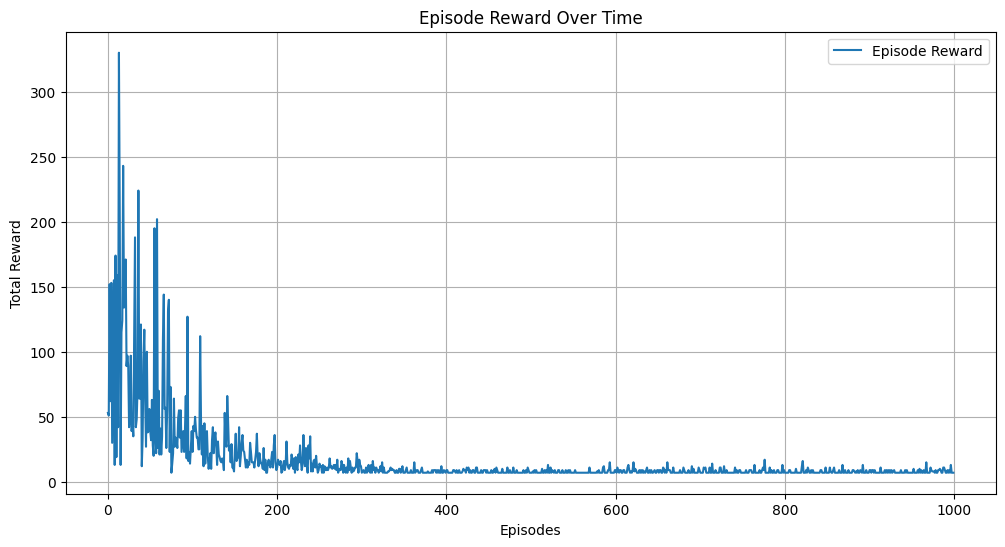

In [13]:
plot_rewards_counts(counts)

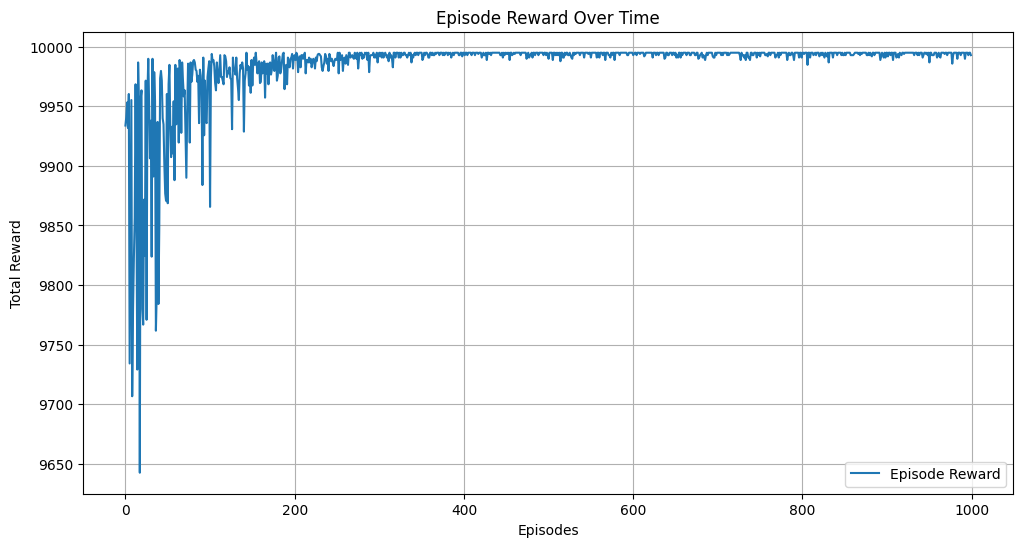

In [24]:

plot_rewards_counts(rewards)


In [16]:
pd.Series(rewards).to_csv('./logs/rewards_sarsa.csv')

# **Q-LEARNING**

In [17]:
rewards = []
counts = []
successes = 0

for ep in range(1000):
    done = False
    obs,info = env.reset()
    cnt = 0
    action = agent_QLearning.act(obs)

    ep_rewards = 0
    while not done:
        new_reward = 0
        next_obs, reward, done, truncated, info = env.step(action)

        next_action = agent_QLearning.act(next_obs)

        if reward == 0:
          new_reward = -1
        else:
          new_reward = reward + 10000

        if new_reward != -1:
          print("reward",new_reward)

        agent_QLearning.update(obs, action, new_reward, next_obs, next_action)

        ep_rewards += new_reward
        obs = next_obs
        action = next_action

        if done and reward > 0:
          successes += 1
        cnt += 1

    print(ep, ep_rewards)
    rewards.append(ep_rewards)
    counts.append(cnt)
    if (ep+1) % 20 == 0:
        print("episode: {}, rewards: {}, epsilon: {}".format(ep+1, ep_rewards, agent_QLearning.epsilon))
        agent_QLearning.decent_epsilon()
env.close()

Moviepy - Building video /content/video/rl-video-episode-1000.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1000.mp4
reward 9999.794
0 9933.794
Moviepy - Building video /content/video/rl-video-episode-1001.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1001.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1001.mp4
reward 9999.92
1 9940.92
Moviepy - Building video /content/video/rl-video-episode-1002.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1002.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1002.mp4
reward 10000.136
2 9953.136
Moviepy - Building video /content/video/rl-video-episode-1003.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1003.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1003.mp4
reward 9999.758
3 9931.758
Moviepy - Building video /content/video/rl-video-episode-1004.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1004.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1004.mp4
reward 10000.262
4 9960.262
Moviepy - Building video /content/video/rl-video-episode-1005.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1005.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1005.mp4
reward 9996.266
5 9734.266
Moviepy - Building video /content/video/rl-video-episode-1006.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1006.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1006.mp4
reward 9998.246
6 9846.246


Moviepy - Building video /content/video/rl-video-episode-1007.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1007.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1007.mp4
reward 10000.172
7 9955.172
Moviepy - Building video /content/video/rl-video-episode-1008.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1008.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1008.mp4
reward 9995.78
8 9706.78
Moviepy - Building video /content/video/rl-video-episode-1009.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1009.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1009.mp4
reward 9997.058
9 9779.058


Moviepy - Building video /content/video/rl-video-episode-1010.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1010.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1010.mp4
reward 9997.832
10 9822.832


Moviepy - Building video /content/video/rl-video-episode-1011.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1011.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1011.mp4
reward 9998.426
11 9856.426


Moviepy - Building video /content/video/rl-video-episode-1012.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1012.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1012.mp4
reward 10000.406
12 9968.406
Moviepy - Building video /content/video/rl-video-episode-1013.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1013.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1013.mp4
reward 9998.57
13 9864.57
Moviepy - Building video /content/video/rl-video-episode-1014.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1014.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1014.mp4
reward 9996.176
14 9729.176
Moviepy - Building video /content/video/rl-video-episode-1015.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1015.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1015.mp4
reward 10000.73
15 9986.73
Moviepy - Building video /content/video/rl-video-episode-1016.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1016.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1016.mp4
reward 10000.082
16 9950.082
Moviepy - Building video /content/video/rl-video-episode-1017.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1017.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1017.mp4
reward 9994.646
17 9642.646
Moviepy - Building video /content/video/rl-video-episode-1018.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1018.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1018.mp4
reward 10000.19
18 9956.19
Moviepy - Building video /content/video/rl-video-episode-1019.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1019.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1019.mp4
reward 10000.316
19 9963.316
episode: 20, rewards: 9963.316, epsilon: 1.0
Moviepy - Building video /content/video/rl-video-episode-1020.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1020.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1020.mp4
reward 9997.076
20 9780.076
Moviepy - Building video /content/video/rl-video-episode-1021.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1021.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1021.mp4
reward

 9996.842
21 9766.842
Moviepy - Building video /content/video/rl-video-episode-1022.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1022.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1022.mp4
reward 9998.696
22 9871.696


Moviepy - Building video /content/video/rl-video-episode-1023.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1023.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1023.mp4
reward 9997.868
23 9824.868
Moviepy - Building video /content/video/rl-video-episode-1024.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1024.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1024.mp4
reward 10000.46
24 9971.46
Moviepy - Building video /content/video/rl-video-episode-1025.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1025.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1025.mp4
reward 9996.914
25 9770.914
Moviepy - Building video /content/video/rl-video-episode-1026.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1026.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1026.mp4
reward 10000.262
26 9960.262
Moviepy - Building video /content/video/rl-video-episode-1027.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1027.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1027.mp4
reward 10000.784
27 9989.784
Moviepy - Building video /content/video/rl-video-episode-1028.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1028.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1028.mp4
reward 10000.118
28 9952.118
Moviepy - Building video /content/video/rl-video-episode-1029.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1029.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1029.mp4
reward 9999.308
29 9906.308
Moviepy - Building video /content/video/rl-video-episode-1030.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1030.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1030.mp4
reward 9999.866
30 9937.866
Moviepy - Building video /content/video/rl-video-episode-1031.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1031.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1031.mp4
reward 9997.85
31 9823.85
Moviepy - Building video /content/video/rl-video-episode-1032.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1032.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1032.mp4
reward 10000.784
32 9989.784


Moviepy - Building video /content/video/rl-video-episode-1033.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1033.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1033.mp4
reward 9999.038
33 9891.038
Moviepy - Building video /content/video/rl-video-episode-1034.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1034.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1034.mp4
reward 10000.586
34 9978.586


Moviepy - Building video /content/video/rl-video-episode-1035.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1035.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1035.mp4
reward 10000.154
35 9954.154


Moviepy - Building video /content/video/rl-video-episode-1036.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1036.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1036.mp4
reward 9996.752
36 9761.752


Moviepy - Building video /content/video/rl-video-episode-1037.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1037.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1037.mp4
reward 9997.31
37 9793.31


Moviepy - Building video /content/video/rl-video-episode-1038.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1038.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1038.mp4
reward 9999.848
38 9936.848
Moviepy - Building video /content/video/rl-video-episode-1039.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1039.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1039.mp4
reward 9997.148
39 9784.148
episode: 40, rewards: 9784.148, epsilon: 0.95
Moviepy - Building video /content/video/rl-video-episode-1040.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1040.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1040.mp4
reward 9998.282
40 9848.282


Moviepy - Building video /content/video/rl-video-episode-1041.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1041.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1041.mp4
reward 10000.496
41 9973.496
Moviepy - Building video /content/video/rl-video-episode-1042.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1042.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1042.mp4
reward 10000.604
42 9979.604
Moviepy - Building video /content/video/rl-video-episode-1043.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1043.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1043.mp4
reward 10000.46
43 9971.46
Moviepy - Building video /content/video/rl-video-episode-1044.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1044.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1044.mp4
reward 9999.902
44 9939.902
Moviepy - Building video /content/video/rl-video-episode-1045.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1045.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1045.mp4
reward 9999.812
45 9934.812
Moviepy - Building video /content/video/rl-video-episode-1046.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1046.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1046.mp4
reward 9999.218
46 9901.218
Moviepy - Building video /content/video/rl-video-episode-1047.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1047.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1047.mp4


reward 9998.786
47 9876.786
Moviepy - Building video /content/video/rl-video-episode-1048.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1048.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1048.mp4
reward 9998.678
48 9870.678
Moviepy - Building video /content/video/rl-video-episode-1049.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1049.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1049.mp4
reward 10000.262
49 9960.262
Moviepy - Building video /content/video/rl-video-episode-1050.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1050.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1050.mp4
reward 9998.642
50 9868.642
Moviepy - Building video /content/video/rl-video-episode-1051.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1051.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1051.mp4
reward 10000.406
51 9968.406
Moviepy - Building video /content/video/rl-video-episode-1052.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1052.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1052.mp4
reward 10000.694
52 9984.694


Moviepy - Building video /content/video/rl-video-episode-1053.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1053.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1053.mp4
reward 9999.794
53 9933.794
Moviepy - Building video /content/video/rl-video-episode-1054.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1054.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1054.mp4
reward 9999.326
54 9907.326
Moviepy - Building video /content/video/rl-video-episode-1055.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1055.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1055.mp4
reward 9999.776
55 9932.776
Moviepy - Building video /content/video/rl-video-episode-1056.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1056.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1056.mp4
reward 9999.38
56 9910.38
Moviepy - Building video /content/video/rl-video-episode-1057.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1057.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1057.mp4
reward 10000.154
57 9954.154
Moviepy - Building video /content/video/rl-video-episode-1058.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1058.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1058.mp4
reward 9998.984
58 9887.984
Moviepy - Building video /content/video/rl-video-episode-1059.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1059.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1059.mp4
reward 10000.694
59 9984.694
episode: 60, rewards: 9984.694, epsilon: 0.8999999999999999
Moviepy - Building video /content/video/rl-video-episode-1060.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1060.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1060.mp4
reward 9999.812
60 9934.812
Moviepy - Building video /content/video/rl-video-episode-1061.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1061.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1061.mp4
reward 9999.902
61 9939.902
Moviepy - Building video /content/video/rl-video-episode-1062.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1062.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1062.mp4
reward 10000.64
62 9981.64


Moviepy - Building video /content/video/rl-video-episode-1063.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1063.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1063.mp4
reward 9999.542
63 9919.542
Moviepy - Building video /content/video/rl-video-episode-1064.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1064.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1064.mp4
reward 10000.766
64 9988.766
Moviepy - Building video /content/video/rl-video-episode-1065.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1065.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1065.mp4
reward 10000.532
65 9975.532
Moviepy - Building video /content/video/rl-video-episode-1066.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1066.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1066.mp4
reward 9999.686
66 9927.686
Moviepy - Building video /content/video/rl-video-episode-1067.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1067.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1067.mp4
reward 10000.73
67 9986.73


Moviepy - Building video /content/video/rl-video-episode-1068.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1068.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1068.mp4
reward 10000.46
68 9971.46
Moviepy - Building video /content/video/rl-video-episode-1069.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1069.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1069.mp4
reward 10000.226
69 9958.226
Moviepy - Building video /content/video/rl-video-episode-1070.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1070.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1070.mp4
reward 10000.316
70 9963.316
Moviepy - Building video /content/video/rl-video-episode-1071.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1071.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1071.mp4
reward 9999.686
71 9927.686
Moviepy - Building video /content/video/rl-video-episode-1072.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1072.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1072.mp4
reward 9999.02
72 9890.02
Moviepy - Building video /content/video/rl-video-episode-1073.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1073.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1073.mp4
reward 9999.992
73 9944.992
Moviepy - Building video /content/video/rl-video-episode-1074.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1074.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1074.mp4
reward 10000.712
74 9985.712


Moviepy - Building video /content/video/rl-video-episode-1075.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1075.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1075.mp4
reward 10000.442
75 9970.442


Moviepy - Building video /content/video/rl-video-episode-1076.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1076.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1076.mp4
reward 9999.542
76 9919.542
Moviepy - Building video /content/video/rl-video-episode-1077.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1077.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1077.mp4
reward 10000.73
77 9986.73


Moviepy - Building video /content/video/rl-video-episode-1078.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1078.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1078.mp4
reward 10000.442
78 9970.442


Moviepy - Building video /content/video/rl-video-episode-1079.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1079.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1079.mp4
reward 10000.55
79 9976.55
episode: 80, rewards: 9976.55, epsilon: 0.8499999999999999
Moviepy - Building video /content/video/rl-video-episode-1080.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1080.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1080.mp4
reward 10000.748
80 9987.748
Moviepy - Building video /content/video/rl-video-episode-1081.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1081.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1081.mp4
reward 10000.766
81 9988.766


Moviepy - Building video /content/video/rl-video-episode-1082.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1082.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1082.mp4
reward 10000.73
82 9986.73
Moviepy - Building video /content/video/rl-video-episode-1083.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1083.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1083.mp4
reward 10000.622
83 9980.622
Moviepy - Building video /content/video/rl-video-episode-1084.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1084.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1084.mp4
reward 10000.604
84 9979.604
Moviepy - Building video /content/video/rl-video-episode-1085.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1085.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1085.mp4
reward 10000.442
85 9970.442
Moviepy - Building video /content/video/rl-video-episode-1086.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1086.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1086.mp4
reward 10000.532
86 9975.532


Moviepy - Building video /content/video/rl-video-episode-1087.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1087.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1087.mp4
reward 9999.83
87 9935.83
Moviepy - Building video /content/video/rl-video-episode-1088.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1088.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1088.mp4
reward 10000.622
88 9980.622


Moviepy - Building video /content/video/rl-video-episode-1089.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1089.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1089.mp4
reward 10000.532
89 9975.532


Moviepy - Building video /content/video/rl-video-episode-1090.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1090.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1090.mp4
reward 10000.28
90 9961.28
Moviepy - Building video /content/video/rl-video-episode-1091.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1091.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1091.mp4
reward 9998.912
91 9883.912
Moviepy - Building video /content/video/rl-video-episode-1092.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1092.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1092.mp4
reward 10000.802
92 9990.802


Moviepy - Building video /content/video/rl-video-episode-1093.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1093.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1093.mp4
reward 9999.65
93 9925.65
Moviepy - Building video /content/video/rl-video-episode-1094.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1094.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1094.mp4
reward 10000.46
94 9971.46
Moviepy - Building video /content/video/rl-video-episode-1095.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1095.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1095.mp4
reward 9999.848
95 9936.848
Moviepy - Building video /content/video/rl-video-episode-1096.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1096.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1096.mp4
reward 9999.83
96 9935.83
Moviepy - Building video /content/video/rl-video-episode-1097.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1097.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1097.mp4
reward 10000.514
97 9974.514
Moviepy - Building video /content/video/rl-video-episode-1098.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1098.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1098.mp4
reward 10000.64
98 9981.64
Moviepy - Building video /content/video/rl-video-episode-1099.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1099.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1099.mp4
reward 10000.748
99 9987.748
episode: 100, rewards: 9987.748, epsilon: 0.7999999999999998
Moviepy - Building video /content/video/rl-video-episode-1100.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1100.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1100.mp4
reward 9998.588
100 9865.588
Moviepy - Building video /content/video/rl-video-episode-1101.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1101.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1101.mp4
reward 10000.514
101 9974.514
Moviepy - Building video /content/video/rl-video-episode-1102.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1102.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1102.mp4
reward 10000.856
102 9993.856


Moviepy - Building video /content/video/rl-video-episode-1103.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1103.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1103.mp4
reward 10000.748
103 9987.748


Moviepy - Building video /content/video/rl-video-episode-1104.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1104.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1104.mp4
reward 10000.766
104 9988.766


Moviepy - Building video /content/video/rl-video-episode-1105.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1105.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1105.mp4
reward 10000.676
105 9983.676
Moviepy - Building video /content/video/rl-video-episode-1106.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1106.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1106.mp4
reward 10000.424
106 9969.424
Moviepy - Building video /content/video/rl-video-episode-1107.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1107.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1107.mp4
reward 10000.316
107 9963.316
Moviepy - Building video /content/video/rl-video-episode-1108.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1108.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1108.mp4
reward 10000.73
108 9986.73
Moviepy - Building video /content/video/rl-video-episode-1109.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1109.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1109.mp4
reward 10000.532
109 9975.532
Moviepy - Building video /content/video/rl-video-episode-1110.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1110.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1110.mp4
reward 10000.424
110 9969.424
Moviepy - Building video /content/video/rl-video-episode-1111.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1111.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1111.mp4
reward 10000.622
111 9980.622


Moviepy - Building video /content/video/rl-video-episode-1112.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1112.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1112.mp4


reward 10000.838
112 9992.838
Moviepy - Building video /content/video/rl-video-episode-1113.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1113.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1113.mp4
reward 10000.514
113 9974.514
Moviepy - Building video /content/video/rl-video-episode-1114.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1114.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1114.mp4
reward 10000.514
114 9974.514
Moviepy - Building video /content/video/rl-video-episode-1115.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1115.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1115.mp4
reward 10000.46
115 9971.46
Moviepy - Building video /content/video/rl-video-episode-1116.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1116.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1116.mp4
reward 10000.406
116 9968.406
Moviepy - Building video /content/video/rl-video-episode-1117.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1117.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1117.mp4
reward 10000.838
117 9992.838
Moviepy - Building video /content/video/rl-video-episode-1118.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1118.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1118.mp4
reward 10000.82
118 9991.82
Moviepy - Building video /content/video/rl-video-episode-1119.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1119.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1119.mp4
reward 10000.748
119 9987.748
episode: 120, rewards: 9987.748, epsilon: 0.7499999999999998
Moviepy - Building video /content/video/rl-video-episode-1120.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1120.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1120.mp4
reward 10000.514
120 9974.514
Moviepy - Building video /content/video/rl-video-episode-1121.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1121.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1121.mp4
reward 10000.604
121 9979.604
Moviepy - Building video /content/video/rl-video-episode-1122.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1122.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1122.mp4
reward 10000.568
122 9977.568
Moviepy - Building video /content/video/rl-video-episode-1123.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1123.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1123.mp4
reward 10000.658
123 9982.658
Moviepy - Building video /content/video/rl-video-episode-1124.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1124.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1124.mp4
reward 10000.496
124 9973.496
Moviepy - Building video /content/video/rl-video-episode-1125.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1125.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1125.mp4
reward 10000.478
125 9972.478
Moviepy - Building video /content/video/rl-video-episode-1126.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1126.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1126.mp4
reward 9999.74
126 9930.74


Moviepy - Building video /content/video/rl-video-episode-1127.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1127.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1127.mp4
reward 10000.802
127 9990.802
Moviepy - Building video /content/video/rl-video-episode-1128.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1128.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1128.mp4
reward 10000.64
128 9981.64


Moviepy - Building video /content/video/rl-video-episode-1129.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1129.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1129.mp4
reward 10000.622
129 9980.622
Moviepy - Building video /content/video/rl-video-episode-1130.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1130.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1130.mp4
reward 10000.55
130 9976.55
Moviepy - Building video /content/video/rl-video-episode-1131.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1131.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1131.mp4
reward 10000.802
131 9990.802
Moviepy - Building video /content/video/rl-video-episode-1132.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1132.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1132.mp4
reward 10000.496
132 9973.496
Moviepy - Building video /content/video/rl-video-episode-1133.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1133.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1133.mp4
reward 10000.352
133 9965.352
Moviepy - Building video /content/video/rl-video-episode-1134.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1134.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1134.mp4
reward 10000.172
134 9955.172
Moviepy - Building video /content/video/rl-video-episode-1135.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1135.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1135.mp4
reward 10000.568
135 9977.568
Moviepy - Building video /content/video/rl-video-episode-1136.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1136.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1136.mp4
reward 10000.694
136 9984.694
Moviepy - Building video /content/video/rl-video-episode-1137.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1137.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1137.mp4
reward 10000.64
137 9981.64
Moviepy - Building video /content/video/rl-video-episode-1138.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1138.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1138.mp4
reward 10000.73
138 9986.73
Moviepy - Building video /content/video/rl-video-episode-1139.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1139.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1139.mp4
reward 10000.64
139 9981.64
episode: 140, rewards: 9981.64, epsilon: 0.6999999999999997
Moviepy - Building video /content/video/rl-video-episode-1140.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1140.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1140.mp4
reward 9999.704
140 9928.704
Moviepy - Building video /content/video/rl-video-episode-1141.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1141.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1141.mp4
reward 10000.46
141 9971.46
Moviepy - Building video /content/video/rl-video-episode-1142.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1142.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1142.mp4
reward 10000.568
142 9977.568
Moviepy - Building video /content/video/rl-video-episode-1143.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1143.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1143.mp4
reward 10000.874
143 9994.874
Moviepy - Building video /content/video/rl-video-episode-1144.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1144.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1144.mp4
reward 10000.622
144 9980.622
Moviepy - Building video /content/video/rl-video-episode-1145.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1145.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1145.mp4
reward 10000.676
145 9983.676
Moviepy - Building video /content/video/rl-video-episode-1146.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1146.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1146.mp4
reward 10000.388
146 9967.388
Moviepy - Building video /content/video/rl-video-episode-1147.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1147.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1147.mp4
reward 10000.658
147 9982.658


Moviepy - Building video /content/video/rl-video-episode-1148.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1148.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1148.mp4
reward 10000.28
148 9961.28
Moviepy - Building video /content/video/rl-video-episode-1149.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1149.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1149.mp4
reward 10000.766
149 9988.766
Moviepy - Building video /content/video/rl-video-episode-1150.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1150.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1150.mp4
reward 10000.388
150 9967.388
Moviepy - Building video /content/video/rl-video-episode-1151.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1151.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1151.mp4
reward 10000.73
151 9986.73
Moviepy - Building video /content/video/rl-video-episode-1152.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1152.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1152.mp4
reward 10000.802
152 9990.802
Moviepy - Building video /content/video/rl-video-episode-1153.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1153.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1153.mp4
reward 10000.694
153 9984.694


Moviepy - Building video /content/video/rl-video-episode-1154.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1154.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1154.mp4
reward 10000.874
154 9994.874
Moviepy - Building video /content/video/rl-video-episode-1155.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1155.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1155.mp4
reward 10000.712
155 9985.712
Moviepy - Building video /content/video/rl-video-episode-1156.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1156.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1156.mp4
reward 10000.568
156 9977.568
Moviepy - Building video /content/video/rl-video-episode-1157.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1157.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1157.mp4
reward 10000.712
157 9985.712
Moviepy - Building video /content/video/rl-video-episode-1158.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1158.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1158.mp4
reward 10000.748
158 9987.748
Moviepy - Building video /content/video/rl-video-episode-1159.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1159.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1159.mp4
reward 10000.424
159 9969.424
episode: 160, rewards: 9969.424, epsilon: 0.6499999999999997
Moviepy - Building video /content/video/rl-video-episode-1160.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1160.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1160.mp4


reward 10000.442
160 9970.442
Moviepy - Building video /content/video/rl-video-episode-1161.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1161.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1161.mp4
reward 10000.73
161 9986.73


Moviepy - Building video /content/video/rl-video-episode-1162.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1162.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1162.mp4
reward 10000.568
162 9977.568
Moviepy - Building video /content/video/rl-video-episode-1163.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1163.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1163.mp4
reward 10000.694
163 9984.694
Moviepy - Building video /content/video/rl-video-episode-1164.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1164.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1164.mp4
reward 10000.748
164 9987.748
Moviepy - Building video /content/video/rl-video-episode-1165.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1165.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1165.mp4
reward 10000.208
165 9957.208
Moviepy - Building video /content/video/rl-video-episode-1166.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1166.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1166.mp4
reward 10000.712
166 9985.712
Moviepy - Building video /content/video/rl-video-episode-1167.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1167.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1167.mp4
reward 10000.568
167 9977.568
Moviepy - Building video /content/video/rl-video-episode-1168.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1168.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1168.mp4
reward 10000.712
168 9985.712
Moviepy - Building video /content/video/rl-video-episode-1169.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1169.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1169.mp4
reward 10000.406
169 9968.406
Moviepy - Building video /content/video/rl-video-episode-1170.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1170.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1170.mp4
reward 10000.712
170 9985.712


Moviepy - Building video /content/video/rl-video-episode-1171.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1171.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1171.mp4
reward 10000.73
171 9986.73
Moviepy - Building video /content/video/rl-video-episode-1172.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1172.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1172.mp4
reward 10000.55
172 9976.55
Moviepy - Building video /content/video/rl-video-episode-1173.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1173.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1173.mp4
reward 10000.622
173 9980.622
Moviepy - Building video /content/video/rl-video-episode-1174.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1174.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1174.mp4
reward 10000.838
174 9992.838
Moviepy - Building video /content/video/rl-video-episode-1175.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1175.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1175.mp4
reward 10000.694
175 9984.694


Moviepy - Building video /content/video/rl-video-episode-1176.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1176.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1176.mp4
reward 10000.604
176 9979.604
Moviepy - Building video /content/video/rl-video-episode-1177.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1177.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1177.mp4
reward 10000.766
177 9988.766
Moviepy - Building video /content/video/rl-video-episode-1178.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1178.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1178.mp4
reward 10000.874
178 9994.874


Moviepy - Building video /content/video/rl-video-episode-1179.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1179.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1179.mp4
reward 10000.46
179 9971.46
episode: 180, rewards: 9971.46, epsilon: 0.5999999999999996
Moviepy - Building video /content/video/rl-video-episode-1180.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1180.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1180.mp4
reward 10000.532
180 9975.532
Moviepy - Building video /content/video/rl-video-episode-1181.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1181.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1181.mp4
reward 10000.802
181 9990.802
Moviepy - Building video /content/video/rl-video-episode-1182.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1182.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1182.mp4
reward 10000.82
182 9991.82
Moviepy - Building video /content/video/rl-video-episode-1183.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1183.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1183.mp4
reward 10000.568
183 9977.568


Moviepy - Building video /content/video/rl-video-episode-1184.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1184.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1184.mp4
reward 10000.622
184 9980.622
Moviepy - Building video /content/video/rl-video-episode-1185.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1185.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1185.mp4
reward 10000.748
185 9987.748
Moviepy - Building video /content/video/rl-video-episode-1186.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1186.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1186.mp4
reward 10000.856
186 9993.856
Moviepy - Building video /content/video/rl-video-episode-1187.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1187.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1187.mp4
reward 10000.874
187 9994.874
Moviepy - Building video /content/video/rl-video-episode-1188.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1188.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1188.mp4
reward 10000.334
188 9964.334
Moviepy - Building video /content/video/rl-video-episode-1189.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1189.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1189.mp4
reward 10000.64
189 9981.64
Moviepy - Building video /content/video/rl-video-episode-1190.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1190.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1190.mp4
reward 10000.694
190 9984.694
Moviepy - Building video /content/video/rl-video-episode-1191.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1191.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1191.mp4
reward 10000.406
191 9968.406
Moviepy - Building video /content/video/rl-video-episode-1192.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1192.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1192.mp4
reward 10000.802
192 9990.802
Moviepy - Building video /content/video/rl-video-episode-1193.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1193.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1193.mp4
reward 10000.712
193 9985.712
Moviepy - Building video /content/video/rl-video-episode-1194.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1194.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1194.mp4
reward 10000.658
194 9982.658
Moviepy - Building video /content/video/rl-video-episode-1195.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1195.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1195.mp4
reward 10000.784
195 9989.784
Moviepy - Building video /content/video/rl-video-episode-1196.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1196.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1196.mp4
reward 10000.802
196 9990.802


Moviepy - Building video /content/video/rl-video-episode-1197.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1197.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1197.mp4
reward 10000.856
197 9993.856
Moviepy - Building video /content/video/rl-video-episode-1198.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1198.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1198.mp4
reward 10000.64
198 9981.64
Moviepy - Building video /content/video/rl-video-episode-1199.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1199.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1199.mp4
reward 10000.82
199 9991.82
episode: 200, rewards: 9991.82, epsilon: 0.5499999999999996
Moviepy - Building video /content/video/rl-video-episode-1200.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1200.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1200.mp4
reward 10000.838
200 9992.838
Moviepy - Building video /content/video/rl-video-episode-1201.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1201.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1201.mp4
reward 10000.766
201 9988.766
Moviepy - Building video /content/video/rl-video-episode-1202.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1202.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1202.mp4
reward 10000.874
202 9994.874
Moviepy - Building video /content/video/rl-video-episode-1203.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1203.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1203.mp4
reward 10000.838
203 9992.838


Moviepy - Building video /content/video/rl-video-episode-1204.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1204.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1204.mp4
reward 10000.586
204 9978.586
Moviepy - Building video /content/video/rl-video-episode-1205.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1205.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1205.mp4
reward 10000.748
205 9987.748
Moviepy - Building video /content/video/rl-video-episode-1206.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1206.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1206.mp4
reward 10000.82
206 9991.82


Moviepy - Building video /content/video/rl-video-episode-1207.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1207.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1207.mp4
reward 10000.658
207 9982.658


Moviepy - Building video /content/video/rl-video-episode-1208.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1208.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1208.mp4
reward 10000.838
208 9992.838


Moviepy - Building video /content/video/rl-video-episode-1209.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1209.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1209.mp4
reward 10000.838
209 9992.838
Moviepy - Building video /content/video/rl-video-episode-1210.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1210.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1210.mp4
reward 10000.784
210 9989.784
Moviepy - Building video /content/video/rl-video-episode-1211.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1211.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1211.mp4
reward 10000.838
211 9992.838
Moviepy - Building video /content/video/rl-video-episode-1212.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1212.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1212.mp4
reward 10000.874
212 9994.874
Moviepy - Building video /content/video/rl-video-episode-1213.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1213.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1213.mp4
reward 10000.568
213 9977.568
Moviepy - Building video /content/video/rl-video-episode-1214.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1214.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1214.mp4
reward 10000.766
214 9988.766
Moviepy - Building video /content/video/rl-video-episode-1215.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1215.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1215.mp4
reward 10000.766
215 9988.766
Moviepy - Building video /content/video/rl-video-episode-1216.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1216.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1216.mp4
reward 10000.73
216 9986.73
Moviepy - Building video /content/video/rl-video-episode-1217.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1217.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1217.mp4
reward 10000.802
217 9990.802


Moviepy - Building video /content/video/rl-video-episode-1218.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1218.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1218.mp4
reward 10000.73
218 9986.73
Moviepy - Building video /content/video/rl-video-episode-1219.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1219.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1219.mp4
reward 10000.784
219 9989.784
episode: 220, rewards: 9989.784, epsilon: 0.4999999999999996


Moviepy - Building video /content/video/rl-video-episode-1220.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1220.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1220.mp4
reward 10000.658
220 9982.658
Moviepy - Building video /content/video/rl-video-episode-1221.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1221.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1221.mp4
reward 10000.73
221 9986.73
Moviepy - Building video /content/video/rl-video-episode-1222.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1222.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1222.mp4
reward 10000.784
222 9989.784


Moviepy - Building video /content/video/rl-video-episode-1223.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1223.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1223.mp4


reward 10000.766
223 9988.766
Moviepy - Building video /content/video/rl-video-episode-1224.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1224.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1224.mp4
reward 10000.64
224 9981.64
Moviepy - Building video /content/video/rl-video-episode-1225.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1225.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1225.mp4
reward 10000.802
225 9990.802
Moviepy - Building video /content/video/rl-video-episode-1226.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1226.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1226.mp4
reward 10000.748
226 9987.748
Moviepy - Building video /content/video/rl-video-episode-1227.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1227.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1227.mp4
reward 10000.838
227 9992.838
Moviepy - Building video /content/video/rl-video-episode-1228.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1228.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1228.mp4
reward 10000.856
228 9993.856
Moviepy - Building video /content/video/rl-video-episode-1229.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1229.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1229.mp4
reward 10000.856
229 9993.856
Moviepy - Building video /content/video/rl-video-episode-1230.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1230.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1230.mp4
reward 10000.838
230 9992.838
Moviepy - Building video /content/video/rl-video-episode-1231.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1231.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1231.mp4
reward 10000.82
231 9991.82
Moviepy - Building video /content/video/rl-video-episode-1232.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1232.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1232.mp4
reward 10000.658
232 9982.658
Moviepy - Building video /content/video/rl-video-episode-1233.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1233.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1233.mp4
reward 10000.604
233 9979.604
Moviepy - Building video /content/video/rl-video-episode-1234.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1234.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1234.mp4
reward 10000.676
234 9983.676
Moviepy - Building video /content/video/rl-video-episode-1235.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1235.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1235.mp4
reward 10000.73
235 9986.73
Moviepy - Building video /content/video/rl-video-episode-1236.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1236.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1236.mp4
reward 10000.856
236 9993.856


Moviepy - Building video /content/video/rl-video-episode-1237.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1237.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1237.mp4
reward 10000.82
237 9991.82


Moviepy - Building video /content/video/rl-video-episode-1238.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1238.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1238.mp4
reward 10000.712
238 9985.712
Moviepy - Building video /content/video/rl-video-episode-1239.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1239.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1239.mp4
reward 10000.784
239 9989.784
episode: 240, rewards: 9989.784, epsilon: 0.4499999999999996
Moviepy - Building video /content/video/rl-video-episode-1240.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1240.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1240.mp4
reward 10000.604
240 9979.604
Moviepy - Building video /content/video/rl-video-episode-1241.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1241.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1241.mp4
reward 10000.856
241 9993.856


Moviepy - Building video /content/video/rl-video-episode-1242.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1242.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1242.mp4
reward 10000.802
242 9990.802


Moviepy - Building video /content/video/rl-video-episode-1243.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1243.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1243.mp4
reward 10000.748
243 9987.748
Moviepy - Building video /content/video/rl-video-episode-1244.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1244.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1244.mp4
reward 10000.784
244 9989.784
Moviepy - Building video /content/video/rl-video-episode-1245.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1245.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1245.mp4
reward 10000.73
245 9986.73


Moviepy - Building video /content/video/rl-video-episode-1246.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1246.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1246.mp4
reward 10000.676
246 9983.676
Moviepy - Building video /content/video/rl-video-episode-1247.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1247.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1247.mp4
reward 10000.748
247 9987.748
Moviepy - Building video /content/video/rl-video-episode-1248.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1248.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1248.mp4
reward 10000.784
248 9989.784


Moviepy - Building video /content/video/rl-video-episode-1249.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1249.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1249.mp4
reward 10000.766
249 9988.766
Moviepy - Building video /content/video/rl-video-episode-1250.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1250.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1250.mp4
reward 10000.784
250 9989.784
Moviepy - Building video /content/video/rl-video-episode-1251.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1251.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1251.mp4
reward 10000.874
251 9994.874
Moviepy - Building video /content/video/rl-video-episode-1252.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1252.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1252.mp4
reward 10000.568
252 9977.568
Moviepy - Building video /content/video/rl-video-episode-1253.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1253.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1253.mp4
reward 10000.874
253 9994.874


Moviepy - Building video /content/video/rl-video-episode-1254.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1254.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1254.mp4
reward 10000.766
254 9988.766


Moviepy - Building video /content/video/rl-video-episode-1255.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1255.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1255.mp4
reward 10000.802
255 9990.802


Moviepy - Building video /content/video/rl-video-episode-1256.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1256.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1256.mp4
reward 10000.838
256 9992.838


Moviepy - Building video /content/video/rl-video-episode-1257.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1257.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1257.mp4
reward 10000.604
257 9979.604
Moviepy - Building video /content/video/rl-video-episode-1258.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1258.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1258.mp4
reward 10000.784
258 9989.784
Moviepy - Building video /content/video/rl-video-episode-1259.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1259.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1259.mp4
reward 10000.802
259 9990.802
episode: 260, rewards: 9990.802, epsilon: 0.39999999999999963
Moviepy - Building video /content/video/rl-video-episode-1260.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1260.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1260.mp4
reward 10000.712
260 9985.712
Moviepy - Building video /content/video/rl-video-episode-1261.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1261.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1261.mp4
reward 10000.838
261 9992.838


Moviepy - Building video /content/video/rl-video-episode-1262.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1262.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1262.mp4
reward 10000.766
262 9988.766
Moviepy - Building video /content/video/rl-video-episode-1263.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1263.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1263.mp4
reward 10000.694
263 9984.694
Moviepy - Building video /content/video/rl-video-episode-1264.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1264.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1264.mp4
reward 10000.874
264 9994.874
Moviepy - Building video /content/video/rl-video-episode-1265.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1265.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1265.mp4
reward 10000.874
265 9994.874
Moviepy - Building video /content/video/rl-video-episode-1266.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1266.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1266.mp4
reward 10000.802
266 9990.802
Moviepy - Building video /content/video/rl-video-episode-1267.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1267.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1267.mp4
reward 10000.82
267 9991.82
Moviepy - Building video /content/video/rl-video-episode-1268.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1268.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1268.mp4
reward 10000.838
268 9992.838
Moviepy - Building video /content/video/rl-video-episode-1269.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1269.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1269.mp4
reward 10000.802
269 9990.802
Moviepy - Building video /content/video/rl-video-episode-1270.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1270.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1270.mp4
reward 10000.784
270 9989.784
Moviepy - Building video /content/video/rl-video-episode-1271.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1271.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1271.mp4
reward 10000.874
271 9994.874


Moviepy - Building video /content/video/rl-video-episode-1272.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1272.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1272.mp4
reward 10000.838
272 9992.838
Moviepy - Building video /content/video/rl-video-episode-1273.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1273.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1273.mp4
reward 10000.784
273 9989.784
Moviepy - Building video /content/video/rl-video-episode-1274.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1274.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1274.mp4
reward 10000.874
274 9994.874
Moviepy - Building video /content/video/rl-video-episode-1275.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1275.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1275.mp4
reward 10000.64
275 9981.64


Moviepy - Building video /content/video/rl-video-episode-1276.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1276.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1276.mp4
reward 10000.784
276 9989.784


Moviepy - Building video /content/video/rl-video-episode-1277.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1277.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1277.mp4
reward 10000.874
277 9994.874
Moviepy - Building video /content/video/rl-video-episode-1278.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1278.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1278.mp4
reward 10000.838
278 9992.838
Moviepy - Building video /content/video/rl-video-episode-1279.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1279.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1279.mp4


reward 10000.874
279 9994.874
episode: 280, rewards: 9994.874, epsilon: 0.34999999999999964
Moviepy - Building video /content/video/rl-video-episode-1280.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1280.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1280.mp4
reward 10000.784
280 9989.784
Moviepy - Building video /content/video/rl-video-episode-1281.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1281.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1281.mp4
reward 10000.838
281 9992.838
Moviepy - Building video /content/video/rl-video-episode-1282.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1282.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1282.mp4
reward 10000.802
282 9990.802
Moviepy - Building video /content/video/rl-video-episode-1283.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1283.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1283.mp4
reward 10000.874
283 9994.874
Moviepy - Building video /content/video/rl-video-episode-1284.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1284.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1284.mp4
reward 10000.856
284 9993.856
Moviepy - Building video /content/video/rl-video-episode-1285.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1285.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1285.mp4
reward 10000.874
285 9994.874
Moviepy - Building video /content/video/rl-video-episode-1286.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1286.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1286.mp4
reward 10000.766
286 9988.766
Moviepy - Building video /content/video/rl-video-episode-1287.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1287.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1287.mp4
reward 10000.874
287 9994.874
Moviepy - Building video /content/video/rl-video-episode-1288.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1288.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1288.mp4
reward 10000.586
288 9978.586
Moviepy - Building video /content/video/rl-video-episode-1289.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1289.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1289.mp4
reward 10000.82
289 9991.82


Moviepy - Building video /content/video/rl-video-episode-1290.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1290.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1290.mp4
reward 10000.838
290 9992.838


Moviepy - Building video /content/video/rl-video-episode-1291.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1291.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1291.mp4
reward 10000.838
291 9992.838
Moviepy - Building video /content/video/rl-video-episode-1292.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1292.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1292.mp4
reward 10000.838
292 9992.838
Moviepy - Building video /content/video/rl-video-episode-1293.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1293.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1293.mp4
reward 10000.874
293 9994.874
Moviepy - Building video /content/video/rl-video-episode-1294.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1294.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1294.mp4
reward 10000.802
294 9990.802
Moviepy - Building video /content/video/rl-video-episode-1295.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1295.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1295.mp4
reward 10000.838
295 9992.838
Moviepy - Building video /content/video/rl-video-episode-1296.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1296.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1296.mp4
reward 10000.802
296 9990.802
Moviepy - Building video /content/video/rl-video-episode-1297.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1297.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1297.mp4
reward 10000.874
297 9994.874
Moviepy - Building video /content/video/rl-video-episode-1298.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1298.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1298.mp4
reward 10000.73
298 9986.73
Moviepy - Building video /content/video/rl-video-episode-1299.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1299.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1299.mp4
reward 10000.856
299 9993.856
episode: 300, rewards: 9993.856, epsilon: 0.29999999999999966
Moviepy - Building video /content/video/rl-video-episode-1300.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1300.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1300.mp4
reward 10000.874
300 9994.874
Moviepy - Building video /content/video/rl-video-episode-1301.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1301.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1301.mp4
reward 10000.82
301 9991.82
Moviepy - Building video /content/video/rl-video-episode-1302.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1302.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1302.mp4
reward 10000.874
302 9994.874
Moviepy - Building video /content/video/rl-video-episode-1303.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1303.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1303.mp4
reward 10000.802
303 9990.802
Moviepy - Building video /content/video/rl-video-episode-1304.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1304.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1304.mp4
reward 10000.874
304 9994.874
Moviepy - Building video /content/video/rl-video-episode-1305.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1305.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1305.mp4
reward 10000.802
305 9990.802
Moviepy - Building video /content/video/rl-video-episode-1306.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1306.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1306.mp4
reward 10000.856
306 9993.856
Moviepy - Building video /content/video/rl-video-episode-1307.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1307.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1307.mp4
reward 10000.874
307 9994.874
Moviepy - Building video /content/video/rl-video-episode-1308.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1308.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1308.mp4
reward 10000.838
308 9992.838
Moviepy - Building video /content/video/rl-video-episode-1309.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1309.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1309.mp4
reward 10000.802
309 9990.802


Moviepy - Building video /content/video/rl-video-episode-1310.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1310.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1310.mp4
reward 10000.838
310 9992.838
Moviepy - Building video /content/video/rl-video-episode-1311.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1311.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1311.mp4
reward 10000.748
311 9987.748
Moviepy - Building video /content/video/rl-video-episode-1312.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1312.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1312.mp4
reward 10000.874
312 9994.874
Moviepy - Building video /content/video/rl-video-episode-1313.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1313.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1313.mp4
reward 10000.802
313 9990.802
Moviepy - Building video /content/video/rl-video-episode-1314.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1314.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1314.mp4
reward 10000.838
314 9992.838
Moviepy - Building video /content/video/rl-video-episode-1315.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1315.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1315.mp4
reward 10000.784
315 9989.784
Moviepy - Building video /content/video/rl-video-episode-1316.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1316.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1316.mp4


reward 10000.658
316 9982.658
Moviepy - Building video /content/video/rl-video-episode-1317.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1317.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1317.mp4
reward 10000.874
317 9994.874
Moviepy - Building video /content/video/rl-video-episode-1318.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1318.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1318.mp4
reward 10000.874
318 9994.874
Moviepy - Building video /content/video/rl-video-episode-1319.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1319.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1319.mp4
reward 10000.802
319 9990.802
episode: 320, rewards: 9990.802, epsilon: 0.24999999999999967
Moviepy - Building video /content/video/rl-video-episode-1320.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1320.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1320.mp4
reward 10000.874
320 9994.874
Moviepy - Building video /content/video/rl-video-episode-1321.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1321.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1321.mp4
reward 10000.874
321 9994.874
Moviepy - Building video /content/video/rl-video-episode-1322.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1322.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1322.mp4


reward 10000.874
322 9994.874
Moviepy - Building video /content/video/rl-video-episode-1323.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1323.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1323.mp4
reward 10000.802
323 9990.802
Moviepy - Building video /content/video/rl-video-episode-1324.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1324.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1324.mp4
reward 10000.874
324 9994.874
Moviepy - Building video /content/video/rl-video-episode-1325.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1325.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1325.mp4
reward 10000.802
325 9990.802
Moviepy - Building video /content/video/rl-video-episode-1326.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1326.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1326.mp4
reward 10000.874
326 9994.874
Moviepy - Building video /content/video/rl-video-episode-1327.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1327.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1327.mp4
reward 10000.838
327 9992.838
Moviepy - Building video /content/video/rl-video-episode-1328.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1328.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1328.mp4
reward 10000.838
328 9992.838
Moviepy - Building video /content/video/rl-video-episode-1329.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1329.mp4



Moviepy - Done !


Moviepy - video ready /content/video/rl-video-episode-1329.mp4
reward 10000.874
329 9994.874
Moviepy - Building video /content/video/rl-video-episode-1330.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1330.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1330.mp4
reward 10000.874
330 9994.874
Moviepy - Building video /content/video/rl-video-episode-1331.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1331.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1331.mp4
reward 10000.838
331 9992.838
Moviepy - Building video /content/video/rl-video-episode-1332.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1332.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1332.mp4
reward 10000.838
332 9992.838
Moviepy - Building video /content/video/rl-video-episode-1333.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1333.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1333.mp4
reward 10000.802
333 9990.802
Moviepy - Building video /content/video/rl-video-episode-1334.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1334.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1334.mp4
reward 10000.838
334 9992.838
Moviepy - Building video /content/video/rl-video-episode-1335.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1335.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1335.mp4
reward 10000.874
335 9994.874
Moviepy - Building video /content/video/rl-video-episode-1336.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1336.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1336.mp4
reward 10000.838
336 9992.838
Moviepy - Building video /content/video/rl-video-episode-1337.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1337.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1337.mp4
reward 10000.874
337 9994.874
Moviepy - Building video /content/video/rl-video-episode-1338.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1338.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1338.mp4
reward 10000.73
338 9986.73
Moviepy - Building video /content/video/rl-video-episode-1339.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1339.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1339.mp4
reward 10000.838
339 9992.838
episode: 340, rewards: 9992.838, epsilon: 0.19999999999999968
Moviepy - Building video /content/video/rl-video-episode-1340.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1340.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1340.mp4
reward 10000.802
340 9990.802
Moviepy - Building video /content/video/rl-video-episode-1341.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1341.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1341.mp4
reward 10000.856
341 9993.856
Moviepy - Building video /content/video/rl-video-episode-1342.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1342.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1342.mp4
reward 10000.874
342 9994.874
Moviepy - Building video /content/video/rl-video-episode-1343.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1343.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1343.mp4
reward 10000.838
343 9992.838
Moviepy - Building video /content/video/rl-video-episode-1344.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1344.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1344.mp4
reward 10000.874
344 9994.874
Moviepy - Building video /content/video/rl-video-episode-1345.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1345.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1345.mp4
reward 10000.874
345 9994.874
Moviepy - Building video /content/video/rl-video-episode-1346.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1346.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1346.mp4
reward 10000.838
346 9992.838
Moviepy - Building video /content/video/rl-video-episode-1347.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1347.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1347.mp4
reward 10000.874
347 9994.874
Moviepy - Building video /content/video/rl-video-episode-1348.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1348.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1348.mp4
reward 10000.874
348 9994.874
Moviepy - Building video /content/video/rl-video-episode-1349.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1349.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1349.mp4
reward 10000.874
349 9994.874
Moviepy - Building video /content/video/rl-video-episode-1350.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1350.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1350.mp4
reward 10000.874
350 9994.874


Moviepy - Building video /content/video/rl-video-episode-1351.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1351.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1351.mp4
reward 10000.766
351 9988.766
Moviepy - Building video /content/video/rl-video-episode-1352.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1352.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1352.mp4
reward 10000.802
352 9990.802
Moviepy - Building video /content/video/rl-video-episode-1353.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1353.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1353.mp4
reward 10000.874
353 9994.874
Moviepy - Building video /content/video/rl-video-episode-1354.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1354.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1354.mp4
reward 10000.838
354 9992.838
Moviepy - Building video /content/video/rl-video-episode-1355.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1355.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1355.mp4
reward 10000.874
355 9994.874
Moviepy - Building video /content/video/rl-video-episode-1356.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1356.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1356.mp4
reward 10000.874
356 9994.874
Moviepy - Building video /content/video/rl-video-episode-1357.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1357.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1357.mp4
reward 10000.856
357 9993.856


Moviepy - Building video /content/video/rl-video-episode-1358.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1358.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1358.mp4
reward 10000.802
358 9990.802
Moviepy - Building video /content/video/rl-video-episode-1359.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1359.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1359.mp4
reward 10000.802
359 9990.802
episode: 360, rewards: 9990.802, epsilon: 0.1499999999999997
Moviepy - Building video /content/video/rl-video-episode-1360.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1360.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1360.mp4
reward 10000.874
360 9994.874
Moviepy - Building video /content/video/rl-video-episode-1361.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1361.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1361.mp4
reward 10000.874
361 9994.874
Moviepy - Building video /content/video/rl-video-episode-1362.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1362.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1362.mp4
reward 10000.838
362 9992.838
Moviepy - Building video /content/video/rl-video-episode-1363.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1363.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1363.mp4
reward 10000.874
363 9994.874
Moviepy - Building video /content/video/rl-video-episode-1364.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1364.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1364.mp4
reward 10000.838
364 9992.838
Moviepy - Building video /content/video/rl-video-episode-1365.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1365.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1365.mp4
reward 10000.838
365 9992.838
Moviepy - Building video /content/video/rl-video-episode-1366.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1366.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1366.mp4
reward 10000.874
366 9994.874
Moviepy - Building video /content/video/rl-video-episode-1367.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1367.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1367.mp4
reward 10000.856
367 9993.856
Moviepy - Building video /content/video/rl-video-episode-1368.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1368.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1368.mp4
reward 10000.874
368 9994.874
Moviepy - Building video /content/video/rl-video-episode-1369.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1369.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1369.mp4
reward 10000.874
369 9994.874
Moviepy - Building video /content/video/rl-video-episode-1370.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1370.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1370.mp4
reward 10000.874
370 9994.874
Moviepy - Building video /content/video/rl-video-episode-1371.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1371.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1371.mp4
reward 10000.838
371 9992.838
Moviepy - Building video /content/video/rl-video-episode-1372.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1372.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1372.mp4
reward 10000.874
372 9994.874
Moviepy - Building video /content/video/rl-video-episode-1373.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1373.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1373.mp4
reward 10000.874
373 9994.874
Moviepy - Building video /content/video/rl-video-episode-1374.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1374.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1374.mp4
reward 10000.874
374 9994.874
Moviepy - Building video /content/video/rl-video-episode-1375.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1375.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1375.mp4
reward 10000.838
375 9992.838
Moviepy - Building video /content/video/rl-video-episode-1376.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1376.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1376.mp4
reward 10000.874
376 9994.874
Moviepy - Building video /content/video/rl-video-episode-1377.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1377.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1377.mp4
reward 10000.838
377 9992.838
Moviepy - Building video /content/video/rl-video-episode-1378.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1378.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1378.mp4
reward 10000.874
378 9994.874
Moviepy - Building video /content/video/rl-video-episode-1379.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1379.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1379.mp4
reward 10000.874
379 9994.874
episode: 380, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1380.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1380.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1380.mp4
reward 10000.874
380 9994.874
Moviepy - Building video /content/video/rl-video-episode-1381.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1381.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1381.mp4
reward 10000.838
381 9992.838
Moviepy - Building video /content/video/rl-video-episode-1382.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1382.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1382.mp4
reward 10000.874
382 9994.874
Moviepy - Building video /content/video/rl-video-episode-1383.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1383.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1383.mp4
reward 10000.856
383 9993.856
Moviepy - Building video /content/video/rl-video-episode-1384.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1384.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1384.mp4
reward 10000.874
384 9994.874
Moviepy - Building video /content/video/rl-video-episode-1385.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1385.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1385.mp4
reward 10000.802
385 9990.802
Moviepy - Building video /content/video/rl-video-episode-1386.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1386.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1386.mp4
reward 10000.856
386 9993.856
Moviepy - Building video /content/video/rl-video-episode-1387.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1387.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1387.mp4
reward 10000.874
387 9994.874
Moviepy - Building video /content/video/rl-video-episode-1388.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1388.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1388.mp4
reward 10000.838
388 9992.838
Moviepy - Building video /content/video/rl-video-episode-1389.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1389.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1389.mp4
reward 10000.874
389 9994.874
Moviepy - Building video /content/video/rl-video-episode-1390.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1390.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1390.mp4
reward 10000.874
390 9994.874
Moviepy - Building video /content/video/rl-video-episode-1391.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1391.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1391.mp4
reward 10000.874
391 9994.874
Moviepy - Building video /content/video/rl-video-episode-1392.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1392.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1392.mp4
reward 10000.874
392 9994.874
Moviepy - Building video /content/video/rl-video-episode-1393.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1393.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1393.mp4
reward 10000.874
393 9994.874
Moviepy - Building video /content/video/rl-video-episode-1394.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1394.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1394.mp4
reward 10000.838
394 9992.838
Moviepy - Building video /content/video/rl-video-episode-1395.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1395.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1395.mp4
reward 10000.838
395 9992.838
Moviepy - Building video /content/video/rl-video-episode-1396.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1396.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1396.mp4
reward 10000.874
396 9994.874
Moviepy - Building video /content/video/rl-video-episode-1397.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1397.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1397.mp4
reward 10000.874
397 9994.874
Moviepy - Building video /content/video/rl-video-episode-1398.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1398.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1398.mp4
reward 10000.82
398 9991.82
Moviepy - Building video /content/video/rl-video-episode-1399.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1399.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1399.mp4
reward 10000.874
399 9994.874
episode: 400, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1400.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1400.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1400.mp4
reward 10000.874
400 9994.874
Moviepy - Building video /content/video/rl-video-episode-1401.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1401.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1401.mp4
reward 10000.838
401 9992.838
Moviepy - Building video /content/video/rl-video-episode-1402.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1402.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1402.mp4
reward 10000.874
402 9994.874
Moviepy - Building video /content/video/rl-video-episode-1403.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1403.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1403.mp4
reward 10000.874
403 9994.874
Moviepy - Building video /content/video/rl-video-episode-1404.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1404.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1404.mp4
reward 10000.838
404 9992.838
Moviepy - Building video /content/video/rl-video-episode-1405.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1405.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1405.mp4
reward 10000.874
405 9994.874
Moviepy - Building video /content/video/rl-video-episode-1406.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1406.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1406.mp4
reward 10000.874
406 9994.874
Moviepy - Building video /content/video/rl-video-episode-1407.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1407.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1407.mp4
reward 10000.874
407 9994.874
Moviepy - Building video /content/video/rl-video-episode-1408.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1408.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1408.mp4
reward 10000.874
408 9994.874
Moviepy - Building video /content/video/rl-video-episode-1409.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1409.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1409.mp4
reward 10000.838
409 9992.838
Moviepy - Building video /content/video/rl-video-episode-1410.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1410.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1410.mp4
reward 10000.874
410 9994.874
Moviepy - Building video /content/video/rl-video-episode-1411.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1411.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1411.mp4
reward 10000.874
411 9994.874
Moviepy - Building video /content/video/rl-video-episode-1412.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1412.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1412.mp4
reward 10000.874
412 9994.874
Moviepy - Building video /content/video/rl-video-episode-1413.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1413.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1413.mp4
reward 10000.838
413 9992.838
Moviepy - Building video /content/video/rl-video-episode-1414.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1414.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1414.mp4
reward 10000.874
414 9994.874
Moviepy - Building video /content/video/rl-video-episode-1415.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1415.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1415.mp4
reward 10000.874
415 9994.874
Moviepy - Building video /content/video/rl-video-episode-1416.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1416.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1416.mp4
reward 10000.874
416 9994.874
Moviepy - Building video /content/video/rl-video-episode-1417.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1417.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1417.mp4
reward 10000.856
417 9993.856
Moviepy - Building video /content/video/rl-video-episode-1418.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1418.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1418.mp4
reward 10000.874
418 9994.874
Moviepy - Building video /content/video/rl-video-episode-1419.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1419.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1419.mp4
reward 10000.874
419 9994.874
episode: 420, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1420.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1420.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1420.mp4
reward 10000.874
420 9994.874
Moviepy - Building video /content/video/rl-video-episode-1421.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1421.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1421.mp4
reward 10000.802
421 9990.802
Moviepy - Building video /content/video/rl-video-episode-1422.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1422.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1422.mp4
reward 10000.838
422 9992.838
Moviepy - Building video /content/video/rl-video-episode-1423.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1423.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1423.mp4
reward 10000.874
423 9994.874
Moviepy - Building video /content/video/rl-video-episode-1424.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1424.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1424.mp4
reward 10000.838
424 9992.838
Moviepy - Building video /content/video/rl-video-episode-1425.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1425.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1425.mp4
reward 10000.838
425 9992.838
Moviepy - Building video /content/video/rl-video-episode-1426.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1426.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1426.mp4
reward 10000.874
426 9994.874
Moviepy - Building video /content/video/rl-video-episode-1427.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1427.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1427.mp4
reward 10000.766
427 9988.766
Moviepy - Building video /content/video/rl-video-episode-1428.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1428.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1428.mp4
reward 10000.874
428 9994.874
Moviepy - Building video /content/video/rl-video-episode-1429.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1429.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1429.mp4
reward 10000.874
429 9994.874
Moviepy - Building video /content/video/rl-video-episode-1430.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1430.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1430.mp4
reward 10000.856
430 9993.856
Moviepy - Building video /content/video/rl-video-episode-1431.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1431.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1431.mp4
reward 10000.874
431 9994.874
Moviepy - Building video /content/video/rl-video-episode-1432.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1432.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1432.mp4
reward 10000.838
432 9992.838
Moviepy - Building video /content/video/rl-video-episode-1433.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1433.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1433.mp4
reward 10000.874
433 9994.874
Moviepy - Building video /content/video/rl-video-episode-1434.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1434.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1434.mp4
reward 10000.874
434 9994.874
Moviepy - Building video /content/video/rl-video-episode-1435.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1435.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1435.mp4
reward 10000.874
435 9994.874
Moviepy - Building video /content/video/rl-video-episode-1436.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1436.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1436.mp4
reward 10000.874
436 9994.874
Moviepy - Building video /content/video/rl-video-episode-1437.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1437.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1437.mp4
reward 10000.874
437 9994.874
Moviepy - Building video /content/video/rl-video-episode-1438.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1438.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1438.mp4
reward 10000.874
438 9994.874
Moviepy - Building video /content/video/rl-video-episode-1439.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1439.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1439.mp4
reward 10000.874
439 9994.874
episode: 440, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1440.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1440.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1440.mp4
reward 10000.874
440 9994.874
Moviepy - Building video /content/video/rl-video-episode-1441.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1441.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1441.mp4
reward 10000.874
441 9994.874
Moviepy - Building video /content/video/rl-video-episode-1442.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1442.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1442.mp4
reward 10000.874
442 9994.874
Moviepy - Building video /content/video/rl-video-episode-1443.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1443.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1443.mp4
reward 10000.838
443 9992.838
Moviepy - Building video /content/video/rl-video-episode-1444.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1444.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1444.mp4
reward 10000.838
444 9992.838
Moviepy - Building video /content/video/rl-video-episode-1445.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1445.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1445.mp4
reward 10000.874
445 9994.874
Moviepy - Building video /content/video/rl-video-episode-1446.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1446.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1446.mp4
reward 10000.802
446 9990.802
Moviepy - Building video /content/video/rl-video-episode-1447.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1447.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1447.mp4
reward 10000.874
447 9994.874
Moviepy - Building video /content/video/rl-video-episode-1448.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1448.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1448.mp4
reward 10000.838
448 9992.838
Moviepy - Building video /content/video/rl-video-episode-1449.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1449.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1449.mp4
reward 10000.874
449 9994.874
Moviepy - Building video /content/video/rl-video-episode-1450.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1450.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1450.mp4
reward 10000.856
450 9993.856
Moviepy - Building video /content/video/rl-video-episode-1451.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1451.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1451.mp4
reward 10000.874
451 9994.874
Moviepy - Building video /content/video/rl-video-episode-1452.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1452.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1452.mp4
reward 10000.856
452 9993.856
Moviepy - Building video /content/video/rl-video-episode-1453.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1453.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1453.mp4
reward 10000.874
453 9994.874
Moviepy - Building video /content/video/rl-video-episode-1454.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1454.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1454.mp4
reward 10000.766
454 9988.766
Moviepy - Building video /content/video/rl-video-episode-1455.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1455.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1455.mp4


reward 10000.874
455 9994.874
Moviepy - Building video /content/video/rl-video-episode-1456.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1456.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1456.mp4
reward 10000.874
456 9994.874
Moviepy - Building video /content/video/rl-video-episode-1457.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1457.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1457.mp4
reward 10000.838
457 9992.838
Moviepy - Building video /content/video/rl-video-episode-1458.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1458.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1458.mp4
reward 10000.856
458 9993.856
Moviepy - Building video /content/video/rl-video-episode-1459.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1459.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1459.mp4
reward 10000.874
459 9994.874
episode: 460, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1460.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1460.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1460.mp4
reward 10000.856
460 9993.856
Moviepy - Building video /content/video/rl-video-episode-1461.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1461.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1461.mp4
reward 10000.874
461 9994.874
Moviepy - Building video /content/video/rl-video-episode-1462.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1462.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1462.mp4
reward 10000.874
462 9994.874
Moviepy - Building video /content/video/rl-video-episode-1463.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1463.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1463.mp4
reward 10000.874
463 9994.874
Moviepy - Building video /content/video/rl-video-episode-1464.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1464.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1464.mp4
reward 10000.874
464 9994.874
Moviepy - Building video /content/video/rl-video-episode-1465.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1465.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1465.mp4
reward 10000.874
465 9994.874
Moviepy - Building video /content/video/rl-video-episode-1466.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1466.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1466.mp4
reward 10000.874
466 9994.874
Moviepy - Building video /content/video/rl-video-episode-1467.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1467.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1467.mp4
reward 10000.838
467 9992.838
Moviepy - Building video /content/video/rl-video-episode-1468.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1468.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1468.mp4
reward 10000.874
468 9994.874
Moviepy - Building video /content/video/rl-video-episode-1469.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1469.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1469.mp4
reward 10000.874
469 9994.874
Moviepy - Building video /content/video/rl-video-episode-1470.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1470.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1470.mp4
reward 10000.874
470 9994.874
Moviepy - Building video /content/video/rl-video-episode-1471.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1471.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1471.mp4
reward 10000.874
471 9994.874
Moviepy - Building video /content/video/rl-video-episode-1472.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1472.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1472.mp4
reward 10000.874
472 9994.874
Moviepy - Building video /content/video/rl-video-episode-1473.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1473.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1473.mp4
reward 10000.874
473 9994.874
Moviepy - Building video /content/video/rl-video-episode-1474.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1474.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1474.mp4
reward 10000.784
474 9989.784
Moviepy - Building video /content/video/rl-video-episode-1475.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1475.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1475.mp4
reward 10000.838
475 9992.838
Moviepy - Building video /content/video/rl-video-episode-1476.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1476.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1476.mp4
reward 10000.874
476 9994.874
Moviepy - Building video /content/video/rl-video-episode-1477.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1477.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1477.mp4
reward 10000.802
477 9990.802
Moviepy - Building video /content/video/rl-video-episode-1478.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1478.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1478.mp4
reward 10000.838
478 9992.838
Moviepy - Building video /content/video/rl-video-episode-1479.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1479.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1479.mp4
reward 10000.838
479 9992.838
episode: 480, rewards: 9992.838, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1480.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1480.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1480.mp4
reward 10000.874
480 9994.874
Moviepy - Building video /content/video/rl-video-episode-1481.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1481.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1481.mp4
reward 10000.802
481 9990.802
Moviepy - Building video /content/video/rl-video-episode-1482.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1482.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1482.mp4
reward 10000.874
482 9994.874
Moviepy - Building video /content/video/rl-video-episode-1483.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1483.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1483.mp4
reward 10000.874
483 9994.874
Moviepy - Building video /content/video/rl-video-episode-1484.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1484.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1484.mp4


reward 10000.838
484 9992.838
Moviepy - Building video /content/video/rl-video-episode-1485.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1485.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1485.mp4
reward 10000.874
485 9994.874


Moviepy - Building video /content/video/rl-video-episode-1486.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1486.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1486.mp4
reward 10000.874
486 9994.874
Moviepy - Building video /content/video/rl-video-episode-1487.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1487.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1487.mp4
reward 10000.874
487 9994.874
Moviepy - Building video /content/video/rl-video-episode-1488.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1488.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1488.mp4
reward 10000.838
488 9992.838
Moviepy - Building video /content/video/rl-video-episode-1489.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1489.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1489.mp4
reward 10000.874
489 9994.874
Moviepy - Building video /content/video/rl-video-episode-1490.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1490.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1490.mp4
reward 10000.874
490 9994.874


Moviepy - Building video /content/video/rl-video-episode-1491.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1491.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1491.mp4
reward 10000.874
491 9994.874
Moviepy - Building video /content/video/rl-video-episode-1492.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1492.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1492.mp4
reward 10000.874
492 9994.874
Moviepy - Building video /content/video/rl-video-episode-1493.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1493.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1493.mp4
reward 10000.874
493 9994.874
Moviepy - Building video /content/video/rl-video-episode-1494.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1494.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1494.mp4
reward 10000.838
494 9992.838
Moviepy - Building video /content/video/rl-video-episode-1495.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1495.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1495.mp4
reward 10000.874
495 9994.874
Moviepy - Building video /content/video/rl-video-episode-1496.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1496.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1496.mp4
reward 10000.874
496 9994.874
Moviepy - Building video /content/video/rl-video-episode-1497.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1497.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1497.mp4
reward 10000.838
497 9992.838
Moviepy - Building video /content/video/rl-video-episode-1498.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1498.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1498.mp4
reward 10000.874
498 9994.874
Moviepy - Building video /content/video/rl-video-episode-1499.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1499.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1499.mp4
reward 10000.838
499 9992.838
episode: 500, rewards: 9992.838, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1500.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1500.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1500.mp4
reward 10000.784
500 9989.784
Moviepy - Building video /content/video/rl-video-episode-1501.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1501.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1501.mp4
reward 10000.874
501 9994.874
Moviepy - Building video /content/video/rl-video-episode-1502.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1502.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1502.mp4
reward 10000.874
502 9994.874
Moviepy - Building video /content/video/rl-video-episode-1503.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1503.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1503.mp4
reward 10000.874
503 9994.874
Moviepy - Building video /content/video/rl-video-episode-1504.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1504.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1504.mp4
reward 10000.874
504 9994.874
Moviepy - Building video /content/video/rl-video-episode-1505.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1505.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1505.mp4
reward 10000.766
505 9988.766
Moviepy - Building video /content/video/rl-video-episode-1506.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1506.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1506.mp4
reward 10000.874
506 9994.874
Moviepy - Building video /content/video/rl-video-episode-1507.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1507.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1507.mp4
reward 10000.874
507 9994.874
Moviepy - Building video /content/video/rl-video-episode-1508.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1508.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1508.mp4
reward 10000.838
508 9992.838
Moviepy - Building video /content/video/rl-video-episode-1509.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1509.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1509.mp4
reward 10000.874
509 9994.874
Moviepy - Building video /content/video/rl-video-episode-1510.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1510.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1510.mp4
reward 10000.838
510 9992.838
Moviepy - Building video /content/video/rl-video-episode-1511.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1511.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1511.mp4
reward 10000.874
511 9994.874


Moviepy - Building video /content/video/rl-video-episode-1512.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1512.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1512.mp4
reward 10000.838
512 9992.838
Moviepy - Building video /content/video/rl-video-episode-1513.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1513.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1513.mp4
reward 10000.874
513 9994.874
Moviepy - Building video /content/video/rl-video-episode-1514.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1514.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1514.mp4
reward 10000.748
514 9987.748
Moviepy - Building video /content/video/rl-video-episode-1515.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1515.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1515.mp4


reward 10000.874
515 9994.874
Moviepy - Building video /content/video/rl-video-episode-1516.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1516.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1516.mp4
reward 10000.874
516 9994.874
Moviepy - Building video /content/video/rl-video-episode-1517.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1517.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1517.mp4
reward 10000.802
517 9990.802
Moviepy - Building video /content/video/rl-video-episode-1518.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1518.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1518.mp4
reward 10000.802
518 9990.802


Moviepy - Building video /content/video/rl-video-episode-1519.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1519.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1519.mp4
reward 10000.874
519 9994.874
episode: 520, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1520.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1520.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1520.mp4
reward 10000.838
520 9992.838
Moviepy - Building video /content/video/rl-video-episode-1521.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1521.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1521.mp4
reward 10000.874
521 9994.874
Moviepy - Building video /content/video/rl-video-episode-1522.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1522.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1522.mp4
reward 10000.874
522 9994.874
Moviepy - Building video /content/video/rl-video-episode-1523.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1523.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1523.mp4
reward 10000.838
523 9992.838
Moviepy - Building video /content/video/rl-video-episode-1524.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1524.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1524.mp4
reward 10000.838
524 9992.838
Moviepy - Building video /content/video/rl-video-episode-1525.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1525.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1525.mp4
reward 10000.874
525 9994.874
Moviepy - Building video /content/video/rl-video-episode-1526.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1526.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1526.mp4
reward 10000.838
526 9992.838
Moviepy - Building video /content/video/rl-video-episode-1527.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1527.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1527.mp4
reward 10000.802
527 9990.802
Moviepy - Building video /content/video/rl-video-episode-1528.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1528.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1528.mp4
reward 10000.784
528 9989.784
Moviepy - Building video /content/video/rl-video-episode-1529.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1529.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1529.mp4
reward 10000.874
529 9994.874
Moviepy - Building video /content/video/rl-video-episode-1530.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1530.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1530.mp4
reward 10000.838
530 9992.838


Moviepy - Building video /content/video/rl-video-episode-1531.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1531.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1531.mp4
reward 10000.874
531 9994.874
Moviepy - Building video /content/video/rl-video-episode-1532.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1532.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1532.mp4
reward 10000.856
532 9993.856
Moviepy - Building video /content/video/rl-video-episode-1533.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1533.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1533.mp4
reward 10000.874
533 9994.874
Moviepy - Building video /content/video/rl-video-episode-1534.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1534.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1534.mp4
reward 10000.874
534 9994.874
Moviepy - Building video /content/video/rl-video-episode-1535.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1535.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1535.mp4
reward 10000.874
535 9994.874
Moviepy - Building video /content/video/rl-video-episode-1536.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1536.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1536.mp4
reward 10000.874
536 9994.874
Moviepy - Building video /content/video/rl-video-episode-1537.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1537.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1537.mp4
reward 10000.838
537 9992.838
Moviepy - Building video /content/video/rl-video-episode-1538.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1538.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1538.mp4
reward 10000.874
538 9994.874
Moviepy - Building video /content/video/rl-video-episode-1539.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1539.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1539.mp4
reward 10000.874
539 9994.874
episode: 540, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1540.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1540.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1540.mp4
reward 10000.874
540 9994.874
Moviepy - Building video /content/video/rl-video-episode-1541.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1541.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1541.mp4
reward 10000.874
541 9994.874
Moviepy - Building video /content/video/rl-video-episode-1542.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1542.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1542.mp4
reward 10000.802
542 9990.802
Moviepy - Building video /content/video/rl-video-episode-1543.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1543.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1543.mp4
reward 10000.874
543 9994.874
Moviepy - Building video /content/video/rl-video-episode-1544.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1544.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1544.mp4
reward 10000.874
544 9994.874
Moviepy - Building video /content/video/rl-video-episode-1545.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1545.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1545.mp4
reward 10000.874
545 9994.874
Moviepy - Building video /content/video/rl-video-episode-1546.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1546.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1546.mp4
reward 10000.874
546 9994.874
Moviepy - Building video /content/video/rl-video-episode-1547.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1547.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1547.mp4
reward 10000.856
547 9993.856
Moviepy - Building video /content/video/rl-video-episode-1548.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1548.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1548.mp4
reward 10000.874
548 9994.874
Moviepy - Building video /content/video/rl-video-episode-1549.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1549.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1549.mp4
reward 10000.874
549 9994.874
Moviepy - Building video /content/video/rl-video-episode-1550.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1550.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1550.mp4
reward 10000.802
550 9990.802
Moviepy - Building video /content/video/rl-video-episode-1551.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1551.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1551.mp4
reward 10000.874
551 9994.874
Moviepy - Building video /content/video/rl-video-episode-1552.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1552.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1552.mp4
reward 10000.874
552 9994.874
Moviepy - Building video /content/video/rl-video-episode-1553.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1553.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1553.mp4
reward 10000.874
553 9994.874
Moviepy - Building video /content/video/rl-video-episode-1554.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1554.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1554.mp4
reward 10000.874
554 9994.874
Moviepy - Building video /content/video/rl-video-episode-1555.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1555.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1555.mp4
reward 10000.874
555 9994.874
Moviepy - Building video /content/video/rl-video-episode-1556.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1556.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1556.mp4
reward 10000.874
556 9994.874
Moviepy - Building video /content/video/rl-video-episode-1557.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1557.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1557.mp4
reward 10000.802
557 9990.802
Moviepy - Building video /content/video/rl-video-episode-1558.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1558.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1558.mp4
reward 10000.874
558 9994.874
Moviepy - Building video /content/video/rl-video-episode-1559.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1559.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1559.mp4
reward 10000.874
559 9994.874
episode: 560, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1560.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1560.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1560.mp4
reward 10000.802
560 9990.802
Moviepy - Building video /content/video/rl-video-episode-1561.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1561.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1561.mp4
reward 10000.874
561 9994.874
Moviepy - Building video /content/video/rl-video-episode-1562.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1562.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1562.mp4
reward 10000.874
562 9994.874
Moviepy - Building video /content/video/rl-video-episode-1563.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1563.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1563.mp4
reward 10000.874
563 9994.874
Moviepy - Building video /content/video/rl-video-episode-1564.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1564.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1564.mp4
reward 10000.838
564 9992.838
Moviepy - Building video /content/video/rl-video-episode-1565.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1565.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1565.mp4
reward 10000.874
565 9994.874
Moviepy - Building video /content/video/rl-video-episode-1566.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1566.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1566.mp4
reward 10000.874
566 9994.874
Moviepy - Building video /content/video/rl-video-episode-1567.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1567.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1567.mp4
reward 10000.766
567 9988.766


Moviepy - Building video /content/video/rl-video-episode-1568.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1568.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1568.mp4
reward 10000.874
568 9994.874


Moviepy - Building video /content/video/rl-video-episode-1569.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1569.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1569.mp4
reward 10000.874
569 9994.874
Moviepy - Building video /content/video/rl-video-episode-1570.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1570.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1570.mp4
reward 10000.874
570 9994.874
Moviepy - Building video /content/video/rl-video-episode-1571.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1571.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1571.mp4
reward 10000.838
571 9992.838
Moviepy - Building video /content/video/rl-video-episode-1572.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1572.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1572.mp4
reward 10000.838
572 9992.838
Moviepy - Building video /content/video/rl-video-episode-1573.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1573.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1573.mp4
reward 10000.802
573 9990.802
Moviepy - Building video /content/video/rl-video-episode-1574.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1574.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1574.mp4
reward 10000.874
574 9994.874
Moviepy - Building video /content/video/rl-video-episode-1575.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1575.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1575.mp4
reward 10000.838
575 9992.838
Moviepy - Building video /content/video/rl-video-episode-1576.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1576.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1576.mp4
reward 10000.874
576 9994.874
Moviepy - Building video /content/video/rl-video-episode-1577.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1577.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1577.mp4
reward 10000.874
577 9994.874
Moviepy - Building video /content/video/rl-video-episode-1578.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1578.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1578.mp4
reward 10000.766
578 9988.766
Moviepy - Building video /content/video/rl-video-episode-1579.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1579.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1579.mp4
reward 10000.874
579 9994.874
episode: 580, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1580.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1580.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1580.mp4
reward 10000.874
580 9994.874
Moviepy - Building video /content/video/rl-video-episode-1581.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1581.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1581.mp4
reward 10000.874
581 9994.874
Moviepy - Building video /content/video/rl-video-episode-1582.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1582.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1582.mp4
reward 10000.874
582 9994.874
Moviepy - Building video /content/video/rl-video-episode-1583.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1583.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1583.mp4
reward 10000.874
583 9994.874
Moviepy - Building video /content/video/rl-video-episode-1584.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1584.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1584.mp4
reward 10000.838
584 9992.838
Moviepy - Building video /content/video/rl-video-episode-1585.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1585.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1585.mp4
reward 10000.874
585 9994.874


Moviepy - Building video /content/video/rl-video-episode-1586.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1586.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1586.mp4
reward 10000.874
586 9994.874
Moviepy - Building video /content/video/rl-video-episode-1587.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1587.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1587.mp4
reward 10000.874
587 9994.874
Moviepy - Building video /content/video/rl-video-episode-1588.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1588.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1588.mp4
reward 10000.874
588 9994.874
Moviepy - Building video /content/video/rl-video-episode-1589.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1589.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1589.mp4
reward 10000.874
589 9994.874
Moviepy - Building video /content/video/rl-video-episode-1590.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1590.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1590.mp4
reward 10000.874
590 9994.874
Moviepy - Building video /content/video/rl-video-episode-1591.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1591.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1591.mp4
reward 10000.874
591 9994.874
Moviepy - Building video /content/video/rl-video-episode-1592.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1592.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1592.mp4
reward 10000.874
592 9994.874
Moviepy - Building video /content/video/rl-video-episode-1593.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1593.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1593.mp4
reward 10000.838
593 9992.838
Moviepy - Building video /content/video/rl-video-episode-1594.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1594.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1594.mp4
reward 10000.838
594 9992.838
Moviepy - Building video /content/video/rl-video-episode-1595.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1595.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1595.mp4
reward 10000.874
595 9994.874


Moviepy - Building video /content/video/rl-video-episode-1596.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1596.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1596.mp4
reward 10000.874
596 9994.874
Moviepy - Building video /content/video/rl-video-episode-1597.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1597.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1597.mp4
reward 10000.874
597 9994.874
Moviepy - Building video /content/video/rl-video-episode-1598.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1598.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1598.mp4
reward 10000.874
598 9994.874
Moviepy - Building video /content/video/rl-video-episode-1599.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1599.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1599.mp4
reward 10000.874
599 9994.874
episode: 600, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1600.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1600.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1600.mp4
reward 10000.838
600 9992.838
Moviepy - Building video /content/video/rl-video-episode-1601.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1601.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1601.mp4
reward 10000.856
601 9993.856
Moviepy - Building video /content/video/rl-video-episode-1602.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1602.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1602.mp4
reward 10000.874
602 9994.874
Moviepy - Building video /content/video/rl-video-episode-1603.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1603.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1603.mp4
reward 10000.874
603 9994.874
Moviepy - Building video /content/video/rl-video-episode-1604.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1604.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1604.mp4
reward 10000.838
604 9992.838
Moviepy - Building video /content/video/rl-video-episode-1605.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1605.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1605.mp4
reward 10000.874
605 9994.874
Moviepy - Building video /content/video/rl-video-episode-1606.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1606.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1606.mp4
reward 10000.874
606 9994.874
Moviepy - Building video /content/video/rl-video-episode-1607.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1607.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1607.mp4
reward 10000.874
607 9994.874
Moviepy - Building video /content/video/rl-video-episode-1608.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1608.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1608.mp4
reward 10000.856
608 9993.856
Moviepy - Building video /content/video/rl-video-episode-1609.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1609.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1609.mp4
reward 10000.874
609 9994.874
Moviepy - Building video /content/video/rl-video-episode-1610.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1610.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1610.mp4
reward 10000.874
610 9994.874
Moviepy - Building video /content/video/rl-video-episode-1611.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1611.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1611.mp4
reward 10000.874
611 9994.874
Moviepy - Building video /content/video/rl-video-episode-1612.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1612.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1612.mp4
reward 10000.874
612 9994.874
Moviepy - Building video /content/video/rl-video-episode-1613.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1613.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1613.mp4
reward 10000.82
613 9991.82
Moviepy - Building video /content/video/rl-video-episode-1614.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1614.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1614.mp4
reward 10000.838
614 9992.838
Moviepy - Building video /content/video/rl-video-episode-1615.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1615.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1615.mp4
reward 10000.874
615 9994.874
Moviepy - Building video /content/video/rl-video-episode-1616.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1616.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1616.mp4
reward 10000.874
616 9994.874
Moviepy - Building video /content/video/rl-video-episode-1617.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1617.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1617.mp4
reward 10000.874
617 9994.874
Moviepy - Building video /content/video/rl-video-episode-1618.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1618.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1618.mp4
reward 10000.874
618 9994.874
Moviepy - Building video /content/video/rl-video-episode-1619.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1619.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1619.mp4
reward 10000.874
619 9994.874
episode: 620, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1620.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1620.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1620.mp4
reward 10000.874
620 9994.874


Moviepy - Building video /content/video/rl-video-episode-1621.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1621.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1621.mp4
reward 10000.874
621 9994.874
Moviepy - Building video /content/video/rl-video-episode-1622.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1622.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1622.mp4
reward 10000.874
622 9994.874
Moviepy - Building video /content/video/rl-video-episode-1623.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1623.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1623.mp4
reward 10000.802
623 9990.802
Moviepy - Building video /content/video/rl-video-episode-1624.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1624.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1624.mp4
reward 10000.874
624 9994.874
Moviepy - Building video /content/video/rl-video-episode-1625.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1625.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1625.mp4
reward 10000.874
625 9994.874
Moviepy - Building video /content/video/rl-video-episode-1626.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1626.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1626.mp4
reward 10000.874
626 9994.874
Moviepy - Building video /content/video/rl-video-episode-1627.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1627.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1627.mp4
reward 10000.838
627 9992.838
Moviepy - Building video /content/video/rl-video-episode-1628.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1628.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1628.mp4
reward 10000.874
628 9994.874
Moviepy - Building video /content/video/rl-video-episode-1629.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1629.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1629.mp4
reward 10000.874
629 9994.874
Moviepy - Building video /content/video/rl-video-episode-1630.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1630.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1630.mp4
reward 10000.838
630 9992.838
Moviepy - Building video /content/video/rl-video-episode-1631.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1631.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1631.mp4
reward 10000.874
631 9994.874
Moviepy - Building video /content/video/rl-video-episode-1632.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1632.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1632.mp4
reward 10000.874
632 9994.874
Moviepy - Building video /content/video/rl-video-episode-1633.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1633.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1633.mp4
reward 10000.874
633 9994.874
Moviepy - Building video /content/video/rl-video-episode-1634.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1634.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1634.mp4
reward 10000.874
634 9994.874
Moviepy - Building video /content/video/rl-video-episode-1635.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1635.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1635.mp4
reward 10000.874
635 9994.874
Moviepy - Building video /content/video/rl-video-episode-1636.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1636.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1636.mp4
reward 10000.874
636 9994.874
Moviepy - Building video /content/video/rl-video-episode-1637.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1637.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1637.mp4
reward 10000.784
637 9989.784
Moviepy - Building video /content/video/rl-video-episode-1638.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1638.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1638.mp4
reward 10000.802
638 9990.802
Moviepy - Building video /content/video/rl-video-episode-1639.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1639.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1639.mp4
reward 10000.874
639 9994.874
episode: 640, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1640.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1640.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1640.mp4
reward 10000.874
640 9994.874
Moviepy - Building video /content/video/rl-video-episode-1641.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1641.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1641.mp4
reward 10000.838
641 9992.838
Moviepy - Building video /content/video/rl-video-episode-1642.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1642.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1642.mp4
reward 10000.838
642 9992.838
Moviepy - Building video /content/video/rl-video-episode-1643.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1643.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1643.mp4
reward 10000.874
643 9994.874
Moviepy - Building video /content/video/rl-video-episode-1644.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1644.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1644.mp4
reward 10000.874
644 9994.874
Moviepy - Building video /content/video/rl-video-episode-1645.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1645.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1645.mp4
reward 10000.874
645 9994.874
Moviepy - Building video /content/video/rl-video-episode-1646.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1646.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1646.mp4
reward 10000.838
646 9992.838
Moviepy - Building video /content/video/rl-video-episode-1647.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1647.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1647.mp4
reward 10000.874
647 9994.874
Moviepy - Building video /content/video/rl-video-episode-1648.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1648.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1648.mp4
reward 10000.874
648 9994.874
Moviepy - Building video /content/video/rl-video-episode-1649.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1649.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1649.mp4
reward 10000.838
649 9992.838
Moviepy - Building video /content/video/rl-video-episode-1650.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1650.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1650.mp4
reward 10000.874
650 9994.874
Moviepy - Building video /content/video/rl-video-episode-1651.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1651.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1651.mp4
reward 10000.802
651 9990.802
Moviepy - Building video /content/video/rl-video-episode-1652.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1652.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1652.mp4
reward 10000.838
652 9992.838
Moviepy - Building video /content/video/rl-video-episode-1653.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1653.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1653.mp4
reward 10000.802
653 9990.802
Moviepy - Building video /content/video/rl-video-episode-1654.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1654.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1654.mp4
reward 10000.874
654 9994.874
Moviepy - Building video /content/video/rl-video-episode-1655.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1655.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1655.mp4
reward 10000.874
655 9994.874


Moviepy - Building video /content/video/rl-video-episode-1656.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1656.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1656.mp4
reward 10000.802
656 9990.802
Moviepy - Building video /content/video/rl-video-episode-1657.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1657.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1657.mp4
reward 10000.874
657 9994.874
Moviepy - Building video /content/video/rl-video-episode-1658.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1658.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1658.mp4
reward 10000.838
658 9992.838
Moviepy - Building video /content/video/rl-video-episode-1659.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1659.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1659.mp4
reward 10000.874
659 9994.874
episode: 660, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1660.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1660.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1660.mp4
reward 10000.874
660 9994.874
Moviepy - Building video /content/video/rl-video-episode-1661.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1661.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1661.mp4
reward 10000.874
661 9994.874
Moviepy - Building video /content/video/rl-video-episode-1662.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1662.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1662.mp4
reward 10000.874
662 9994.874
Moviepy - Building video /content/video/rl-video-episode-1663.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1663.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1663.mp4
reward 10000.838
663 9992.838
Moviepy - Building video /content/video/rl-video-episode-1664.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1664.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1664.mp4
reward 10000.874
664 9994.874
Moviepy - Building video /content/video/rl-video-episode-1665.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1665.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1665.mp4
reward 10000.874
665 9994.874
Moviepy - Building video /content/video/rl-video-episode-1666.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1666.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1666.mp4
reward 10000.874
666 9994.874
Moviepy - Building video /content/video/rl-video-episode-1667.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1667.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1667.mp4
reward 10000.838
667 9992.838
Moviepy - Building video /content/video/rl-video-episode-1668.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1668.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1668.mp4
reward 10000.838
668 9992.838
Moviepy - Building video /content/video/rl-video-episode-1669.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1669.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1669.mp4


reward 10000.874
669 9994.874
Moviepy - Building video /content/video/rl-video-episode-1670.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1670.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1670.mp4
reward 10000.874
670 9994.874


Moviepy - Building video /content/video/rl-video-episode-1671.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1671.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1671.mp4
reward 10000.874
671 9994.874
Moviepy - Building video /content/video/rl-video-episode-1672.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1672.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1672.mp4
reward 10000.874
672 9994.874
Moviepy - Building video /content/video/rl-video-episode-1673.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1673.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1673.mp4
reward 10000.838
673 9992.838
Moviepy - Building video /content/video/rl-video-episode-1674.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1674.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1674.mp4
reward 10000.838
674 9992.838
Moviepy - Building video /content/video/rl-video-episode-1675.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1675.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1675.mp4
reward 10000.874
675 9994.874


Moviepy - Building video /content/video/rl-video-episode-1676.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1676.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1676.mp4
reward 10000.874
676 9994.874
Moviepy - Building video /content/video/rl-video-episode-1677.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1677.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1677.mp4
reward 10000.784
677 9989.784
Moviepy - Building video /content/video/rl-video-episode-1678.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1678.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1678.mp4
reward 10000.802
678 9990.802
Moviepy - Building video /content/video/rl-video-episode-1679.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1679.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1679.mp4
reward 10000.838
679 9992.838
episode: 680, rewards: 9992.838, epsilon: 0.09999999999999969


Moviepy - Building video /content/video/rl-video-episode-1680.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1680.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1680.mp4
reward 10000.856
680 9993.856
Moviepy - Building video /content/video/rl-video-episode-1681.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1681.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1681.mp4
reward 10000.874
681 9994.874
Moviepy - Building video /content/video/rl-video-episode-1682.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1682.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1682.mp4
reward 10000.802
682 9990.802


Moviepy - Building video /content/video/rl-video-episode-1683.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1683.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1683.mp4
reward 10000.838
683 9992.838
Moviepy - Building video /content/video/rl-video-episode-1684.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1684.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1684.mp4
reward 10000.802
684 9990.802
Moviepy - Building video /content/video/rl-video-episode-1685.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1685.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1685.mp4


reward 10000.766
685 9988.766
Moviepy - Building video /content/video/rl-video-episode-1686.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1686.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1686.mp4
reward 10000.838
686 9992.838
Moviepy - Building video /content/video/rl-video-episode-1687.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1687.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1687.mp4
reward 10000.874
687 9994.874


Moviepy - Building video /content/video/rl-video-episode-1688.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1688.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1688.mp4
reward 10000.838
688 9992.838
Moviepy - Building video /content/video/rl-video-episode-1689.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1689.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1689.mp4
reward 10000.874
689 9994.874
Moviepy - Building video /content/video/rl-video-episode-1690.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1690.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1690.mp4
reward 10000.874
690 9994.874
Moviepy - Building video /content/video/rl-video-episode-1691.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1691.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1691.mp4
reward 10000.874
691 9994.874
Moviepy - Building video /content/video/rl-video-episode-1692.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1692.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1692.mp4
reward 10000.874
692 9994.874
Moviepy - Building video /content/video/rl-video-episode-1693.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1693.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1693.mp4
reward 10000.874
693 9994.874
Moviepy - Building video /content/video/rl-video-episode-1694.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1694.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1694.mp4
reward 10000.82
694 9991.82
Moviepy - Building video /content/video/rl-video-episode-1695.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1695.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1695.mp4
reward 10000.802
695 9990.802
Moviepy - Building video /content/video/rl-video-episode-1696.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1696.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1696.mp4
reward 10000.802
696 9990.802
Moviepy - Building video /content/video/rl-video-episode-1697.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1697.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1697.mp4
reward 10000.874
697 9994.874


Moviepy - Building video /content/video/rl-video-episode-1698.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1698.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1698.mp4
reward 10000.838
698 9992.838
Moviepy - Building video /content/video/rl-video-episode-1699.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1699.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1699.mp4
reward 10000.874
699 9994.874
episode: 700, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1700.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1700.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1700.mp4


reward 10000.874
700 9994.874
Moviepy - Building video /content/video/rl-video-episode-1701.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1701.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1701.mp4
reward 10000.874
701 9994.874


Moviepy - Building video /content/video/rl-video-episode-1702.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1702.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1702.mp4
reward 10000.874
702 9994.874


Moviepy - Building video /content/video/rl-video-episode-1703.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1703.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1703.mp4
reward 10000.874
703 9994.874
Moviepy - Building video /content/video/rl-video-episode-1704.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1704.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1704.mp4
reward 10000.838
704 9992.838
Moviepy - Building video /content/video/rl-video-episode-1705.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1705.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1705.mp4
reward 10000.874
705 9994.874
Moviepy - Building video /content/video/rl-video-episode-1706.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1706.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1706.mp4
reward 10000.838
706 9992.838
Moviepy - Building video /content/video/rl-video-episode-1707.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1707.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1707.mp4
reward 10000.874
707 9994.874
Moviepy - Building video /content/video/rl-video-episode-1708.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1708.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1708.mp4
reward 10000.874
708 9994.874
Moviepy - Building video /content/video/rl-video-episode-1709.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1709.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1709.mp4
reward 10000.874
709 9994.874
Moviepy - Building video /content/video/rl-video-episode-1710.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1710.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1710.mp4
reward 10000.874
710 9994.874
Moviepy - Building video /content/video/rl-video-episode-1711.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1711.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1711.mp4
reward 10000.838
711 9992.838
Moviepy - Building video /content/video/rl-video-episode-1712.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1712.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1712.mp4
reward 10000.874
712 9994.874
Moviepy - Building video /content/video/rl-video-episode-1713.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1713.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1713.mp4
reward 10000.838
713 9992.838
Moviepy - Building video /content/video/rl-video-episode-1714.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1714.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1714.mp4
reward 10000.856
714 9993.856
Moviepy - Building video /content/video/rl-video-episode-1715.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1715.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1715.mp4
reward 10000.874
715 9994.874
Moviepy - Building video /content/video/rl-video-episode-1716.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1716.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1716.mp4
reward 10000.874
716 9994.874
Moviepy - Building video /content/video/rl-video-episode-1717.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1717.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1717.mp4
reward 10000.874
717 9994.874
Moviepy - Building video /content/video/rl-video-episode-1718.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1718.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1718.mp4
reward 10000.874
718 9994.874
Moviepy - Building video /content/video/rl-video-episode-1719.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1719.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1719.mp4
reward 10000.874
719 9994.874
episode: 720, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1720.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1720.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1720.mp4
reward 10000.874
720 9994.874
Moviepy - Building video /content/video/rl-video-episode-1721.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1721.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1721.mp4
reward 10000.874
721 9994.874
Moviepy - Building video /content/video/rl-video-episode-1722.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1722.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1722.mp4
reward 10000.874
722 9994.874
Moviepy - Building video /content/video/rl-video-episode-1723.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1723.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1723.mp4
reward 10000.874
723 9994.874
Moviepy - Building video /content/video/rl-video-episode-1724.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1724.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1724.mp4
reward 10000.874
724 9994.874
Moviepy - Building video /content/video/rl-video-episode-1725.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1725.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1725.mp4
reward 10000.874
725 9994.874


Moviepy - Building video /content/video/rl-video-episode-1726.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1726.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1726.mp4
reward 10000.838
726 9992.838
Moviepy - Building video /content/video/rl-video-episode-1727.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1727.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1727.mp4
reward 10000.766
727 9988.766
Moviepy - Building video /content/video/rl-video-episode-1728.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1728.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1728.mp4
reward 10000.874
728 9994.874
Moviepy - Building video /content/video/rl-video-episode-1729.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1729.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1729.mp4
reward 10000.838
729 9992.838
Moviepy - Building video /content/video/rl-video-episode-1730.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1730.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1730.mp4
reward 10000.838
730 9992.838
Moviepy - Building video /content/video/rl-video-episode-1731.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1731.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1731.mp4
reward 10000.802
731 9990.802
Moviepy - Building video /content/video/rl-video-episode-1732.mp4.


Moviepy - Writing video /content/video/rl-video-episode-1732.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1732.mp4
reward 10000.838
732 9992.838


Moviepy - Building video /content/video/rl-video-episode-1733.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1733.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1733.mp4
reward 10000.766
733 9988.766


Moviepy - Building video /content/video/rl-video-episode-1734.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1734.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1734.mp4
reward 10000.874
734 9994.874
Moviepy - Building video /content/video/rl-video-episode-1735.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1735.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1735.mp4
reward 10000.874
735 9994.874
Moviepy - Building video /content/video/rl-video-episode-1736.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1736.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1736.mp4
reward 10000.802
736 9990.802


Moviepy - Building video /content/video/rl-video-episode-1737.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1737.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1737.mp4
reward 10000.802
737 9990.802
Moviepy - Building video /content/video/rl-video-episode-1738.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1738.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1738.mp4
reward 10000.766
738 9988.766
Moviepy - Building video /content/video/rl-video-episode-1739.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1739.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1739.mp4
reward 10000.874
739 9994.874
episode: 740, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1740.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1740.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1740.mp4
reward 10000.874
740 9994.874
Moviepy - Building video /content/video/rl-video-episode-1741.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1741.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1741.mp4
reward 10000.838
741 9992.838


Moviepy - Building video /content/video/rl-video-episode-1742.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1742.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1742.mp4
reward 10000.838
742 9992.838
Moviepy - Building video /content/video/rl-video-episode-1743.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1743.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1743.mp4
reward 10000.874
743 9994.874
Moviepy - Building video /content/video/rl-video-episode-1744.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1744.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1744.mp4
reward 10000.874
744 9994.874
Moviepy - Building video /content/video/rl-video-episode-1745.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1745.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1745.mp4
reward 10000.874
745 9994.874
Moviepy - Building video /content/video/rl-video-episode-1746.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1746.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1746.mp4
reward 10000.802
746 9990.802
Moviepy - Building video /content/video/rl-video-episode-1747.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1747.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1747.mp4
reward 10000.874
747 9994.874
Moviepy - Building video /content/video/rl-video-episode-1748.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1748.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1748.mp4
reward 10000.838
748 9992.838
Moviepy - Building video /content/video/rl-video-episode-1749.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1749.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1749.mp4
reward 10000.874
749 9994.874


Moviepy - Building video /content/video/rl-video-episode-1750.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1750.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1750.mp4
reward 10000.82
750 9991.82
Moviepy - Building video /content/video/rl-video-episode-1751.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1751.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1751.mp4
reward 10000.874
751 9994.874
Moviepy - Building video /content/video/rl-video-episode-1752.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1752.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1752.mp4
reward 10000.874
752 9994.874


Moviepy - Building video /content/video/rl-video-episode-1753.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1753.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1753.mp4
reward 10000.874
753 9994.874


Moviepy - Building video /content/video/rl-video-episode-1754.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1754.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1754.mp4
reward 10000.874
754 9994.874
Moviepy - Building video /content/video/rl-video-episode-1755.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1755.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1755.mp4
reward 10000.874
755 9994.874
Moviepy - Building video /content/video/rl-video-episode-1756.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1756.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1756.mp4
reward 10000.838
756 9992.838
Moviepy - Building video /content/video/rl-video-episode-1757.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1757.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1757.mp4
reward 10000.838
757 9992.838
Moviepy - Building video /content/video/rl-video-episode-1758.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1758.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1758.mp4
reward 10000.856
758 9993.856
Moviepy - Building video /content/video/rl-video-episode-1759.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1759.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1759.mp4
reward 10000.82
759 9991.82
episode: 760, rewards: 9991.82, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1760.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1760.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1760.mp4
reward 10000.874
760 9994.874
Moviepy - Building video /content/video/rl-video-episode-1761.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1761.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1761.mp4
reward 10000.874
761 9994.874
Moviepy - Building video /content/video/rl-video-episode-1762.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1762.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1762.mp4
reward 10000.838
762 9992.838
Moviepy - Building video /content/video/rl-video-episode-1763.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1763.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1763.mp4
reward 10000.874
763 9994.874
Moviepy - Building video /content/video/rl-video-episode-1764.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1764.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1764.mp4
reward 10000.874
764 9994.874
Moviepy - Building video /content/video/rl-video-episode-1765.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1765.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1765.mp4
reward 10000.874
765 9994.874
Moviepy - Building video /content/video/rl-video-episode-1766.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1766.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1766.mp4
reward 10000.874
766 9994.874
Moviepy - Building video /content/video/rl-video-episode-1767.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1767.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1767.mp4
reward 10000.874
767 9994.874
Moviepy - Building video /content/video/rl-video-episode-1768.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1768.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1768.mp4
reward 10000.802
768 9990.802
Moviepy - Building video /content/video/rl-video-episode-1769.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1769.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1769.mp4
reward 10000.838
769 9992.838
Moviepy - Building video /content/video/rl-video-episode-1770.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1770.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1770.mp4
reward 10000.838
770 9992.838
Moviepy - Building video /content/video/rl-video-episode-1771.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1771.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1771.mp4
reward 10000.874
771 9994.874
Moviepy - Building video /content/video/rl-video-episode-1772.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1772.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1772.mp4
reward 10000.802
772 9990.802
Moviepy - Building video /content/video/rl-video-episode-1773.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1773.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1773.mp4
reward 10000.874
773 9994.874


Moviepy - Building video /content/video/rl-video-episode-1774.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1774.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1774.mp4
reward 10000.838
774 9992.838
Moviepy - Building video /content/video/rl-video-episode-1775.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1775.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1775.mp4
reward 10000.874
775 9994.874


Moviepy - Building video /content/video/rl-video-episode-1776.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1776.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1776.mp4
reward 10000.874
776 9994.874
Moviepy - Building video /content/video/rl-video-episode-1777.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1777.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1777.mp4
reward 10000.874
777 9994.874
Moviepy - Building video /content/video/rl-video-episode-1778.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1778.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1778.mp4
reward 10000.874
778 9994.874
Moviepy - Building video /content/video/rl-video-episode-1779.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1779.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1779.mp4
reward 10000.874
779 9994.874
episode: 780, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1780.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1780.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1780.mp4
reward 10000.874
780 9994.874
Moviepy - Building video /content/video/rl-video-episode-1781.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1781.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1781.mp4
reward 10000.874
781 9994.874
Moviepy - Building video /content/video/rl-video-episode-1782.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1782.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1782.mp4
reward 10000.766
782 9988.766
Moviepy - Building video /content/video/rl-video-episode-1783.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1783.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1783.mp4
reward 10000.838
783 9992.838
Moviepy - Building video /content/video/rl-video-episode-1784.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1784.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1784.mp4
reward 10000.874
784 9994.874


Moviepy - Building video /content/video/rl-video-episode-1785.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1785.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1785.mp4
reward 10000.838
785 9992.838
Moviepy - Building video /content/video/rl-video-episode-1786.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1786.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1786.mp4
reward 10000.838
786 9992.838
Moviepy - Building video /content/video/rl-video-episode-1787.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1787.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1787.mp4
reward 10000.874
787 9994.874
Moviepy - Building video /content/video/rl-video-episode-1788.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1788.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1788.mp4
reward 10000.874
788 9994.874
Moviepy - Building video /content/video/rl-video-episode-1789.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1789.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1789.mp4
reward 10000.838
789 9992.838
Moviepy - Building video /content/video/rl-video-episode-1790.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1790.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1790.mp4
reward 10000.766
790 9988.766
Moviepy - Building video /content/video/rl-video-episode-1791.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1791.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1791.mp4
reward 10000.874
791 9994.874


Moviepy - Building video /content/video/rl-video-episode-1792.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1792.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1792.mp4
reward 10000.874
792 9994.874


Moviepy - Building video /content/video/rl-video-episode-1793.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1793.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1793.mp4
reward 10000.874
793 9994.874
Moviepy - Building video /content/video/rl-video-episode-1794.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1794.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1794.mp4
reward 10000.874
794 9994.874
Moviepy - Building video /content/video/rl-video-episode-1795.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1795.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1795.mp4
reward 10000.874
795 9994.874


Moviepy - Building video /content/video/rl-video-episode-1796.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1796.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1796.mp4
reward 10000.802
796 9990.802
Moviepy - Building video /content/video/rl-video-episode-1797.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1797.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1797.mp4
reward 10000.874
797 9994.874
Moviepy - Building video /content/video/rl-video-episode-1798.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1798.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1798.mp4
reward 10000.874
798 9994.874
Moviepy - Building video /content/video/rl-video-episode-1799.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1799.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1799.mp4
reward 10000.802
799 9990.802
episode: 800, rewards: 9990.802, epsilon: 0.09999999999999969


Moviepy - Building video /content/video/rl-video-episode-1800.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1800.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1800.mp4
reward 10000.874
800 9994.874
Moviepy - Building video /content/video/rl-video-episode-1801.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1801.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1801.mp4
reward 10000.874
801 9994.874
Moviepy - Building video /content/video/rl-video-episode-1802.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1802.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1802.mp4
reward 10000.856
802 9993.856
Moviepy - Building video /content/video/rl-video-episode-1803.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1803.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1803.mp4
reward 10000.874
803 9994.874
Moviepy - Building video /content/video/rl-video-episode-1804.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1804.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1804.mp4
reward 10000.874
804 9994.874
Moviepy - Building video /content/video/rl-video-episode-1805.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1805.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1805.mp4
reward 10000.874
805 9994.874
Moviepy - Building video /content/video/rl-video-episode-1806.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1806.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1806.mp4
reward 10000.694
806 9984.694
Moviepy - Building video /content/video/rl-video-episode-1807.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1807.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1807.mp4
reward 10000.874
807 9994.874
Moviepy - Building video /content/video/rl-video-episode-1808.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1808.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1808.mp4
reward 10000.874
808 9994.874


Moviepy - Building video /content/video/rl-video-episode-1809.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1809.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1809.mp4
reward 10000.802
809 9990.802


Moviepy - Building video /content/video/rl-video-episode-1810.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1810.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1810.mp4
reward 10000.874
810 9994.874
Moviepy - Building video /content/video/rl-video-episode-1811.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1811.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1811.mp4


reward 10000.874
811 9994.874
Moviepy - Building video /content/video/rl-video-episode-1812.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1812.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1812.mp4
reward 10000.874
812 9994.874
Moviepy - Building video /content/video/rl-video-episode-1813.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1813.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1813.mp4
reward 10000.838
813 9992.838
Moviepy - Building video /content/video/rl-video-episode-1814.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1814.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1814.mp4
reward 10000.856
814 9993.856
Moviepy - Building video /content/video/rl-video-episode-1815.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1815.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1815.mp4
reward 10000.874
815 9994.874
Moviepy - Building video /content/video/rl-video-episode-1816.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1816.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1816.mp4
reward 10000.838
816 9992.838
Moviepy - Building video /content/video/rl-video-episode-1817.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1817.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1817.mp4
reward 10000.874
817 9994.874
Moviepy - Building video /content/video/rl-video-episode-1818.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1818.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1818.mp4
reward 10000.874
818 9994.874
Moviepy - Building video /content/video/rl-video-episode-1819.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1819.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1819.mp4
reward 10000.874
819 9994.874
episode: 820, rewards: 9994.874, epsilon: 0.09999999999999969


Moviepy - Building video /content/video/rl-video-episode-1820.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1820.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1820.mp4
reward 10000.82
820 9991.82
Moviepy - Building video /content/video/rl-video-episode-1821.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1821.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1821.mp4
reward 10000.856
821 9993.856
Moviepy - Building video /content/video/rl-video-episode-1822.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1822.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1822.mp4
reward 10000.874
822 9994.874
Moviepy - Building video /content/video/rl-video-episode-1823.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1823.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1823.mp4
reward 10000.838
823 9992.838
Moviepy - Building video /content/video/rl-video-episode-1824.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1824.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1824.mp4
reward 10000.874
824 9994.874
Moviepy - Building video /content/video/rl-video-episode-1825.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1825.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1825.mp4
reward 10000.838
825 9992.838
Moviepy - Building video /content/video/rl-video-episode-1826.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1826.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1826.mp4
reward 10000.802
826 9990.802
Moviepy - Building video /content/video/rl-video-episode-1827.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1827.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1827.mp4
reward 10000.874
827 9994.874
Moviepy - Building video /content/video/rl-video-episode-1828.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1828.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1828.mp4
reward 10000.838
828 9992.838
Moviepy - Building video /content/video/rl-video-episode-1829.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1829.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1829.mp4


reward 10000.82
829 9991.82
Moviepy - Building video /content/video/rl-video-episode-1830.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1830.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1830.mp4
reward 10000.874
830 9994.874
Moviepy - Building video /content/video/rl-video-episode-1831.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1831.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1831.mp4
reward 10000.73
831 9986.73


Moviepy - Building video /content/video/rl-video-episode-1832.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1832.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1832.mp4
reward 10000.874
832 9994.874


Moviepy - Building video /content/video/rl-video-episode-1833.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1833.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1833.mp4
reward 10000.874
833 9994.874
Moviepy - Building video /content/video/rl-video-episode-1834.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1834.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1834.mp4
reward 10000.874
834 9994.874
Moviepy - Building video /content/video/rl-video-episode-1835.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1835.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1835.mp4
reward 10000.874
835 9994.874
Moviepy - Building video /content/video/rl-video-episode-1836.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1836.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1836.mp4
reward 10000.802
836 9990.802
Moviepy - Building video /content/video/rl-video-episode-1837.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1837.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1837.mp4


reward 10000.874
837 9994.874
Moviepy - Building video /content/video/rl-video-episode-1838.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1838.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1838.mp4


reward 10000.874
838 9994.874
Moviepy - Building video /content/video/rl-video-episode-1839.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1839.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1839.mp4
reward 10000.874
839 9994.874
episode: 840, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1840.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1840.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1840.mp4
reward 10000.874
840 9994.874
Moviepy - Building video /content/video/rl-video-episode-1841.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1841.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1841.mp4
reward 10000.838
841 9992.838
Moviepy - Building video /content/video/rl-video-episode-1842.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1842.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1842.mp4
reward 10000.874
842 9994.874
Moviepy - Building video /content/video/rl-video-episode-1843.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1843.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1843.mp4
reward 10000.874
843 9994.874
Moviepy - Building video /content/video/rl-video-episode-1844.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1844.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1844.mp4
reward 10000.874
844 9994.874
Moviepy - Building video /content/video/rl-video-episode-1845.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1845.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1845.mp4
reward 10000.874
845 9994.874
Moviepy - Building video /content/video/rl-video-episode-1846.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1846.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1846.mp4
reward 10000.838
846 9992.838
Moviepy - Building video /content/video/rl-video-episode-1847.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1847.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1847.mp4
reward 10000.874
847 9994.874
Moviepy - Building video /content/video/rl-video-episode-1848.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1848.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1848.mp4
reward 10000.838
848 9992.838
Moviepy - Building video /content/video/rl-video-episode-1849.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1849.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1849.mp4
reward 10000.838
849 9992.838
Moviepy - Building video /content/video/rl-video-episode-1850.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1850.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1850.mp4
reward 10000.874
850 9994.874
Moviepy - Building video /content/video/rl-video-episode-1851.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1851.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1851.mp4
reward 10000.838
851 9992.838


Moviepy - Building video /content/video/rl-video-episode-1852.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1852.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1852.mp4
reward 10000.874
852 9994.874


Moviepy - Building video /content/video/rl-video-episode-1853.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1853.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1853.mp4
reward 10000.874
853 9994.874


Moviepy - Building video /content/video/rl-video-episode-1854.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1854.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1854.mp4
reward 10000.874
854 9994.874
Moviepy - Building video /content/video/rl-video-episode-1855.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1855.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1855.mp4
reward 10000.874
855 9994.874
Moviepy - Building video /content/video/rl-video-episode-1856.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1856.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1856.mp4
reward 10000.874
856 9994.874
Moviepy - Building video /content/video/rl-video-episode-1857.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1857.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1857.mp4
reward 10000.838
857 9992.838
Moviepy - Building video /content/video/rl-video-episode-1858.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1858.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1858.mp4
reward 10000.838
858 9992.838
Moviepy - Building video /content/video/rl-video-episode-1859.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1859.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1859.mp4
reward 10000.838
859 9992.838
episode: 860, rewards: 9992.838, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1860.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1860.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1860.mp4
reward 10000.838
860 9992.838
Moviepy - Building video /content/video/rl-video-episode-1861.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1861.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1861.mp4
reward 10000.856
861 9993.856
Moviepy - Building video /content/video/rl-video-episode-1862.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1862.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1862.mp4
reward 10000.874
862 9994.874
Moviepy - Building video /content/video/rl-video-episode-1863.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1863.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1863.mp4
reward 10000.874
863 9994.874
Moviepy - Building video /content/video/rl-video-episode-1864.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1864.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1864.mp4
reward 10000.874
864 9994.874
Moviepy - Building video /content/video/rl-video-episode-1865.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1865.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1865.mp4
reward 10000.874
865 9994.874
Moviepy - Building video /content/video/rl-video-episode-1866.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1866.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1866.mp4
reward 10000.856
866 9993.856
Moviepy - Building video /content/video/rl-video-episode-1867.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1867.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1867.mp4
reward 10000.874
867 9994.874
Moviepy - Building video /content/video/rl-video-episode-1868.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1868.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1868.mp4
reward 10000.838
868 9992.838
Moviepy - Building video /content/video/rl-video-episode-1869.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1869.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1869.mp4
reward 10000.874
869 9994.874
Moviepy - Building video /content/video/rl-video-episode-1870.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1870.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1870.mp4
reward 10000.856
870 9993.856
Moviepy - Building video /content/video/rl-video-episode-1871.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1871.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1871.mp4
reward 10000.874
871 9994.874
Moviepy - Building video /content/video/rl-video-episode-1872.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1872.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1872.mp4
reward 10000.874
872 9994.874
Moviepy - Building video /content/video/rl-video-episode-1873.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1873.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1873.mp4
reward 10000.874
873 9994.874
Moviepy - Building video /content/video/rl-video-episode-1874.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1874.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1874.mp4
reward 10000.874
874 9994.874
Moviepy - Building video /content/video/rl-video-episode-1875.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1875.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1875.mp4
reward 10000.874
875 9994.874
Moviepy - Building video /content/video/rl-video-episode-1876.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1876.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1876.mp4
reward 10000.838
876 9992.838
Moviepy - Building video /content/video/rl-video-episode-1877.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1877.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1877.mp4
reward 10000.838
877 9992.838
Moviepy - Building video /content/video/rl-video-episode-1878.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1878.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1878.mp4
reward 10000.874
878 9994.874


Moviepy - Building video /content/video/rl-video-episode-1879.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1879.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1879.mp4
reward 10000.838
879 9992.838
episode: 880, rewards: 9992.838, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1880.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1880.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1880.mp4
reward 10000.874
880 9994.874


Moviepy - Building video /content/video/rl-video-episode-1881.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1881.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1881.mp4
reward 10000.838
881 9992.838
Moviepy - Building video /content/video/rl-video-episode-1882.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1882.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1882.mp4
reward 10000.82
882 9991.82
Moviepy - Building video /content/video/rl-video-episode-1883.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1883.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1883.mp4
reward 10000.874
883 9994.874
Moviepy - Building video /content/video/rl-video-episode-1884.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1884.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1884.mp4
reward 10000.874
884 9994.874
Moviepy - Building video /content/video/rl-video-episode-1885.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1885.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1885.mp4
reward 10000.838
885 9992.838
Moviepy - Building video /content/video/rl-video-episode-1886.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1886.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1886.mp4
reward 10000.874
886 9994.874


Moviepy - Building video /content/video/rl-video-episode-1887.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1887.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1887.mp4
reward 10000.874
887 9994.874


Moviepy - Building video /content/video/rl-video-episode-1888.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1888.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1888.mp4
reward 10000.874
888 9994.874


Moviepy - Building video /content/video/rl-video-episode-1889.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1889.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1889.mp4
reward 10000.874
889 9994.874
Moviepy - Building video /content/video/rl-video-episode-1890.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1890.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1890.mp4
reward 10000.874
890 9994.874
Moviepy - Building video /content/video/rl-video-episode-1891.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1891.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1891.mp4
reward 10000.874
891 9994.874
Moviepy - Building video /content/video/rl-video-episode-1892.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1892.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1892.mp4
reward 10000.766
892 9988.766
Moviepy - Building video /content/video/rl-video-episode-1893.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1893.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1893.mp4
reward 10000.82
893 9991.82
Moviepy - Building video /content/video/rl-video-episode-1894.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1894.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1894.mp4
reward 10000.874
894 9994.874


Moviepy - Building video /content/video/rl-video-episode-1895.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1895.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1895.mp4
reward 10000.838
895 9992.838
Moviepy - Building video /content/video/rl-video-episode-1896.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1896.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1896.mp4
reward 10000.802
896 9990.802
Moviepy - Building video /content/video/rl-video-episode-1897.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1897.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1897.mp4


reward 10000.874
897 9994.874
Moviepy - Building video /content/video/rl-video-episode-1898.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1898.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1898.mp4
reward 10000.802
898 9990.802
Moviepy - Building video /content/video/rl-video-episode-1899.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1899.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1899.mp4
reward 10000.874
899 9994.874
episode: 900, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1900.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1900.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1900.mp4
reward 10000.874
900 9994.874
Moviepy - Building video /content/video/rl-video-episode-1901.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1901.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1901.mp4
reward 10000.82
901 9991.82
Moviepy - Building video /content/video/rl-video-episode-1902.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1902.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1902.mp4
reward 10000.874
902 9994.874


Moviepy - Building video /content/video/rl-video-episode-1903.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1903.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1903.mp4
reward 10000.874
903 9994.874
Moviepy - Building video /content/video/rl-video-episode-1904.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1904.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1904.mp4
reward 10000.838
904 9992.838
Moviepy - Building video /content/video/rl-video-episode-1905.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1905.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1905.mp4
reward 10000.874
905 9994.874
Moviepy - Building video /content/video/rl-video-episode-1906.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1906.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1906.mp4
reward 10000.874
906 9994.874
Moviepy - Building video /content/video/rl-video-episode-1907.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1907.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1907.mp4
reward 10000.766
907 9988.766
Moviepy - Building video /content/video/rl-video-episode-1908.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1908.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1908.mp4
reward 10000.874
908 9994.874
Moviepy - Building video /content/video/rl-video-episode-1909.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1909.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1909.mp4
reward 10000.874
909 9994.874
Moviepy - Building video /content/video/rl-video-episode-1910.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1910.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1910.mp4
reward 10000.874
910 9994.874
Moviepy - Building video /content/video/rl-video-episode-1911.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1911.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1911.mp4
reward 10000.802
911 9990.802
Moviepy - Building video /content/video/rl-video-episode-1912.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1912.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1912.mp4
reward 10000.82
912 9991.82
Moviepy - Building video /content/video/rl-video-episode-1913.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1913.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1913.mp4
reward 10000.856
913 9993.856
Moviepy - Building video /content/video/rl-video-episode-1914.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1914.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1914.mp4
reward 10000.802
914 9990.802
Moviepy - Building video /content/video/rl-video-episode-1915.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1915.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1915.mp4
reward 10000.874
915 9994.874
Moviepy - Building video /content/video/rl-video-episode-1916.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1916.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1916.mp4
reward 10000.856
916 9993.856
Moviepy - Building video /content/video/rl-video-episode-1917.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1917.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1917.mp4
reward 10000.838
917 9992.838
Moviepy - Building video /content/video/rl-video-episode-1918.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1918.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1918.mp4
reward 10000.874
918 9994.874
Moviepy - Building video /content/video/rl-video-episode-1919.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1919.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1919.mp4
reward 10000.874
919 9994.874
episode: 920, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1920.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1920.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1920.mp4
reward 10000.856
920 9993.856
Moviepy - Building video /content/video/rl-video-episode-1921.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1921.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1921.mp4
reward 10000.874
921 9994.874
Moviepy - Building video /content/video/rl-video-episode-1922.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1922.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1922.mp4
reward 10000.874
922 9994.874
Moviepy - Building video /content/video/rl-video-episode-1923.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1923.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1923.mp4
reward 10000.874
923 9994.874
Moviepy - Building video /content/video/rl-video-episode-1924.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1924.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1924.mp4
reward 10000.874
924 9994.874
Moviepy - Building video /content/video/rl-video-episode-1925.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1925.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1925.mp4
reward 10000.874
925 9994.874
Moviepy - Building video /content/video/rl-video-episode-1926.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1926.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1926.mp4
reward 10000.874
926 9994.874
Moviepy - Building video /content/video/rl-video-episode-1927.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1927.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1927.mp4
reward 10000.874
927 9994.874
Moviepy - Building video /content/video/rl-video-episode-1928.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1928.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1928.mp4
reward 10000.874
928 9994.874
Moviepy - Building video /content/video/rl-video-episode-1929.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1929.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1929.mp4
reward 10000.874
929 9994.874
Moviepy - Building video /content/video/rl-video-episode-1930.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1930.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1930.mp4
reward 10000.874
930 9994.874
Moviepy - Building video /content/video/rl-video-episode-1931.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1931.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1931.mp4
reward 10000.874
931 9994.874
Moviepy - Building video /content/video/rl-video-episode-1932.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1932.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1932.mp4
reward 10000.838
932 9992.838
Moviepy - Building video /content/video/rl-video-episode-1933.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1933.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1933.mp4
reward 10000.874
933 9994.874
Moviepy - Building video /content/video/rl-video-episode-1934.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1934.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1934.mp4
reward 10000.874
934 9994.874
Moviepy - Building video /content/video/rl-video-episode-1935.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1935.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1935.mp4
reward 10000.874
935 9994.874
Moviepy - Building video /content/video/rl-video-episode-1936.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1936.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1936.mp4
reward 10000.838
936 9992.838
Moviepy - Building video /content/video/rl-video-episode-1937.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1937.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1937.mp4
reward 10000.874
937 9994.874
Moviepy - Building video /content/video/rl-video-episode-1938.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1938.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1938.mp4
reward 10000.838
938 9992.838
Moviepy - Building video /content/video/rl-video-episode-1939.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1939.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1939.mp4
reward 10000.874
939 9994.874
episode: 940, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1940.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1940.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1940.mp4
reward 10000.874
940 9994.874
Moviepy - Building video /content/video/rl-video-episode-1941.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1941.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1941.mp4
reward 10000.874
941 9994.874
Moviepy - Building video /content/video/rl-video-episode-1942.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1942.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1942.mp4
reward 10000.802
942 9990.802
Moviepy - Building video /content/video/rl-video-episode-1943.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1943.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1943.mp4
reward 10000.838
943 9992.838
Moviepy - Building video /content/video/rl-video-episode-1944.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1944.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1944.mp4
reward 10000.874
944 9994.874
Moviepy - Building video /content/video/rl-video-episode-1945.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1945.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1945.mp4
reward 10000.874
945 9994.874
Moviepy - Building video /content/video/rl-video-episode-1946.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1946.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1946.mp4
reward 10000.856
946 9993.856
Moviepy - Building video /content/video/rl-video-episode-1947.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1947.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1947.mp4
reward 10000.874
947 9994.874
Moviepy - Building video /content/video/rl-video-episode-1948.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1948.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1948.mp4
reward 10000.838
948 9992.838
Moviepy - Building video /content/video/rl-video-episode-1949.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1949.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1949.mp4
reward 10000.874
949 9994.874
Moviepy - Building video /content/video/rl-video-episode-1950.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1950.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1950.mp4
reward 10000.73
950 9986.73
Moviepy - Building video /content/video/rl-video-episode-1951.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1951.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1951.mp4
reward 10000.874
951 9994.874
Moviepy - Building video /content/video/rl-video-episode-1952.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1952.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1952.mp4
reward 10000.874
952 9994.874


Moviepy - Building video /content/video/rl-video-episode-1953.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1953.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1953.mp4
reward 10000.838
953 9992.838


Moviepy - Building video /content/video/rl-video-episode-1954.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1954.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1954.mp4
reward 10000.838
954 9992.838
Moviepy - Building video /content/video/rl-video-episode-1955.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1955.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1955.mp4
reward 10000.838
955 9992.838
Moviepy - Building video /content/video/rl-video-episode-1956.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1956.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1956.mp4
reward 10000.874
956 9994.874


Moviepy - Building video /content/video/rl-video-episode-1957.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1957.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1957.mp4
reward 10000.874
957 9994.874


Moviepy - Building video /content/video/rl-video-episode-1958.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1958.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1958.mp4
reward 10000.874
958 9994.874
Moviepy - Building video /content/video/rl-video-episode-1959.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1959.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1959.mp4
reward 10000.802
959 9990.802
episode: 960, rewards: 9990.802, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1960.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1960.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1960.mp4
reward 10000.838
960 9992.838
Moviepy - Building video /content/video/rl-video-episode-1961.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1961.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1961.mp4
reward 10000.874
961 9994.874


Moviepy - Building video /content/video/rl-video-episode-1962.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1962.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1962.mp4
reward 10000.82
962 9991.82


Moviepy - Building video /content/video/rl-video-episode-1963.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1963.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1963.mp4
reward 10000.802
963 9990.802
Moviepy - Building video /content/video/rl-video-episode-1964.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1964.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1964.mp4
reward 10000.874
964 9994.874
Moviepy - Building video /content/video/rl-video-episode-1965.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1965.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1965.mp4
reward 10000.874
965 9994.874
Moviepy - Building video /content/video/rl-video-episode-1966.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1966.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1966.mp4
reward 10000.874
966 9994.874
Moviepy - Building video /content/video/rl-video-episode-1967.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1967.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1967.mp4
reward 10000.874
967 9994.874
Moviepy - Building video /content/video/rl-video-episode-1968.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1968.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1968.mp4
reward 10000.856
968 9993.856
Moviepy - Building video /content/video/rl-video-episode-1969.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1969.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1969.mp4
reward 10000.874
969 9994.874
Moviepy - Building video /content/video/rl-video-episode-1970.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1970.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1970.mp4
reward 10000.874
970 9994.874
Moviepy - Building video /content/video/rl-video-episode-1971.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1971.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1971.mp4
reward 10000.838
971 9992.838
Moviepy - Building video /content/video/rl-video-episode-1972.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1972.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1972.mp4
reward 10000.874
972 9994.874
Moviepy - Building video /content/video/rl-video-episode-1973.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1973.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1973.mp4
reward 10000.874
973 9994.874


Moviepy - Building video /content/video/rl-video-episode-1974.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1974.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1974.mp4
reward 10000.874
974 9994.874


Moviepy - Building video /content/video/rl-video-episode-1975.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1975.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1975.mp4
reward 10000.874
975 9994.874
Moviepy - Building video /content/video/rl-video-episode-1976.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1976.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1976.mp4
reward 10000.874
976 9994.874
Moviepy - Building video /content/video/rl-video-episode-1977.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1977.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1977.mp4
reward 10000.712
977 9985.712
Moviepy - Building video /content/video/rl-video-episode-1978.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1978.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1978.mp4
reward 10000.838
978 9992.838
Moviepy - Building video /content/video/rl-video-episode-1979.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1979.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1979.mp4
reward 10000.874
979 9994.874
episode: 980, rewards: 9994.874, epsilon: 0.09999999999999969
Moviepy - Building video /content/video/rl-video-episode-1980.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1980.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1980.mp4
reward 10000.874
980 9994.874
Moviepy - Building video /content/video/rl-video-episode-1981.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1981.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1981.mp4
reward 10000.874
981 9994.874


Moviepy - Building video /content/video/rl-video-episode-1982.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1982.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1982.mp4
reward 10000.874
982 9994.874
Moviepy - Building video /content/video/rl-video-episode-1983.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1983.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1983.mp4
reward 10000.784
983 9989.784
Moviepy - Building video /content/video/rl-video-episode-1984.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1984.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1984.mp4
reward 10000.874
984 9994.874
Moviepy - Building video /content/video/rl-video-episode-1985.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1985.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1985.mp4
reward 10000.874
985 9994.874
Moviepy - Building video /content/video/rl-video-episode-1986.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1986.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1986.mp4
reward 10000.874
986 9994.874
Moviepy - Building video /content/video/rl-video-episode-1987.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1987.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1987.mp4
reward 10000.838
987 9992.838
Moviepy - Building video /content/video/rl-video-episode-1988.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1988.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1988.mp4
reward 10000.874
988 9994.874
Moviepy - Building video /content/video/rl-video-episode-1989.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1989.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1989.mp4
reward 10000.874
989 9994.874
Moviepy - Building video /content/video/rl-video-episode-1990.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1990.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1990.mp4
reward 10000.874
990 9994.874
Moviepy - Building video /content/video/rl-video-episode-1991.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1991.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1991.mp4


reward 10000.874
991 9994.874
Moviepy - Building video /content/video/rl-video-episode-1992.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1992.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1992.mp4
reward 10000.784
992 9989.784
Moviepy - Building video /content/video/rl-video-episode-1993.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1993.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1993.mp4
reward 10000.874
993 9994.874
Moviepy - Building video /content/video/rl-video-episode-1994.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1994.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1994.mp4
reward 10000.874
994 9994.874
Moviepy - Building video /content/video/rl-video-episode-1995.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1995.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1995.mp4
reward 10000.874
995 9994.874
Moviepy - Building video /content/video/rl-video-episode-1996.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1996.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1996.mp4
reward 10000.838
996 9992.838
Moviepy - Building video /content/video/rl-video-episode-1997.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1997.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1997.mp4
reward 10000.874
997 9994.874
Moviepy - Building video /content/video/rl-video-episode-1998.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1998.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1998.mp4
reward 10000.874
998 9994.874


Moviepy - Building video /content/video/rl-video-episode-1999.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1999.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1999.mp4
reward 10000.838
999 9992.838
episode: 1000, rewards: 9992.838, epsilon: 0.09999999999999969


In [18]:
{s:np.round(q, 5).tolist() for s, q in agent_QLearning.q_values.items()}

{(0, 0, 0): [432.89534, 306.88469, 5302.5083],
 (0, 0, 3): [-2.02068, 1961.28938, -0.95076],
 (0, 0, 2): [-0.93793, -1.32095, -1.92337],
 (0, 0, 1): [1661.90487, -1.72281, 13.27344],
 (1, 0, 1): [-0.74895, -1.13536, 62.78537],
 (1, 0, 2): [0.8311, -0.99922, -1.16142],
 (1, 0, 0): [-0.58024, 0.22434, 1.16295],
 (1, 1, 0): [-0.50774, 0.79933, 46.55381],
 (1, 1, 1): [1.66811, -0.64475, 44.30098],
 (2, 1, 1): [5.59467, -0.2652, 366.63097],
 (2, 1, 2): [8.55216, -0.17458, -0.3926],
 (2, 0, 2): [8.17319, -0.82439, -0.71544],
 (2, 0, 1): [1.26698, -0.14345, 260.23298],
 (3, 0, 1): [939.84793, 14.92647, 105.27725],
 (3, 0, 2): [79.66737, 17.42151, 7.35871],
 (3, 0, 3): [4.2171, 243.88145, -0.65507],
 (3, 0, 0): [21.85512, 81.93379, 2412.82408],
 (3, 1, 0): [280.81158, 346.69756, 5795.55601],
 (3, 1, 3): [31.70829, 1202.67097, 0.05971],
 (3, 1, 1): [2159.05757, 37.92694, 190.98665],
 (3, 1, 2): [326.61007, 103.16985, 8.19803],
 (2, 1, 3): [-0.19903, 8.1895, -0.3743],
 (1, 1, 3): [-0.45731, 0.52

In [20]:
visualize_q_table_text(agent_QLearning.q_values)

Q-Table:
             X=0          X=1          X=2           X=3
Y=0  5302.508303  5898.453107  6557.213114   8098.749199
Y=1    62.785366    46.553812  1417.344985   8999.766352
Y=2   260.232979   366.630968  3487.362337  10000.859274
Y=3  2412.824076  5795.556011  9466.322442      0.000000


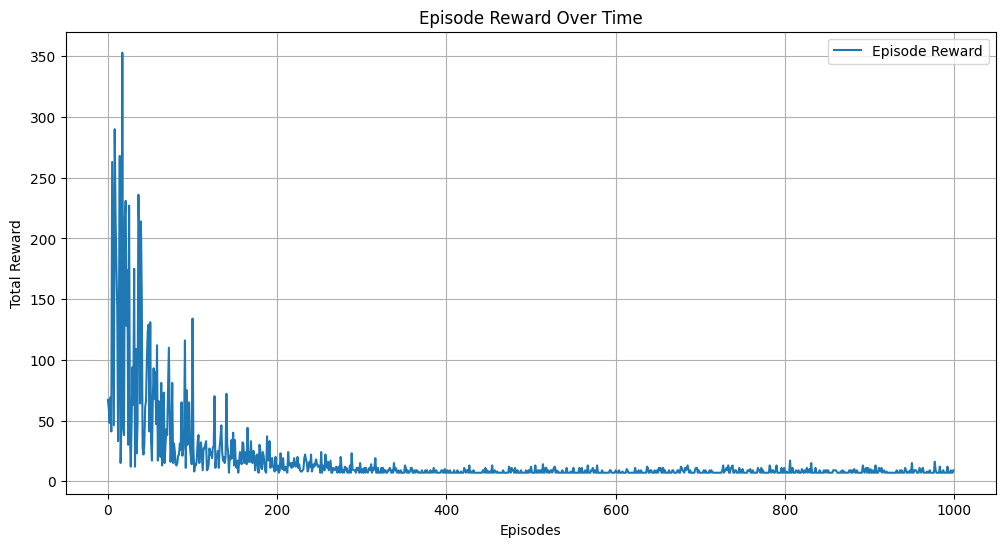

In [21]:
plot_rewards_counts(counts)

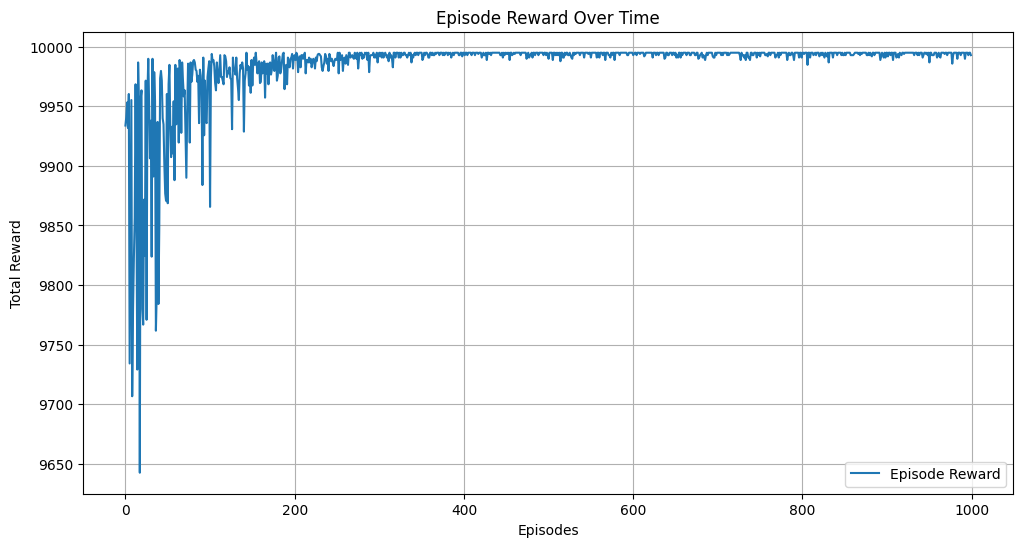

In [23]:
plot_rewards_counts(rewards)

In [25]:
pd.Series(rewards).to_csv('./logs/rewards_qlearning.csv')

In [26]:
show_video()

In [27]:
sarsa_logs = pd.read_csv('./logs/rewards_sarsa.csv', index_col=False).iloc[:, 1]
q_logs = pd.read_csv('./logs/rewards_qlearning.csv', index_col=False).iloc[:, 1]

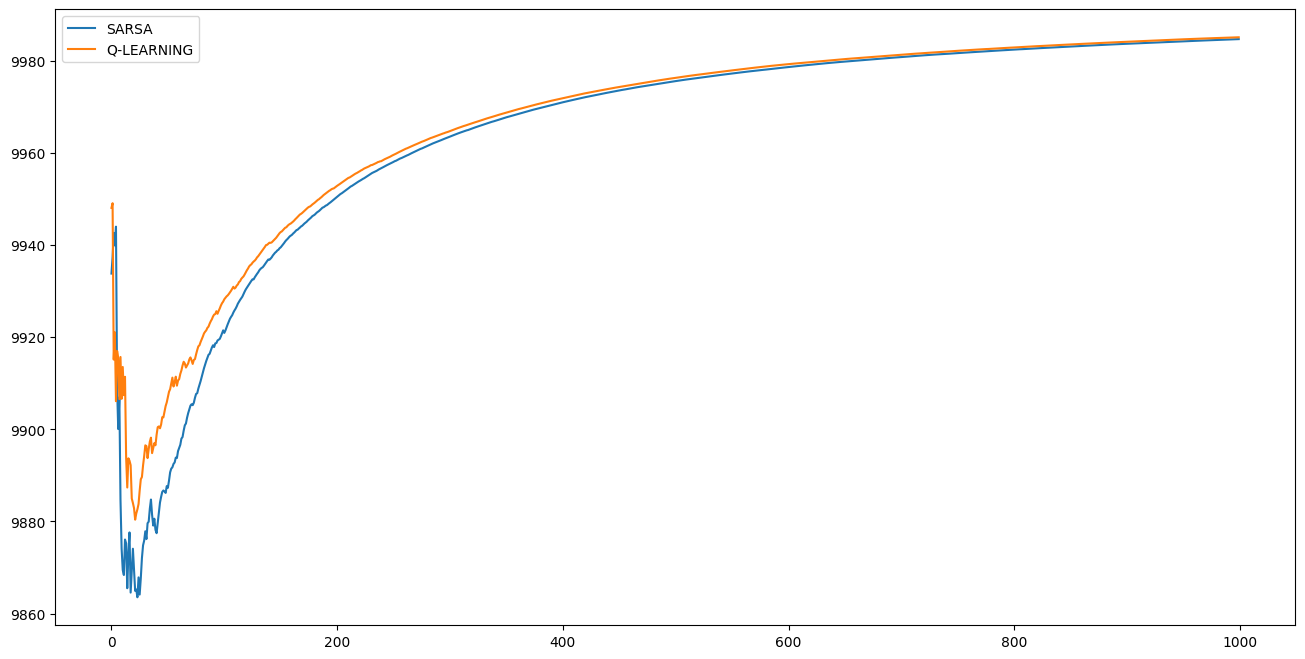

In [30]:
plt.figure(figsize=(16, 8))
plt.plot(q_logs.cumsum() / (pd.Series(np.arange(q_logs.shape[0]))+1), label="SARSA")
plt.plot(sarsa_logs.cumsum() / (pd.Series(np.arange(sarsa_logs.shape[0]))+1), label="Q-LEARNING")
plt.legend()